# 1. take et, gt, random files in overlapRatioTssMeanVar as input
# 2. gives concatenated file as output
# 3. save output in multiClass folder
# 4. tried 3-class randomForest
# 5. results kinda nice, checked the confusion matrix for each class

In [1]:
# first concatenate files with fdr==0.0, 0.05>fdr>0.0, ad fdr>0.05
import numpy as np
import pandas as pd
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

PROJECT_DIR = '/home/shuang/projects/boxy_eqtm'
dataDir = os.path.join(PROJECT_DIR,'data','dataReadyForModeling')
inputDir = os.path.join(dataDir,'overlapRatioTssMeanVar')
outputDir = os.path.join(dataDir,'multiClass')

In [3]:
def draw_roc_curve(fpr,tpr,score):
    '''
    draw roc curve
    '''
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def run_display_output(classifier,test_values, test_labels,DRAW=False):
    '''
    get confusion matrix and auc score for test dataset
    (optional) draw roc curve
    '''
    pred = classifier.predict(test_values)
    tn, fp, fn, tp = confusion_matrix(test_labels,pred).ravel()#confusion matrix
    print(tn,fp,fn,tp)
    sensitivity = tp/(fn+tp)
    specificity = tn/(fp+tn)
    prods = classifier.predict_proba(test_values)[:,1]
    fpr, tpr, _ = metrics.roc_curve(test_labels, prods)
    score = metrics.auc(fpr,tpr) #auc score
    if DRAW:
        draw_roc_curve(fpr,tpr,score)

    return round(sensitivity,2), round(specificity,2), round(score,2)

In [4]:
etPath = os.path.join(inputDir, 'etCpG_withZscoreTss_withMeanVar.csv')
gtPath = os.path.join(inputDir, 'gtCpG_withZscoreTss_withMeanVar.csv')
randomPath = os.path.join(inputDir, 'random20k_gt0.5_withZscoreTss_withMeanVar.csv')

# only for gt0.0 and et0.0 files
def addLabel(row):
    if row > 0:
        return 'Positive'
    else:
        return 'Negative'
def addDirectionRename(eqtmPath):
    eqtmFile = pd.read_csv(eqtmPath,index_col=0)
    eqtmFile['Label'] = eqtmFile['zscore'].apply(addLabel).astype(np.object)
    renameCols = [col for col in eqtmFile.columns if col not in ['cpgName_split']]
    for col in renameCols:
        newName = col.split('_')[0]
        eqtmFile = eqtmFile.rename(index=str,columns={col:newName})
    eqtmFile = eqtmFile.rename(index=str,columns={'H2A':'H2A.Z'})
    return eqtmFile[[
        col for col in eqtmFile.columns if col not in ['cpgName_split']
    ]].copy()

etFile = addDirectionRename(etPath)
gtFile = addDirectionRename(gtPath)
concatenatedFile = pd.concat([etFile,gtFile])

# for gt0.05 (random) file
randomFile = pd.read_csv(randomPath,index_col=0)
randomFile['Label'] = 'Non'
concatenatedFile = pd.concat([concatenatedFile,randomFile])
concatenatedFile.head()
savePath = os.path.join(outputDir,'multiClass.csv')
concatenatedFile.to_csv(savePath,index=False)

In [5]:
concatenatedFile['Label'][concatenatedFile['Label']=='Non'].shape

(20000,)

In [6]:
gtFile.shape

(28454, 38)

In [7]:
concatenatedFile.shape

(55951, 38)

# test multiClassification models

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
from lib.read.read_data import dataset,Datasets,readDataWithRawScore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def readDataWithRawScore(data_table,label_name,test_size=0.25,normalization=True):
    train, test = train_test_split(data_table,test_size=test_size)
    copy_train = train.copy().reset_index()
    copy_test = test.copy().reset_index()
    if normalization:
        minMaxScaler = preprocessing.MinMaxScaler()
        numericalCols = [col for col in
                         train.select_dtypes(exclude=[np.object]).columns
                         if col not in [label_name]]
        train_feature_copy = copy_train.loc[:,numericalCols]
        copy_train.loc[:,numericalCols] = \
        minMaxScaler.fit_transform(train_feature_copy)
        if copy_test.shape[0]>0:
            test_feature_copy = copy_test.loc[:,numericalCols]
            copy_test.loc[:,numericalCols] = \
            minMaxScaler.fit_transform(test_feature_copy)
        print('Data Normalized.')
    train_x = copy_train[[col for col in train.columns if col not in [label_name]]]
    test_x = copy_test[[col for col in test.columns if col not in [label_name]]]
    train_y = copy_train[label_name]
    test_y = copy_test[label_name]
    return Datasets(train=dataset(train_x,train_y),
                    test=dataset(test_x,test_y))

def load_data(path,exclude,test_size=0.25):
    data = pd.read_csv(path,sep=',',index_col=0)
#     def binarize(row):
#         if row > 0:
#             return 1
#         else:
#             return 0
#     data['direction'] = data['zscore'].apply(binarize)
    print('Raw data loaded.')
    features = [feat for feat in data.columns if feat not in exclude]
    dataset = readDataWithRawScore(data[features],'Label',test_size=test_size)
    return dataset

In [9]:
# load the data as regularly done
datapath = os.path.join(outputDir,'multiClass.csv')
data = load_data(datapath,exclude=['cpgName'])

Raw data loaded.
Data Normalized.


In [10]:
data.train.values.columns

Index(['H2A.Z', 'H2AK5ac', 'H2AK9ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac',
       'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2',
       'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2',
       'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me1',
       'H3K9me3', 'H3T11ph', 'H4K12ac', 'H4K20me1', 'H4K5ac', 'H4K8ac',
       'H4K91ac', 'TssDistance', 'methyMean', 'methyVar', 'zscore'],
      dtype='object')

# two classifiers, one for sig/insig, the other for pos/neg

In [11]:
def sigOrInsig(row):
    if row == 'Non':
        return 0
    else:
        return 1
trainLabels = data.train.labels.copy()
testLabels = data.test.labels.copy()

trainLabels_sigOrInsig = trainLabels.apply(sigOrInsig)
trainLabels_sigOrInsig.head()
testLabels_sigOrInsig = testLabels.apply(sigOrInsig)

In [12]:
classifier = RandomForestClassifier(n_estimators = 100)
features = [col for col in data.train.values.columns if col not in ['zscore']]
classifier.fit(data.train.values[features],trainLabels_sigOrInsig)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
features

['H2A.Z',
 'H2AK5ac',
 'H2AK9ac',
 'H2BK120ac',
 'H2BK12ac',
 'H2BK15ac',
 'H2BK20ac',
 'H2BK5ac',
 'H3K14ac',
 'H3K18ac',
 'H3K23ac',
 'H3K23me2',
 'H3K27ac',
 'H3K27me3',
 'H3K36me3',
 'H3K4ac',
 'H3K4me1',
 'H3K4me2',
 'H3K4me3',
 'H3K56ac',
 'H3K79me1',
 'H3K79me2',
 'H3K9ac',
 'H3K9me1',
 'H3K9me3',
 'H3T11ph',
 'H4K12ac',
 'H4K20me1',
 'H4K5ac',
 'H4K8ac',
 'H4K91ac',
 'TssDistance',
 'methyMean',
 'methyVar']

4871 93 105 8919


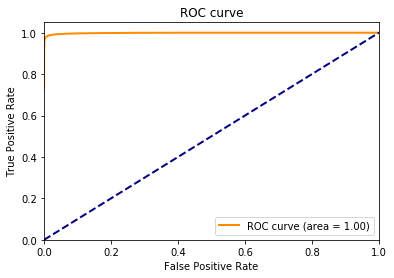

sensitivity 0.99, specificity 0.98, auc 1.0


In [14]:
sensitivity, specificity, score = run_display_output(classifier,data.test.values[features],testLabels_sigOrInsig,DRAW=True)
print('sensitivity {}, specificity {}, auc {}'.format(sensitivity, specificity, score))

In [15]:
classifier.feature_importances_

array([0.10400018, 0.00669686, 0.0189442 , 0.01177513, 0.00670499,
       0.03386529, 0.00404729, 0.0075356 , 0.02047237, 0.05041398,
       0.00558333, 0.02042261, 0.04806461, 0.06256925, 0.05052567,
       0.02209712, 0.13655133, 0.06402943, 0.03860043, 0.01442888,
       0.02988648, 0.0234679 , 0.0282384 , 0.00841489, 0.01537945,
       0.02343243, 0.0252086 , 0.01192849, 0.01056327, 0.04420724,
       0.01822342, 0.01786109, 0.00755262, 0.00830716])

In [16]:
data.test.values[features].columns

Index(['H2A.Z', 'H2AK5ac', 'H2AK9ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac',
       'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2',
       'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2',
       'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me1',
       'H3K9me3', 'H3T11ph', 'H4K12ac', 'H4K20me1', 'H4K5ac', 'H4K8ac',
       'H4K91ac', 'TssDistance', 'methyMean', 'methyVar'],
      dtype='object')

In [17]:
trainLabels = data.train.labels.copy()
testLabels = data.test.labels.copy()

In [18]:
trainLabels[trainLabels=='Negative']=0
trainLabels[trainLabels=='Positive']=1
trainLabels[trainLabels=='Non']=2

testLabels[testLabels=='Negative']=0
testLabels[testLabels=='Positive']=1
testLabels[testLabels=='Non']=2

In [19]:
trainLabels = trainLabels.astype(np.int8)
testLabels = testLabels.astype(np.int8)

In [20]:
# randomForest Test
print('Dataset:', data.train.values.shape)
pipeline = Pipeline(steps=[('ranfor',
                        RandomForestClassifier())])
n_estimators = [100]

Dataset: (41963, 35)


In [21]:
param_grid = [{'ranfor__n_estimators':n_estimators}]
classifier = GridSearchCV(estimator=pipeline,
                          param_grid=param_grid)
classifier.fit(data.train.values[features],trainLabels)
print(classifier)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'ranfor__n_estimators': [100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [22]:
len(classifier.best_estimator_.steps[0][1].feature_importances_)

34

In [23]:
len(data.test.values[features].columns)

34

In [24]:
pred = classifier.predict(data.test.values[features])
prob = classifier.predict_proba(data.test.values[features])
print(pred.shape, prob[0].shape)

(13988,) (3,)


In [25]:
pred

array([0, 2, 0, ..., 2, 0, 2], dtype=int8)

In [26]:
prob

array([[0.65, 0.35, 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       ...,
       [0.  , 0.01, 0.99],
       [0.86, 0.12, 0.02],
       [0.  , 0.02, 0.98]])

In [27]:
testLabels.head()

0    1
1    2
2    0
3    1
4    2
Name: Label, dtype: int8

In [28]:
classifier.score(data.test.values[features],testLabels)

0.833786102373463

# test shallow network

In [41]:
import tensorflow as tf
from math import ceil
from lib.read.read_data import dataset,Datasets
import tensorflow as tf
import tensorflow.contrib.layers as lays
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import losses
from tensorflow.contrib.slim import arg_scope

In [19]:
def fnn_multiClass(x):
    with arg_scope([slim.fully_connected],
    weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
    weights_regularizer=slim.l2_regularizer(0.005)):
        net = slim.fully_connected(x,20)
        net = slim.fully_connected(net,10)
        net = slim.fully_connected(net,3)
        cls_prob = tf.nn.softmax(net, name="cls_prob")
    return net, cls_prob
def dense_to_one_hot(labels_dense, num_classes):
  '''
  Convert class labels from scalars to one-hot vectors.
  '''
  return np.eye(num_classes)[np.array(labels_dense).reshape(-1)]

In [104]:
def test_shallowNetwork(train_fn, test_fn):
    # constant
    batch_size = 100
    epoch_num = 100
    lr = 0.01

    batch_per_ep = ceil(train_fn.num_examples/batch_size)


    # ================== feedforward shallow network ===========================
    # model
    inputs = tf.placeholder(tf.float32,(None, train_fn.num_features))
    labels = tf.placeholder(tf.float32,(None, 3))
    fn_outputs,fn_probs = fnn_multiClass(inputs)
    # loss and training options
    loss_fn = tf.reduce_mean(
                    tf.nn.weighted_cross_entropy_with_logits(
                    targets=labels,
                    logits=fn_outputs,
                    pos_weight=4))
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss_fn)

    # initializer
    init = tf.global_variables_initializer()

    # start training
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(epoch_num):
            for batch_no in range(batch_per_ep):
                batch_data, batch_label = train_fn.next_batch(batch_size)
                batch_label_onehot = batch_label
                _, probs,error = sess.run([train_op,
                                           fn_probs,loss_fn],
                                           feed_dict={inputs:batch_data,
                                           labels:batch_label_onehot})
                print('Epoch: {0}\tIteration:{1}\tError: {2}\t'.format(
                ep, batch_no, error
                ))

        # test
        batch_label_onehot = test_fn.labels
        _,probs,_ = sess.run([fn_outputs,
                              fn_probs,
                              loss_fn],
                              feed_dict={inputs:test_fn.values,
                                         labels:batch_label_onehot})

        probability = np.amax(prob,axis=2)
        probability = np.swapaxes(probability,0,1)
        pred = dense_to_one_hot(np.argmax(probability,axis=1),3)

        for i in range(3):
            tn,fp,fn,tp = confusion_matrix(testLabels['Negative'],pred[:,i]).ravel()
            print(tn,fp,fn,tp)

In [63]:
fnn_dataset = Datasets(train=dataset(np.array(data.train.values),np.array(trainLabels)),
                    test=dataset(np.array(data.test.values),np.array(testLabels)))

In [106]:
print(fnn_dataset.train.values.shape,fnn_dataset.test.values.shape)

(32984, 35) (10995, 35)


In [105]:
test_shallowNetwork(fnn_dataset.train, fnn_dataset.test)

Epoch: 0	Iteration:0	Error: 1.3862913846969604	
Epoch: 0	Iteration:1	Error: 1.3824386596679688	
Epoch: 0	Iteration:2	Error: 1.3794419765472412	
Epoch: 0	Iteration:3	Error: 1.369336724281311	
Epoch: 0	Iteration:4	Error: 1.359475016593933	
Epoch: 0	Iteration:5	Error: 1.346388339996338	
Epoch: 0	Iteration:6	Error: 1.3298091888427734	
Epoch: 0	Iteration:7	Error: 1.3030426502227783	
Epoch: 0	Iteration:8	Error: 1.2920989990234375	
Epoch: 0	Iteration:9	Error: 1.2700614929199219	
Epoch: 0	Iteration:10	Error: 1.2648142576217651	
Epoch: 0	Iteration:11	Error: 1.2129930257797241	
Epoch: 0	Iteration:12	Error: 1.184701919555664	
Epoch: 0	Iteration:13	Error: 1.1687836647033691	
Epoch: 0	Iteration:14	Error: 1.1628766059875488	
Epoch: 0	Iteration:15	Error: 1.3131990432739258	
Epoch: 0	Iteration:16	Error: 1.2840791940689087	
Epoch: 0	Iteration:17	Error: 1.1718121767044067	
Epoch: 0	Iteration:18	Error: 1.2472712993621826	
Epoch: 0	Iteration:19	Error: 1.1966321468353271	
Epoch: 0	Iteration:20	Error: 1.245

Epoch: 0	Iteration:193	Error: 1.054071307182312	
Epoch: 0	Iteration:194	Error: 0.9650615453720093	
Epoch: 0	Iteration:195	Error: 1.0056662559509277	
Epoch: 0	Iteration:196	Error: 0.9729827642440796	
Epoch: 0	Iteration:197	Error: 1.0218780040740967	
Epoch: 0	Iteration:198	Error: 0.9843079447746277	
Epoch: 0	Iteration:199	Error: 1.03192138671875	
Epoch: 0	Iteration:200	Error: 1.0096276998519897	
Epoch: 0	Iteration:201	Error: 1.0998542308807373	
Epoch: 0	Iteration:202	Error: 1.026900053024292	
Epoch: 0	Iteration:203	Error: 0.9430601000785828	
Epoch: 0	Iteration:204	Error: 0.9736548066139221	
Epoch: 0	Iteration:205	Error: 0.9055250883102417	
Epoch: 0	Iteration:206	Error: 0.9418420195579529	
Epoch: 0	Iteration:207	Error: 1.0167087316513062	
Epoch: 0	Iteration:208	Error: 0.9872961640357971	
Epoch: 0	Iteration:209	Error: 1.0336755514144897	
Epoch: 0	Iteration:210	Error: 0.8600538969039917	
Epoch: 0	Iteration:211	Error: 0.9362359642982483	
Epoch: 0	Iteration:212	Error: 0.914319634437561	
Epoch

Epoch: 1	Iteration:32	Error: 0.7015016674995422	
Epoch: 1	Iteration:33	Error: 0.6649389863014221	
Epoch: 1	Iteration:34	Error: 0.740969181060791	
Epoch: 1	Iteration:35	Error: 0.6988797187805176	
Epoch: 1	Iteration:36	Error: 0.6494202017784119	
Epoch: 1	Iteration:37	Error: 0.6870265603065491	
Epoch: 1	Iteration:38	Error: 0.6784918308258057	
Epoch: 1	Iteration:39	Error: 0.6210013031959534	
Epoch: 1	Iteration:40	Error: 0.6969162821769714	
Epoch: 1	Iteration:41	Error: 0.6932915449142456	
Epoch: 1	Iteration:42	Error: 0.6785520911216736	
Epoch: 1	Iteration:43	Error: 0.6804109811782837	
Epoch: 1	Iteration:44	Error: 0.772332489490509	
Epoch: 1	Iteration:45	Error: 0.6486509442329407	
Epoch: 1	Iteration:46	Error: 0.7020162343978882	
Epoch: 1	Iteration:47	Error: 0.8190553784370422	
Epoch: 1	Iteration:48	Error: 0.7380253672599792	
Epoch: 1	Iteration:49	Error: 0.6572428345680237	
Epoch: 1	Iteration:50	Error: 0.6762820482254028	
Epoch: 1	Iteration:51	Error: 0.72150719165802	
Epoch: 1	Iteration:52	Er

Epoch: 1	Iteration:228	Error: 0.6310592889785767	
Epoch: 1	Iteration:229	Error: 0.7243300080299377	
Epoch: 1	Iteration:230	Error: 0.6884990930557251	
Epoch: 1	Iteration:231	Error: 0.6711819767951965	
Epoch: 1	Iteration:232	Error: 0.6963598728179932	
Epoch: 1	Iteration:233	Error: 0.6339878439903259	
Epoch: 1	Iteration:234	Error: 0.6916848421096802	
Epoch: 1	Iteration:235	Error: 0.6408668756484985	
Epoch: 1	Iteration:236	Error: 0.7377670407295227	
Epoch: 1	Iteration:237	Error: 0.6914278268814087	
Epoch: 1	Iteration:238	Error: 0.5934457778930664	
Epoch: 1	Iteration:239	Error: 0.7077386975288391	
Epoch: 1	Iteration:240	Error: 0.6645604372024536	
Epoch: 1	Iteration:241	Error: 0.7223013043403625	
Epoch: 1	Iteration:242	Error: 0.6208061575889587	
Epoch: 1	Iteration:243	Error: 0.7166897654533386	
Epoch: 1	Iteration:244	Error: 0.6725167632102966	
Epoch: 1	Iteration:245	Error: 0.6333242058753967	
Epoch: 1	Iteration:246	Error: 0.6942433714866638	
Epoch: 1	Iteration:247	Error: 0.7210953831672668	


Epoch: 2	Iteration:81	Error: 0.7009097337722778	
Epoch: 2	Iteration:82	Error: 0.6576524972915649	
Epoch: 2	Iteration:83	Error: 0.6649001836776733	
Epoch: 2	Iteration:84	Error: 0.6727641820907593	
Epoch: 2	Iteration:85	Error: 0.7251342535018921	
Epoch: 2	Iteration:86	Error: 0.6741740107536316	
Epoch: 2	Iteration:87	Error: 0.6076425313949585	
Epoch: 2	Iteration:88	Error: 0.6661689281463623	
Epoch: 2	Iteration:89	Error: 0.7461755275726318	
Epoch: 2	Iteration:90	Error: 0.6963247656822205	
Epoch: 2	Iteration:91	Error: 0.6754350662231445	
Epoch: 2	Iteration:92	Error: 0.7375308871269226	
Epoch: 2	Iteration:93	Error: 0.5892267823219299	
Epoch: 2	Iteration:94	Error: 0.7411555051803589	
Epoch: 2	Iteration:95	Error: 0.6655398607254028	
Epoch: 2	Iteration:96	Error: 0.7560786604881287	
Epoch: 2	Iteration:97	Error: 0.6743677854537964	
Epoch: 2	Iteration:98	Error: 0.6713577508926392	
Epoch: 2	Iteration:99	Error: 0.624658465385437	
Epoch: 2	Iteration:100	Error: 0.6791399121284485	
Epoch: 2	Iteration:1

Epoch: 2	Iteration:272	Error: 0.7044582962989807	
Epoch: 2	Iteration:273	Error: 0.7413457632064819	
Epoch: 2	Iteration:274	Error: 0.638218104839325	
Epoch: 2	Iteration:275	Error: 0.6194612979888916	
Epoch: 2	Iteration:276	Error: 0.645306408405304	
Epoch: 2	Iteration:277	Error: 0.6226869821548462	
Epoch: 2	Iteration:278	Error: 0.6916388869285583	
Epoch: 2	Iteration:279	Error: 0.6928312182426453	
Epoch: 2	Iteration:280	Error: 0.6283295154571533	
Epoch: 2	Iteration:281	Error: 0.6568151116371155	
Epoch: 2	Iteration:282	Error: 0.6043903827667236	
Epoch: 2	Iteration:283	Error: 0.6936447024345398	
Epoch: 2	Iteration:284	Error: 0.6251989006996155	
Epoch: 2	Iteration:285	Error: 0.653258204460144	
Epoch: 2	Iteration:286	Error: 0.6881449222564697	
Epoch: 2	Iteration:287	Error: 0.6632933616638184	
Epoch: 2	Iteration:288	Error: 0.6173650026321411	
Epoch: 2	Iteration:289	Error: 0.6554074287414551	
Epoch: 2	Iteration:290	Error: 0.6457708477973938	
Epoch: 2	Iteration:291	Error: 0.6501561403274536	
Epo

Epoch: 3	Iteration:126	Error: 0.7251928448677063	
Epoch: 3	Iteration:127	Error: 0.6462348103523254	
Epoch: 3	Iteration:128	Error: 0.6320559978485107	
Epoch: 3	Iteration:129	Error: 0.6042818427085876	
Epoch: 3	Iteration:130	Error: 0.6509249806404114	
Epoch: 3	Iteration:131	Error: 0.7164064645767212	
Epoch: 3	Iteration:132	Error: 0.6388482451438904	
Epoch: 3	Iteration:133	Error: 0.6464406251907349	
Epoch: 3	Iteration:134	Error: 0.6363691091537476	
Epoch: 3	Iteration:135	Error: 0.6282846331596375	
Epoch: 3	Iteration:136	Error: 0.6109656691551208	
Epoch: 3	Iteration:137	Error: 0.5904772877693176	
Epoch: 3	Iteration:138	Error: 0.6528278589248657	
Epoch: 3	Iteration:139	Error: 0.6328020095825195	
Epoch: 3	Iteration:140	Error: 0.6656321883201599	
Epoch: 3	Iteration:141	Error: 0.6352642178535461	
Epoch: 3	Iteration:142	Error: 0.6562008857727051	
Epoch: 3	Iteration:143	Error: 0.6299033761024475	
Epoch: 3	Iteration:144	Error: 0.6864678859710693	
Epoch: 3	Iteration:145	Error: 0.6246196627616882	


Epoch: 3	Iteration:310	Error: 0.5574984550476074	
Epoch: 3	Iteration:311	Error: 0.6567575931549072	
Epoch: 3	Iteration:312	Error: 0.6596517562866211	
Epoch: 3	Iteration:313	Error: 0.69501131772995	
Epoch: 3	Iteration:314	Error: 0.6556787490844727	
Epoch: 3	Iteration:315	Error: 0.6566298604011536	
Epoch: 3	Iteration:316	Error: 0.6239160895347595	
Epoch: 3	Iteration:317	Error: 0.6956150531768799	
Epoch: 3	Iteration:318	Error: 0.634002149105072	
Epoch: 3	Iteration:319	Error: 0.6727651953697205	
Epoch: 3	Iteration:320	Error: 0.6528592705726624	
Epoch: 3	Iteration:321	Error: 0.6407681107521057	
Epoch: 3	Iteration:322	Error: 0.6542569994926453	
Epoch: 3	Iteration:323	Error: 0.6095477938652039	
Epoch: 3	Iteration:324	Error: 0.6094651818275452	
Epoch: 3	Iteration:325	Error: 0.6411105394363403	
Epoch: 3	Iteration:326	Error: 0.612562358379364	
Epoch: 3	Iteration:327	Error: 0.6550891995429993	
Epoch: 3	Iteration:328	Error: 0.5726116895675659	
Epoch: 3	Iteration:329	Error: 0.6260228753089905	
Epoc

Epoch: 4	Iteration:167	Error: 0.6708272099494934	
Epoch: 4	Iteration:168	Error: 0.6819089651107788	
Epoch: 4	Iteration:169	Error: 0.6165996193885803	
Epoch: 4	Iteration:170	Error: 0.6863479018211365	
Epoch: 4	Iteration:171	Error: 0.6379703879356384	
Epoch: 4	Iteration:172	Error: 0.7272946238517761	
Epoch: 4	Iteration:173	Error: 0.6613381505012512	
Epoch: 4	Iteration:174	Error: 0.6903549432754517	
Epoch: 4	Iteration:175	Error: 0.6834437847137451	
Epoch: 4	Iteration:176	Error: 0.5854722261428833	
Epoch: 4	Iteration:177	Error: 0.6225137114524841	
Epoch: 4	Iteration:178	Error: 0.6604945659637451	
Epoch: 4	Iteration:179	Error: 0.5940759778022766	
Epoch: 4	Iteration:180	Error: 0.6527806520462036	
Epoch: 4	Iteration:181	Error: 0.6411182880401611	
Epoch: 4	Iteration:182	Error: 0.6462529897689819	
Epoch: 4	Iteration:183	Error: 0.6695550680160522	
Epoch: 4	Iteration:184	Error: 0.6595246195793152	
Epoch: 4	Iteration:185	Error: 0.5933187007904053	
Epoch: 4	Iteration:186	Error: 0.6475654244422913	


Epoch: 5	Iteration:21	Error: 0.6465380787849426	
Epoch: 5	Iteration:22	Error: 0.5540603399276733	
Epoch: 5	Iteration:23	Error: 0.6874401569366455	
Epoch: 5	Iteration:24	Error: 0.6523227691650391	
Epoch: 5	Iteration:25	Error: 0.6663147807121277	
Epoch: 5	Iteration:26	Error: 0.5797935724258423	
Epoch: 5	Iteration:27	Error: 0.6376026272773743	
Epoch: 5	Iteration:28	Error: 0.5985284447669983	
Epoch: 5	Iteration:29	Error: 0.6617555618286133	
Epoch: 5	Iteration:30	Error: 0.5902138948440552	
Epoch: 5	Iteration:31	Error: 0.6612704396247864	
Epoch: 5	Iteration:32	Error: 0.6688861846923828	
Epoch: 5	Iteration:33	Error: 0.5951917767524719	
Epoch: 5	Iteration:34	Error: 0.6629746556282043	
Epoch: 5	Iteration:35	Error: 0.6313427686691284	
Epoch: 5	Iteration:36	Error: 0.576934278011322	
Epoch: 5	Iteration:37	Error: 0.6201974749565125	
Epoch: 5	Iteration:38	Error: 0.5872794389724731	
Epoch: 5	Iteration:39	Error: 0.6607950925827026	
Epoch: 5	Iteration:40	Error: 0.6718893647193909	
Epoch: 5	Iteration:41

Epoch: 5	Iteration:209	Error: 0.6111361980438232	
Epoch: 5	Iteration:210	Error: 0.672481894493103	
Epoch: 5	Iteration:211	Error: 0.6613654494285583	
Epoch: 5	Iteration:212	Error: 0.6590036749839783	
Epoch: 5	Iteration:213	Error: 0.6715064644813538	
Epoch: 5	Iteration:214	Error: 0.7148729562759399	
Epoch: 5	Iteration:215	Error: 0.630951464176178	
Epoch: 5	Iteration:216	Error: 0.6865648031234741	
Epoch: 5	Iteration:217	Error: 0.6406940817832947	
Epoch: 5	Iteration:218	Error: 0.5671326518058777	
Epoch: 5	Iteration:219	Error: 0.5973351001739502	
Epoch: 5	Iteration:220	Error: 0.6179048418998718	
Epoch: 5	Iteration:221	Error: 0.6610414385795593	
Epoch: 5	Iteration:222	Error: 0.5843656659126282	
Epoch: 5	Iteration:223	Error: 0.5597575902938843	
Epoch: 5	Iteration:224	Error: 0.6964328289031982	
Epoch: 5	Iteration:225	Error: 0.6471226215362549	
Epoch: 5	Iteration:226	Error: 0.6540567874908447	
Epoch: 5	Iteration:227	Error: 0.6593964695930481	
Epoch: 5	Iteration:228	Error: 0.6613282561302185	
Ep

Epoch: 6	Iteration:64	Error: 0.6662898659706116	
Epoch: 6	Iteration:65	Error: 0.6337496042251587	
Epoch: 6	Iteration:66	Error: 0.5797741413116455	
Epoch: 6	Iteration:67	Error: 0.6029970049858093	
Epoch: 6	Iteration:68	Error: 0.6161306500434875	
Epoch: 6	Iteration:69	Error: 0.603046715259552	
Epoch: 6	Iteration:70	Error: 0.7067064642906189	
Epoch: 6	Iteration:71	Error: 0.6454988718032837	
Epoch: 6	Iteration:72	Error: 0.6216877102851868	
Epoch: 6	Iteration:73	Error: 0.6618340015411377	
Epoch: 6	Iteration:74	Error: 0.6600537896156311	
Epoch: 6	Iteration:75	Error: 0.6034963726997375	
Epoch: 6	Iteration:76	Error: 0.6725101470947266	
Epoch: 6	Iteration:77	Error: 0.5379682779312134	
Epoch: 6	Iteration:78	Error: 0.604051411151886	
Epoch: 6	Iteration:79	Error: 0.5990117192268372	
Epoch: 6	Iteration:80	Error: 0.7151464819908142	
Epoch: 6	Iteration:81	Error: 0.7114129662513733	
Epoch: 6	Iteration:82	Error: 0.7644601464271545	
Epoch: 6	Iteration:83	Error: 0.691590428352356	
Epoch: 6	Iteration:84	E

Epoch: 6	Iteration:253	Error: 0.679417610168457	
Epoch: 6	Iteration:254	Error: 0.5683284997940063	
Epoch: 6	Iteration:255	Error: 0.5962733030319214	
Epoch: 6	Iteration:256	Error: 0.6371493339538574	
Epoch: 6	Iteration:257	Error: 0.6581456661224365	
Epoch: 6	Iteration:258	Error: 0.6839317083358765	
Epoch: 6	Iteration:259	Error: 0.5761873126029968	
Epoch: 6	Iteration:260	Error: 0.6171492338180542	
Epoch: 6	Iteration:261	Error: 0.5951405167579651	
Epoch: 6	Iteration:262	Error: 0.6409297585487366	
Epoch: 6	Iteration:263	Error: 0.6758617162704468	
Epoch: 6	Iteration:264	Error: 0.6382312774658203	
Epoch: 6	Iteration:265	Error: 0.6383547186851501	
Epoch: 6	Iteration:266	Error: 0.5858802795410156	
Epoch: 6	Iteration:267	Error: 0.6533986330032349	
Epoch: 6	Iteration:268	Error: 0.6365072131156921	
Epoch: 6	Iteration:269	Error: 0.5606002807617188	
Epoch: 6	Iteration:270	Error: 0.6719515919685364	
Epoch: 6	Iteration:271	Error: 0.6313463449478149	
Epoch: 6	Iteration:272	Error: 0.6209444999694824	
E

Epoch: 7	Iteration:106	Error: 0.5671849846839905	
Epoch: 7	Iteration:107	Error: 0.6302046179771423	
Epoch: 7	Iteration:108	Error: 0.6697269678115845	
Epoch: 7	Iteration:109	Error: 0.6391057372093201	
Epoch: 7	Iteration:110	Error: 0.6763611435890198	
Epoch: 7	Iteration:111	Error: 0.593903660774231	
Epoch: 7	Iteration:112	Error: 0.7021339535713196	
Epoch: 7	Iteration:113	Error: 0.7078304886817932	
Epoch: 7	Iteration:114	Error: 0.6699221730232239	
Epoch: 7	Iteration:115	Error: 0.6686656475067139	
Epoch: 7	Iteration:116	Error: 0.5858857035636902	
Epoch: 7	Iteration:117	Error: 0.6048935651779175	
Epoch: 7	Iteration:118	Error: 0.7031196355819702	
Epoch: 7	Iteration:119	Error: 0.5700223445892334	
Epoch: 7	Iteration:120	Error: 0.596018373966217	
Epoch: 7	Iteration:121	Error: 0.6154072880744934	
Epoch: 7	Iteration:122	Error: 0.6047167778015137	
Epoch: 7	Iteration:123	Error: 0.698146641254425	
Epoch: 7	Iteration:124	Error: 0.644802451133728	
Epoch: 7	Iteration:125	Error: 0.6286799311637878	
Epoc

Epoch: 7	Iteration:295	Error: 0.6394793391227722	
Epoch: 7	Iteration:296	Error: 0.6422682404518127	
Epoch: 7	Iteration:297	Error: 0.62175452709198	
Epoch: 7	Iteration:298	Error: 0.5908703804016113	
Epoch: 7	Iteration:299	Error: 0.622241735458374	
Epoch: 7	Iteration:300	Error: 0.6874545812606812	
Epoch: 7	Iteration:301	Error: 0.6237929463386536	
Epoch: 7	Iteration:302	Error: 0.7454391121864319	
Epoch: 7	Iteration:303	Error: 0.6589081883430481	
Epoch: 7	Iteration:304	Error: 0.7273851037025452	
Epoch: 7	Iteration:305	Error: 0.6241623163223267	
Epoch: 7	Iteration:306	Error: 0.7305365204811096	
Epoch: 7	Iteration:307	Error: 0.6614488959312439	
Epoch: 7	Iteration:308	Error: 0.6698402166366577	
Epoch: 7	Iteration:309	Error: 0.5758396983146667	
Epoch: 7	Iteration:310	Error: 0.6459709405899048	
Epoch: 7	Iteration:311	Error: 0.6420404314994812	
Epoch: 7	Iteration:312	Error: 0.5523245334625244	
Epoch: 7	Iteration:313	Error: 0.6543455123901367	
Epoch: 7	Iteration:314	Error: 0.668313205242157	
Epoc

Epoch: 8	Iteration:154	Error: 0.6178500056266785	
Epoch: 8	Iteration:155	Error: 0.6671811938285828	
Epoch: 8	Iteration:156	Error: 0.6249254941940308	
Epoch: 8	Iteration:157	Error: 0.7300959229469299	
Epoch: 8	Iteration:158	Error: 0.6156933307647705	
Epoch: 8	Iteration:159	Error: 0.6398693323135376	
Epoch: 8	Iteration:160	Error: 0.6095355153083801	
Epoch: 8	Iteration:161	Error: 0.6496090888977051	
Epoch: 8	Iteration:162	Error: 0.624945878982544	
Epoch: 8	Iteration:163	Error: 0.6747594475746155	
Epoch: 8	Iteration:164	Error: 0.629788339138031	
Epoch: 8	Iteration:165	Error: 0.6505665183067322	
Epoch: 8	Iteration:166	Error: 0.7475318908691406	
Epoch: 8	Iteration:167	Error: 0.648070752620697	
Epoch: 8	Iteration:168	Error: 0.633876383304596	
Epoch: 8	Iteration:169	Error: 0.6575537919998169	
Epoch: 8	Iteration:170	Error: 0.6738593578338623	
Epoch: 8	Iteration:171	Error: 0.6322580575942993	
Epoch: 8	Iteration:172	Error: 0.6529754400253296	
Epoch: 8	Iteration:173	Error: 0.6314249634742737	
Epoc

Epoch: 9	Iteration:7	Error: 0.6072069406509399	
Epoch: 9	Iteration:8	Error: 0.6619882583618164	
Epoch: 9	Iteration:9	Error: 0.660420298576355	
Epoch: 9	Iteration:10	Error: 0.5963226556777954	
Epoch: 9	Iteration:11	Error: 0.6261345744132996	
Epoch: 9	Iteration:12	Error: 0.5823742747306824	
Epoch: 9	Iteration:13	Error: 0.6676002144813538	
Epoch: 9	Iteration:14	Error: 0.6371163725852966	
Epoch: 9	Iteration:15	Error: 0.610102653503418	
Epoch: 9	Iteration:16	Error: 0.6424946188926697	
Epoch: 9	Iteration:17	Error: 0.6664718389511108	
Epoch: 9	Iteration:18	Error: 0.618033230304718	
Epoch: 9	Iteration:19	Error: 0.6483177542686462	
Epoch: 9	Iteration:20	Error: 0.6362805962562561	
Epoch: 9	Iteration:21	Error: 0.7233163714408875	
Epoch: 9	Iteration:22	Error: 0.6257545351982117	
Epoch: 9	Iteration:23	Error: 0.6444764733314514	
Epoch: 9	Iteration:24	Error: 0.6129432320594788	
Epoch: 9	Iteration:25	Error: 0.7223014235496521	
Epoch: 9	Iteration:26	Error: 0.6451641917228699	
Epoch: 9	Iteration:27	Erro

Epoch: 9	Iteration:198	Error: 0.6618928909301758	
Epoch: 9	Iteration:199	Error: 0.6496710181236267	
Epoch: 9	Iteration:200	Error: 0.6104907393455505	
Epoch: 9	Iteration:201	Error: 0.7038306593894958	
Epoch: 9	Iteration:202	Error: 0.6109219193458557	
Epoch: 9	Iteration:203	Error: 0.7055582404136658	
Epoch: 9	Iteration:204	Error: 0.6660049557685852	
Epoch: 9	Iteration:205	Error: 0.6222571134567261	
Epoch: 9	Iteration:206	Error: 0.6031648516654968	
Epoch: 9	Iteration:207	Error: 0.6903915405273438	
Epoch: 9	Iteration:208	Error: 0.64033442735672	
Epoch: 9	Iteration:209	Error: 0.7031005620956421	
Epoch: 9	Iteration:210	Error: 0.6561752557754517	
Epoch: 9	Iteration:211	Error: 0.6787861585617065	
Epoch: 9	Iteration:212	Error: 0.6662254929542542	
Epoch: 9	Iteration:213	Error: 0.6461259722709656	
Epoch: 9	Iteration:214	Error: 0.6420443058013916	
Epoch: 9	Iteration:215	Error: 0.5735985040664673	
Epoch: 9	Iteration:216	Error: 0.6383315324783325	
Epoch: 9	Iteration:217	Error: 0.6509857177734375	
Ep

Epoch: 10	Iteration:52	Error: 0.6496705412864685	
Epoch: 10	Iteration:53	Error: 0.6498616933822632	
Epoch: 10	Iteration:54	Error: 0.7003876566886902	
Epoch: 10	Iteration:55	Error: 0.649057149887085	
Epoch: 10	Iteration:56	Error: 0.6858334541320801	
Epoch: 10	Iteration:57	Error: 0.688776433467865	
Epoch: 10	Iteration:58	Error: 0.64265376329422	
Epoch: 10	Iteration:59	Error: 0.6154095530509949	
Epoch: 10	Iteration:60	Error: 0.756335973739624	
Epoch: 10	Iteration:61	Error: 0.6881807446479797	
Epoch: 10	Iteration:62	Error: 0.6482079029083252	
Epoch: 10	Iteration:63	Error: 0.6636690497398376	
Epoch: 10	Iteration:64	Error: 0.6301999092102051	
Epoch: 10	Iteration:65	Error: 0.6807802319526672	
Epoch: 10	Iteration:66	Error: 0.5822159051895142	
Epoch: 10	Iteration:67	Error: 0.6778992414474487	
Epoch: 10	Iteration:68	Error: 0.6078174710273743	
Epoch: 10	Iteration:69	Error: 0.6652607321739197	
Epoch: 10	Iteration:70	Error: 0.697880744934082	
Epoch: 10	Iteration:71	Error: 0.6117686033248901	
Epoch:

Epoch: 10	Iteration:242	Error: 0.6278501152992249	
Epoch: 10	Iteration:243	Error: 0.6399382948875427	
Epoch: 10	Iteration:244	Error: 0.6578963994979858	
Epoch: 10	Iteration:245	Error: 0.6785654425621033	
Epoch: 10	Iteration:246	Error: 0.7042255401611328	
Epoch: 10	Iteration:247	Error: 0.7024940848350525	
Epoch: 10	Iteration:248	Error: 0.6418771147727966	
Epoch: 10	Iteration:249	Error: 0.6578915119171143	
Epoch: 10	Iteration:250	Error: 0.6383585333824158	
Epoch: 10	Iteration:251	Error: 0.6434642672538757	
Epoch: 10	Iteration:252	Error: 0.655559778213501	
Epoch: 10	Iteration:253	Error: 0.6698750257492065	
Epoch: 10	Iteration:254	Error: 0.6331923604011536	
Epoch: 10	Iteration:255	Error: 0.5768038034439087	
Epoch: 10	Iteration:256	Error: 0.6651592254638672	
Epoch: 10	Iteration:257	Error: 0.6733748316764832	
Epoch: 10	Iteration:258	Error: 0.6538926959037781	
Epoch: 10	Iteration:259	Error: 0.5940014123916626	
Epoch: 10	Iteration:260	Error: 0.5955914258956909	
Epoch: 10	Iteration:261	Error: 0

Epoch: 11	Iteration:97	Error: 0.6677466034889221	
Epoch: 11	Iteration:98	Error: 0.6759811043739319	
Epoch: 11	Iteration:99	Error: 0.6150063276290894	
Epoch: 11	Iteration:100	Error: 0.6494003534317017	
Epoch: 11	Iteration:101	Error: 0.6672770977020264	
Epoch: 11	Iteration:102	Error: 0.5855132937431335	
Epoch: 11	Iteration:103	Error: 0.5850992798805237	
Epoch: 11	Iteration:104	Error: 0.6422393918037415	
Epoch: 11	Iteration:105	Error: 0.691670835018158	
Epoch: 11	Iteration:106	Error: 0.6953656077384949	
Epoch: 11	Iteration:107	Error: 0.698974609375	
Epoch: 11	Iteration:108	Error: 0.5565295219421387	
Epoch: 11	Iteration:109	Error: 0.6239436864852905	
Epoch: 11	Iteration:110	Error: 0.5760464668273926	
Epoch: 11	Iteration:111	Error: 0.566292941570282	
Epoch: 11	Iteration:112	Error: 0.5790895819664001	
Epoch: 11	Iteration:113	Error: 0.6090247631072998	
Epoch: 11	Iteration:114	Error: 0.6416069269180298	
Epoch: 11	Iteration:115	Error: 0.6762758493423462	
Epoch: 11	Iteration:116	Error: 0.6607680

Epoch: 11	Iteration:286	Error: 0.6117008924484253	
Epoch: 11	Iteration:287	Error: 0.6488678455352783	
Epoch: 11	Iteration:288	Error: 0.6544303894042969	
Epoch: 11	Iteration:289	Error: 0.7003636956214905	
Epoch: 11	Iteration:290	Error: 0.640162467956543	
Epoch: 11	Iteration:291	Error: 0.6299196481704712	
Epoch: 11	Iteration:292	Error: 0.6300404667854309	
Epoch: 11	Iteration:293	Error: 0.6334962844848633	
Epoch: 11	Iteration:294	Error: 0.6113633513450623	
Epoch: 11	Iteration:295	Error: 0.676912784576416	
Epoch: 11	Iteration:296	Error: 0.5533056855201721	
Epoch: 11	Iteration:297	Error: 0.6386488676071167	
Epoch: 11	Iteration:298	Error: 0.7048976421356201	
Epoch: 11	Iteration:299	Error: 0.6933270692825317	
Epoch: 11	Iteration:300	Error: 0.6476461887359619	
Epoch: 11	Iteration:301	Error: 0.6598533391952515	
Epoch: 11	Iteration:302	Error: 0.5804571509361267	
Epoch: 11	Iteration:303	Error: 0.6509570479393005	
Epoch: 11	Iteration:304	Error: 0.638844907283783	
Epoch: 11	Iteration:305	Error: 0.6

Epoch: 12	Iteration:140	Error: 0.6354553699493408	
Epoch: 12	Iteration:141	Error: 0.6564150452613831	
Epoch: 12	Iteration:142	Error: 0.6221007108688354	
Epoch: 12	Iteration:143	Error: 0.7201594710350037	
Epoch: 12	Iteration:144	Error: 0.640502393245697	
Epoch: 12	Iteration:145	Error: 0.6460906863212585	
Epoch: 12	Iteration:146	Error: 0.6490933299064636	
Epoch: 12	Iteration:147	Error: 0.6425092816352844	
Epoch: 12	Iteration:148	Error: 0.6217465400695801	
Epoch: 12	Iteration:149	Error: 0.5842928290367126	
Epoch: 12	Iteration:150	Error: 0.5612767338752747	
Epoch: 12	Iteration:151	Error: 0.6845170855522156	
Epoch: 12	Iteration:152	Error: 0.6512190699577332	
Epoch: 12	Iteration:153	Error: 0.7094513773918152	
Epoch: 12	Iteration:154	Error: 0.5773149132728577	
Epoch: 12	Iteration:155	Error: 0.676338791847229	
Epoch: 12	Iteration:156	Error: 0.584073007106781	
Epoch: 12	Iteration:157	Error: 0.6764937043190002	
Epoch: 12	Iteration:158	Error: 0.6155429482460022	
Epoch: 12	Iteration:159	Error: 0.6

Epoch: 12	Iteration:320	Error: 0.6336259245872498	
Epoch: 12	Iteration:321	Error: 0.7403308153152466	
Epoch: 12	Iteration:322	Error: 0.8712705373764038	
Epoch: 12	Iteration:323	Error: 0.6475071907043457	
Epoch: 12	Iteration:324	Error: 0.6652670502662659	
Epoch: 12	Iteration:325	Error: 0.8324567675590515	
Epoch: 12	Iteration:326	Error: 0.7861933708190918	
Epoch: 12	Iteration:327	Error: 0.6464507579803467	
Epoch: 12	Iteration:328	Error: 0.6351915001869202	
Epoch: 12	Iteration:329	Error: 0.7335890531539917	
Epoch: 13	Iteration:0	Error: 0.7056552767753601	
Epoch: 13	Iteration:1	Error: 0.6327377557754517	
Epoch: 13	Iteration:2	Error: 0.673395574092865	
Epoch: 13	Iteration:3	Error: 0.6675962209701538	
Epoch: 13	Iteration:4	Error: 0.6403968334197998	
Epoch: 13	Iteration:5	Error: 0.6563655734062195	
Epoch: 13	Iteration:6	Error: 0.7252313494682312	
Epoch: 13	Iteration:7	Error: 0.6110948920249939	
Epoch: 13	Iteration:8	Error: 0.5478746891021729	
Epoch: 13	Iteration:9	Error: 0.5908713340759277	
E

Epoch: 13	Iteration:174	Error: 0.7702440023422241	
Epoch: 13	Iteration:175	Error: 0.6208081841468811	
Epoch: 13	Iteration:176	Error: 0.6070578098297119	
Epoch: 13	Iteration:177	Error: 0.7453044652938843	
Epoch: 13	Iteration:178	Error: 0.6291455030441284	
Epoch: 13	Iteration:179	Error: 0.6852589845657349	
Epoch: 13	Iteration:180	Error: 0.6441287398338318	
Epoch: 13	Iteration:181	Error: 0.634814441204071	
Epoch: 13	Iteration:182	Error: 0.7100147604942322	
Epoch: 13	Iteration:183	Error: 0.7136354446411133	
Epoch: 13	Iteration:184	Error: 0.7026652097702026	
Epoch: 13	Iteration:185	Error: 0.7811053991317749	
Epoch: 13	Iteration:186	Error: 0.5886455178260803	
Epoch: 13	Iteration:187	Error: 0.9202054738998413	
Epoch: 13	Iteration:188	Error: 0.8474246263504028	
Epoch: 13	Iteration:189	Error: 0.7729103565216064	
Epoch: 13	Iteration:190	Error: 0.6109711527824402	
Epoch: 13	Iteration:191	Error: 0.9080426096916199	
Epoch: 13	Iteration:192	Error: 0.732711672782898	
Epoch: 13	Iteration:193	Error: 0.

Epoch: 14	Iteration:26	Error: 0.6060366630554199	
Epoch: 14	Iteration:27	Error: 0.675188422203064	
Epoch: 14	Iteration:28	Error: 0.707989513874054	
Epoch: 14	Iteration:29	Error: 0.5652900338172913	
Epoch: 14	Iteration:30	Error: 0.6706444025039673	
Epoch: 14	Iteration:31	Error: 0.6837511658668518	
Epoch: 14	Iteration:32	Error: 0.6666629910469055	
Epoch: 14	Iteration:33	Error: 0.6445004343986511	
Epoch: 14	Iteration:34	Error: 0.6694864630699158	
Epoch: 14	Iteration:35	Error: 0.6124159693717957	
Epoch: 14	Iteration:36	Error: 0.6025936603546143	
Epoch: 14	Iteration:37	Error: 0.6015029549598694	
Epoch: 14	Iteration:38	Error: 0.6558679342269897	
Epoch: 14	Iteration:39	Error: 0.6019647121429443	
Epoch: 14	Iteration:40	Error: 0.6274003386497498	
Epoch: 14	Iteration:41	Error: 0.6778473854064941	
Epoch: 14	Iteration:42	Error: 0.6152917742729187	
Epoch: 14	Iteration:43	Error: 0.599443256855011	
Epoch: 14	Iteration:44	Error: 0.6987755298614502	
Epoch: 14	Iteration:45	Error: 0.6060453057289124	
Epo

Epoch: 14	Iteration:215	Error: 0.6593771576881409	
Epoch: 14	Iteration:216	Error: 0.629854679107666	
Epoch: 14	Iteration:217	Error: 0.7276274561882019	
Epoch: 14	Iteration:218	Error: 0.5839692950248718	
Epoch: 14	Iteration:219	Error: 0.6575353741645813	
Epoch: 14	Iteration:220	Error: 0.6719456911087036	
Epoch: 14	Iteration:221	Error: 0.7383248805999756	
Epoch: 14	Iteration:222	Error: 0.6121222972869873	
Epoch: 14	Iteration:223	Error: 0.631929337978363	
Epoch: 14	Iteration:224	Error: 0.6390674710273743	
Epoch: 14	Iteration:225	Error: 0.6348327994346619	
Epoch: 14	Iteration:226	Error: 0.6695168018341064	
Epoch: 14	Iteration:227	Error: 0.6314109563827515	
Epoch: 14	Iteration:228	Error: 0.6867638230323792	
Epoch: 14	Iteration:229	Error: 0.6220537424087524	
Epoch: 14	Iteration:230	Error: 0.6365576386451721	
Epoch: 14	Iteration:231	Error: 0.5956582427024841	
Epoch: 14	Iteration:232	Error: 0.6245205402374268	
Epoch: 14	Iteration:233	Error: 0.6546147465705872	
Epoch: 14	Iteration:234	Error: 0.

Epoch: 15	Iteration:70	Error: 0.6858731508255005	
Epoch: 15	Iteration:71	Error: 0.634295642375946	
Epoch: 15	Iteration:72	Error: 0.6832473874092102	
Epoch: 15	Iteration:73	Error: 0.6767032742500305	
Epoch: 15	Iteration:74	Error: 0.7083538770675659	
Epoch: 15	Iteration:75	Error: 0.6988317966461182	
Epoch: 15	Iteration:76	Error: 0.5941910743713379	
Epoch: 15	Iteration:77	Error: 0.7905995845794678	
Epoch: 15	Iteration:78	Error: 0.6740669012069702	
Epoch: 15	Iteration:79	Error: 0.712658703327179	
Epoch: 15	Iteration:80	Error: 0.8269280791282654	
Epoch: 15	Iteration:81	Error: 0.7136564254760742	
Epoch: 15	Iteration:82	Error: 0.7040606141090393	
Epoch: 15	Iteration:83	Error: 0.673774003982544	
Epoch: 15	Iteration:84	Error: 0.6607325673103333	
Epoch: 15	Iteration:85	Error: 0.7064427137374878	
Epoch: 15	Iteration:86	Error: 0.6611087322235107	
Epoch: 15	Iteration:87	Error: 0.6046611666679382	
Epoch: 15	Iteration:88	Error: 0.6682020425796509	
Epoch: 15	Iteration:89	Error: 0.5714690089225769	
Epo

Epoch: 15	Iteration:237	Error: 0.6772868633270264	
Epoch: 15	Iteration:238	Error: 0.6402661204338074	
Epoch: 15	Iteration:239	Error: 0.6752833127975464	
Epoch: 15	Iteration:240	Error: 0.709343671798706	
Epoch: 15	Iteration:241	Error: 0.6284745335578918	
Epoch: 15	Iteration:242	Error: 0.6391478776931763	
Epoch: 15	Iteration:243	Error: 0.6775069832801819	
Epoch: 15	Iteration:244	Error: 0.6401413679122925	
Epoch: 15	Iteration:245	Error: 0.6388520002365112	
Epoch: 15	Iteration:246	Error: 0.6314708590507507	
Epoch: 15	Iteration:247	Error: 0.6326846480369568	
Epoch: 15	Iteration:248	Error: 0.6700167059898376	
Epoch: 15	Iteration:249	Error: 0.621773362159729	
Epoch: 15	Iteration:250	Error: 0.5847798585891724	
Epoch: 15	Iteration:251	Error: 0.5930465459823608	
Epoch: 15	Iteration:252	Error: 0.6593380570411682	
Epoch: 15	Iteration:253	Error: 0.6329855918884277	
Epoch: 15	Iteration:254	Error: 0.688364565372467	
Epoch: 15	Iteration:255	Error: 0.6405734419822693	
Epoch: 15	Iteration:256	Error: 0.5

Epoch: 16	Iteration:217	Error: 0.5838752388954163	
Epoch: 16	Iteration:218	Error: 0.6519516110420227	
Epoch: 16	Iteration:219	Error: 0.6878072619438171	
Epoch: 16	Iteration:220	Error: 0.6214500665664673	
Epoch: 16	Iteration:221	Error: 0.6315996050834656	
Epoch: 16	Iteration:222	Error: 0.6301277875900269	
Epoch: 16	Iteration:223	Error: 0.623612642288208	
Epoch: 16	Iteration:224	Error: 0.6232311129570007	
Epoch: 16	Iteration:225	Error: 0.6285332441329956	
Epoch: 16	Iteration:226	Error: 0.5998313426971436	
Epoch: 16	Iteration:227	Error: 0.5509974360466003	
Epoch: 16	Iteration:228	Error: 0.6487643718719482	
Epoch: 16	Iteration:229	Error: 0.6420791745185852	
Epoch: 16	Iteration:230	Error: 0.6576514840126038	
Epoch: 16	Iteration:231	Error: 0.62030428647995	
Epoch: 16	Iteration:232	Error: 0.6662070155143738	
Epoch: 16	Iteration:233	Error: 0.5931882262229919	
Epoch: 16	Iteration:234	Error: 0.6053953170776367	
Epoch: 16	Iteration:235	Error: 0.6222148537635803	
Epoch: 16	Iteration:236	Error: 0.6

Epoch: 17	Iteration:66	Error: 0.6282463073730469	
Epoch: 17	Iteration:67	Error: 0.7330911159515381	
Epoch: 17	Iteration:68	Error: 0.622872531414032	
Epoch: 17	Iteration:69	Error: 0.65865558385849	
Epoch: 17	Iteration:70	Error: 0.7104067802429199	
Epoch: 17	Iteration:71	Error: 0.6413118243217468	
Epoch: 17	Iteration:72	Error: 0.5846521258354187	
Epoch: 17	Iteration:73	Error: 0.6234905123710632	
Epoch: 17	Iteration:74	Error: 0.6984692215919495	
Epoch: 17	Iteration:75	Error: 0.6215195655822754	
Epoch: 17	Iteration:76	Error: 0.5898082256317139	
Epoch: 17	Iteration:77	Error: 0.613156795501709	
Epoch: 17	Iteration:78	Error: 0.5946442484855652	
Epoch: 17	Iteration:79	Error: 0.6519709229469299	
Epoch: 17	Iteration:80	Error: 0.6673654317855835	
Epoch: 17	Iteration:81	Error: 0.6302055716514587	
Epoch: 17	Iteration:82	Error: 0.611598014831543	
Epoch: 17	Iteration:83	Error: 0.696995735168457	
Epoch: 17	Iteration:84	Error: 0.641111433506012	
Epoch: 17	Iteration:85	Error: 0.6114586591720581	
Epoch: 

Epoch: 17	Iteration:252	Error: 0.5855393409729004	
Epoch: 17	Iteration:253	Error: 0.6391581296920776	
Epoch: 17	Iteration:254	Error: 0.6652297973632812	
Epoch: 17	Iteration:255	Error: 0.6383563876152039	
Epoch: 17	Iteration:256	Error: 0.6571450233459473	
Epoch: 17	Iteration:257	Error: 0.6864898800849915	
Epoch: 17	Iteration:258	Error: 0.5278091430664062	
Epoch: 17	Iteration:259	Error: 0.5662304759025574	
Epoch: 17	Iteration:260	Error: 0.6119474172592163	
Epoch: 17	Iteration:261	Error: 0.6353393793106079	
Epoch: 17	Iteration:262	Error: 0.6267239451408386	
Epoch: 17	Iteration:263	Error: 0.6634372472763062	
Epoch: 17	Iteration:264	Error: 0.5955590605735779	
Epoch: 17	Iteration:265	Error: 0.6214560866355896	
Epoch: 17	Iteration:266	Error: 0.6488850712776184	
Epoch: 17	Iteration:267	Error: 0.6571632623672485	
Epoch: 17	Iteration:268	Error: 0.565567135810852	
Epoch: 17	Iteration:269	Error: 0.7172412872314453	
Epoch: 17	Iteration:270	Error: 0.5681115984916687	
Epoch: 17	Iteration:271	Error: 0

Epoch: 18	Iteration:107	Error: 0.6958459615707397	
Epoch: 18	Iteration:108	Error: 0.6215670108795166	
Epoch: 18	Iteration:109	Error: 0.6300336718559265	
Epoch: 18	Iteration:110	Error: 0.624471127986908	
Epoch: 18	Iteration:111	Error: 0.6519269943237305	
Epoch: 18	Iteration:112	Error: 0.7003459930419922	
Epoch: 18	Iteration:113	Error: 0.626345694065094	
Epoch: 18	Iteration:114	Error: 0.6729474663734436	
Epoch: 18	Iteration:115	Error: 0.6306644678115845	
Epoch: 18	Iteration:116	Error: 0.5737594366073608	
Epoch: 18	Iteration:117	Error: 0.6297848224639893	
Epoch: 18	Iteration:118	Error: 0.6690065860748291	
Epoch: 18	Iteration:119	Error: 0.6024258136749268	
Epoch: 18	Iteration:120	Error: 0.5831623077392578	
Epoch: 18	Iteration:121	Error: 0.636243462562561	
Epoch: 18	Iteration:122	Error: 0.5658069849014282	
Epoch: 18	Iteration:123	Error: 0.6389127969741821	
Epoch: 18	Iteration:124	Error: 0.6040408611297607	
Epoch: 18	Iteration:125	Error: 0.6721320748329163	
Epoch: 18	Iteration:126	Error: 0.6

Epoch: 18	Iteration:293	Error: 0.5552080869674683	
Epoch: 18	Iteration:294	Error: 0.6113772392272949	
Epoch: 18	Iteration:295	Error: 0.6265988349914551	
Epoch: 18	Iteration:296	Error: 0.6443868279457092	
Epoch: 18	Iteration:297	Error: 0.66936856508255	
Epoch: 18	Iteration:298	Error: 0.6761590838432312	
Epoch: 18	Iteration:299	Error: 0.745514452457428	
Epoch: 18	Iteration:300	Error: 0.6965464949607849	
Epoch: 18	Iteration:301	Error: 0.6405132412910461	
Epoch: 18	Iteration:302	Error: 0.6575741767883301	
Epoch: 18	Iteration:303	Error: 0.6296169757843018	
Epoch: 18	Iteration:304	Error: 0.6204610466957092	
Epoch: 18	Iteration:305	Error: 0.6402052640914917	
Epoch: 18	Iteration:306	Error: 0.6113178730010986	
Epoch: 18	Iteration:307	Error: 0.6059463620185852	
Epoch: 18	Iteration:308	Error: 0.6456001996994019	
Epoch: 18	Iteration:309	Error: 0.5987024903297424	
Epoch: 18	Iteration:310	Error: 0.6938689351081848	
Epoch: 18	Iteration:311	Error: 0.5941554307937622	
Epoch: 18	Iteration:312	Error: 0.5

Epoch: 19	Iteration:151	Error: 0.639082670211792	
Epoch: 19	Iteration:152	Error: 0.5683286786079407	
Epoch: 19	Iteration:153	Error: 0.6696764826774597	
Epoch: 19	Iteration:154	Error: 0.6493387818336487	
Epoch: 19	Iteration:155	Error: 0.6483040452003479	
Epoch: 19	Iteration:156	Error: 0.6769751906394958	
Epoch: 19	Iteration:157	Error: 0.6490326523780823	
Epoch: 19	Iteration:158	Error: 0.6116631031036377	
Epoch: 19	Iteration:159	Error: 0.6755298972129822	
Epoch: 19	Iteration:160	Error: 0.6722375750541687	
Epoch: 19	Iteration:161	Error: 0.6022264957427979	
Epoch: 19	Iteration:162	Error: 0.6582342982292175	
Epoch: 19	Iteration:163	Error: 0.5707955956459045	
Epoch: 19	Iteration:164	Error: 0.6899458765983582	
Epoch: 19	Iteration:165	Error: 0.6405759453773499	
Epoch: 19	Iteration:166	Error: 0.7608591914176941	
Epoch: 19	Iteration:167	Error: 0.6687375903129578	
Epoch: 19	Iteration:168	Error: 0.6599192023277283	
Epoch: 19	Iteration:169	Error: 0.5953347682952881	
Epoch: 19	Iteration:170	Error: 0

Epoch: 20	Iteration:4	Error: 0.6366044878959656	
Epoch: 20	Iteration:5	Error: 0.6480536460876465	
Epoch: 20	Iteration:6	Error: 0.6382918953895569	
Epoch: 20	Iteration:7	Error: 0.6808785796165466	
Epoch: 20	Iteration:8	Error: 0.6070659756660461	
Epoch: 20	Iteration:9	Error: 0.6868651509284973	
Epoch: 20	Iteration:10	Error: 0.66585773229599	
Epoch: 20	Iteration:11	Error: 0.6798144578933716	
Epoch: 20	Iteration:12	Error: 0.5924310088157654	
Epoch: 20	Iteration:13	Error: 0.6023081541061401	
Epoch: 20	Iteration:14	Error: 0.5925977826118469	
Epoch: 20	Iteration:15	Error: 0.5944146513938904	
Epoch: 20	Iteration:16	Error: 0.6629765629768372	
Epoch: 20	Iteration:17	Error: 0.6748288869857788	
Epoch: 20	Iteration:18	Error: 0.6091757416725159	
Epoch: 20	Iteration:19	Error: 0.663979172706604	
Epoch: 20	Iteration:20	Error: 0.615910530090332	
Epoch: 20	Iteration:21	Error: 0.7139309644699097	
Epoch: 20	Iteration:22	Error: 0.6492062211036682	
Epoch: 20	Iteration:23	Error: 0.5476403832435608	
Epoch: 20	

Epoch: 20	Iteration:192	Error: 0.6033527255058289	
Epoch: 20	Iteration:193	Error: 0.6031433939933777	
Epoch: 20	Iteration:194	Error: 0.6576328873634338	
Epoch: 20	Iteration:195	Error: 0.6292595267295837	
Epoch: 20	Iteration:196	Error: 0.6667932271957397	
Epoch: 20	Iteration:197	Error: 0.6203188300132751	
Epoch: 20	Iteration:198	Error: 0.6390199065208435	
Epoch: 20	Iteration:199	Error: 0.6483343243598938	
Epoch: 20	Iteration:200	Error: 0.6601490378379822	
Epoch: 20	Iteration:201	Error: 0.6947165727615356	
Epoch: 20	Iteration:202	Error: 0.5829390287399292	
Epoch: 20	Iteration:203	Error: 0.5549169182777405	
Epoch: 20	Iteration:204	Error: 0.6223447918891907	
Epoch: 20	Iteration:205	Error: 0.7230364084243774	
Epoch: 20	Iteration:206	Error: 0.647662878036499	
Epoch: 20	Iteration:207	Error: 0.5936905145645142	
Epoch: 20	Iteration:208	Error: 0.6339110136032104	
Epoch: 20	Iteration:209	Error: 0.6630051732063293	
Epoch: 20	Iteration:210	Error: 0.6751747131347656	
Epoch: 20	Iteration:211	Error: 0

Epoch: 21	Iteration:45	Error: 0.6362348198890686	
Epoch: 21	Iteration:46	Error: 0.667721688747406	
Epoch: 21	Iteration:47	Error: 0.6717137694358826	
Epoch: 21	Iteration:48	Error: 0.6730011105537415	
Epoch: 21	Iteration:49	Error: 0.6291561126708984	
Epoch: 21	Iteration:50	Error: 0.6574877500534058	
Epoch: 21	Iteration:51	Error: 0.6569633483886719	
Epoch: 21	Iteration:52	Error: 0.6441770195960999	
Epoch: 21	Iteration:53	Error: 0.6762577891349792	
Epoch: 21	Iteration:54	Error: 0.6182828545570374	
Epoch: 21	Iteration:55	Error: 0.6559410691261292	
Epoch: 21	Iteration:56	Error: 0.666026771068573	
Epoch: 21	Iteration:57	Error: 0.703723669052124	
Epoch: 21	Iteration:58	Error: 0.6306394934654236	
Epoch: 21	Iteration:59	Error: 0.6454648971557617	
Epoch: 21	Iteration:60	Error: 0.6473515033721924	
Epoch: 21	Iteration:61	Error: 0.6339938640594482	
Epoch: 21	Iteration:62	Error: 0.6383154392242432	
Epoch: 21	Iteration:63	Error: 0.6210743188858032	
Epoch: 21	Iteration:64	Error: 0.6290886402130127	
Epo

Epoch: 21	Iteration:235	Error: 0.6789559125900269	
Epoch: 21	Iteration:236	Error: 0.6121103763580322	
Epoch: 21	Iteration:237	Error: 0.6359228491783142	
Epoch: 21	Iteration:238	Error: 0.649875819683075	
Epoch: 21	Iteration:239	Error: 0.6197912693023682	
Epoch: 21	Iteration:240	Error: 0.7450070381164551	
Epoch: 21	Iteration:241	Error: 0.5930132269859314	
Epoch: 21	Iteration:242	Error: 0.6623632311820984	
Epoch: 21	Iteration:243	Error: 0.6354309916496277	
Epoch: 21	Iteration:244	Error: 0.633962094783783	
Epoch: 21	Iteration:245	Error: 0.667954683303833	
Epoch: 21	Iteration:246	Error: 0.6962342262268066	
Epoch: 21	Iteration:247	Error: 0.6891082525253296	
Epoch: 21	Iteration:248	Error: 0.6187416315078735	
Epoch: 21	Iteration:249	Error: 0.5702471137046814	
Epoch: 21	Iteration:250	Error: 0.6149388551712036	
Epoch: 21	Iteration:251	Error: 0.6408918499946594	
Epoch: 21	Iteration:252	Error: 0.6197303533554077	
Epoch: 21	Iteration:253	Error: 0.6083448529243469	
Epoch: 21	Iteration:254	Error: 0.6

Epoch: 22	Iteration:89	Error: 0.6317408084869385	
Epoch: 22	Iteration:90	Error: 0.6792708039283752	
Epoch: 22	Iteration:91	Error: 0.6198729872703552	
Epoch: 22	Iteration:92	Error: 0.6202796697616577	
Epoch: 22	Iteration:93	Error: 0.6295058727264404	
Epoch: 22	Iteration:94	Error: 0.59007328748703	
Epoch: 22	Iteration:95	Error: 0.650864839553833	
Epoch: 22	Iteration:96	Error: 0.620385468006134	
Epoch: 22	Iteration:97	Error: 0.6801920533180237	
Epoch: 22	Iteration:98	Error: 0.6064320206642151	
Epoch: 22	Iteration:99	Error: 0.6773273944854736	
Epoch: 22	Iteration:100	Error: 0.5948562622070312	
Epoch: 22	Iteration:101	Error: 0.6477583050727844	
Epoch: 22	Iteration:102	Error: 0.6336897015571594	
Epoch: 22	Iteration:103	Error: 0.6519145965576172	
Epoch: 22	Iteration:104	Error: 0.6979013085365295	
Epoch: 22	Iteration:105	Error: 0.57407546043396	
Epoch: 22	Iteration:106	Error: 0.6345521807670593	
Epoch: 22	Iteration:107	Error: 0.714117169380188	
Epoch: 22	Iteration:108	Error: 0.7148938179016113

Epoch: 22	Iteration:277	Error: 0.6344004273414612	
Epoch: 22	Iteration:278	Error: 0.6034949421882629	
Epoch: 22	Iteration:279	Error: 0.6214857697486877	
Epoch: 22	Iteration:280	Error: 0.6400021314620972	
Epoch: 22	Iteration:281	Error: 0.5661162734031677	
Epoch: 22	Iteration:282	Error: 0.6213318109512329	
Epoch: 22	Iteration:283	Error: 0.6399247050285339	
Epoch: 22	Iteration:284	Error: 0.6663039922714233	
Epoch: 22	Iteration:285	Error: 0.6966508030891418	
Epoch: 22	Iteration:286	Error: 0.7043253183364868	
Epoch: 22	Iteration:287	Error: 0.6301857233047485	
Epoch: 22	Iteration:288	Error: 0.6663923263549805	
Epoch: 22	Iteration:289	Error: 0.6301457285881042	
Epoch: 22	Iteration:290	Error: 0.5938780307769775	
Epoch: 22	Iteration:291	Error: 0.5931828022003174	
Epoch: 22	Iteration:292	Error: 0.6113542914390564	
Epoch: 22	Iteration:293	Error: 0.5945718288421631	
Epoch: 22	Iteration:294	Error: 0.6387077569961548	
Epoch: 22	Iteration:295	Error: 0.7023225426673889	
Epoch: 22	Iteration:296	Error: 

Epoch: 23	Iteration:131	Error: 0.6309621334075928	
Epoch: 23	Iteration:132	Error: 0.6111741065979004	
Epoch: 23	Iteration:133	Error: 0.6536620855331421	
Epoch: 23	Iteration:134	Error: 0.6557487845420837	
Epoch: 23	Iteration:135	Error: 0.7354029417037964	
Epoch: 23	Iteration:136	Error: 0.6566913723945618	
Epoch: 23	Iteration:137	Error: 0.7399426102638245	
Epoch: 23	Iteration:138	Error: 0.7409890294075012	
Epoch: 23	Iteration:139	Error: 0.693000078201294	
Epoch: 23	Iteration:140	Error: 0.6200932860374451	
Epoch: 23	Iteration:141	Error: 0.6421716213226318	
Epoch: 23	Iteration:142	Error: 0.6773434281349182	
Epoch: 23	Iteration:143	Error: 0.6810104250907898	
Epoch: 23	Iteration:144	Error: 0.6233479976654053	
Epoch: 23	Iteration:145	Error: 0.6485514044761658	
Epoch: 23	Iteration:146	Error: 0.6414770483970642	
Epoch: 23	Iteration:147	Error: 0.6609232425689697	
Epoch: 23	Iteration:148	Error: 0.6205058693885803	
Epoch: 23	Iteration:149	Error: 0.6107445359230042	
Epoch: 23	Iteration:150	Error: 0

Epoch: 23	Iteration:313	Error: 0.6541318893432617	
Epoch: 23	Iteration:314	Error: 0.6418182253837585	
Epoch: 23	Iteration:315	Error: 0.6670749187469482	
Epoch: 23	Iteration:316	Error: 0.6777105927467346	
Epoch: 23	Iteration:317	Error: 0.6226066946983337	
Epoch: 23	Iteration:318	Error: 0.6542987823486328	
Epoch: 23	Iteration:319	Error: 0.626238226890564	
Epoch: 23	Iteration:320	Error: 0.6319859027862549	
Epoch: 23	Iteration:321	Error: 0.5937663316726685	
Epoch: 23	Iteration:322	Error: 0.620640754699707	
Epoch: 23	Iteration:323	Error: 0.6355162858963013	
Epoch: 23	Iteration:324	Error: 0.6652672290802002	
Epoch: 23	Iteration:325	Error: 0.6752135157585144	
Epoch: 23	Iteration:326	Error: 0.6666162014007568	
Epoch: 23	Iteration:327	Error: 0.6414262652397156	
Epoch: 23	Iteration:328	Error: 0.6197859644889832	
Epoch: 23	Iteration:329	Error: 0.6747265458106995	
Epoch: 24	Iteration:0	Error: 0.6410241723060608	
Epoch: 24	Iteration:1	Error: 0.5847266912460327	
Epoch: 24	Iteration:2	Error: 0.653496

Epoch: 24	Iteration:172	Error: 0.6575375199317932	
Epoch: 24	Iteration:173	Error: 0.6665205359458923	
Epoch: 24	Iteration:174	Error: 0.5758877396583557	
Epoch: 24	Iteration:175	Error: 0.5988591313362122	
Epoch: 24	Iteration:176	Error: 0.6142899990081787	
Epoch: 24	Iteration:177	Error: 0.6187756061553955	
Epoch: 24	Iteration:178	Error: 0.6445851922035217	
Epoch: 24	Iteration:179	Error: 0.6323885321617126	
Epoch: 24	Iteration:180	Error: 0.6853613257408142	
Epoch: 24	Iteration:181	Error: 0.6476473212242126	
Epoch: 24	Iteration:182	Error: 0.657635509967804	
Epoch: 24	Iteration:183	Error: 0.6393871903419495	
Epoch: 24	Iteration:184	Error: 0.5962135791778564	
Epoch: 24	Iteration:185	Error: 0.6162485480308533	
Epoch: 24	Iteration:186	Error: 0.630391001701355	
Epoch: 24	Iteration:187	Error: 0.5743628740310669	
Epoch: 24	Iteration:188	Error: 0.6387342214584351	
Epoch: 24	Iteration:189	Error: 0.6295714378356934	
Epoch: 24	Iteration:190	Error: 0.6570940017700195	
Epoch: 24	Iteration:191	Error: 0.

Epoch: 25	Iteration:26	Error: 0.6129241585731506	
Epoch: 25	Iteration:27	Error: 0.6758134961128235	
Epoch: 25	Iteration:28	Error: 0.6069858074188232	
Epoch: 25	Iteration:29	Error: 0.6391919255256653	
Epoch: 25	Iteration:30	Error: 0.6542531251907349	
Epoch: 25	Iteration:31	Error: 0.6392587423324585	
Epoch: 25	Iteration:32	Error: 0.707192063331604	
Epoch: 25	Iteration:33	Error: 0.6730849146842957	
Epoch: 25	Iteration:34	Error: 0.657703697681427	
Epoch: 25	Iteration:35	Error: 0.6761097311973572	
Epoch: 25	Iteration:36	Error: 0.6910089254379272	
Epoch: 25	Iteration:37	Error: 0.6721130609512329	
Epoch: 25	Iteration:38	Error: 0.6611199975013733	
Epoch: 25	Iteration:39	Error: 0.6471871137619019	
Epoch: 25	Iteration:40	Error: 0.6320614814758301	
Epoch: 25	Iteration:41	Error: 0.6589922904968262	
Epoch: 25	Iteration:42	Error: 0.719595730304718	
Epoch: 25	Iteration:43	Error: 0.638003408908844	
Epoch: 25	Iteration:44	Error: 0.6111048460006714	
Epoch: 25	Iteration:45	Error: 0.6193916201591492	
Epoc

Epoch: 25	Iteration:216	Error: 0.5747097134590149	
Epoch: 25	Iteration:217	Error: 0.6299852728843689	
Epoch: 25	Iteration:218	Error: 0.647078275680542	
Epoch: 25	Iteration:219	Error: 0.6878215670585632	
Epoch: 25	Iteration:220	Error: 0.6272414922714233	
Epoch: 25	Iteration:221	Error: 0.6133889555931091	
Epoch: 25	Iteration:222	Error: 0.6377800703048706	
Epoch: 25	Iteration:223	Error: 0.640953779220581	
Epoch: 25	Iteration:224	Error: 0.636008620262146	
Epoch: 25	Iteration:225	Error: 0.6225723028182983	
Epoch: 25	Iteration:226	Error: 0.6425326466560364	
Epoch: 25	Iteration:227	Error: 0.6444500684738159	
Epoch: 25	Iteration:228	Error: 0.6953991651535034	
Epoch: 25	Iteration:229	Error: 0.6511634588241577	
Epoch: 25	Iteration:230	Error: 0.7051950097084045	
Epoch: 25	Iteration:231	Error: 0.7071157693862915	
Epoch: 25	Iteration:232	Error: 0.6717350482940674	
Epoch: 25	Iteration:233	Error: 0.6704051494598389	
Epoch: 25	Iteration:234	Error: 0.6113279461860657	
Epoch: 25	Iteration:235	Error: 0.6

Epoch: 26	Iteration:72	Error: 0.5654302835464478	
Epoch: 26	Iteration:73	Error: 0.6395829319953918	
Epoch: 26	Iteration:74	Error: 0.7269939184188843	
Epoch: 26	Iteration:75	Error: 0.6110979914665222	
Epoch: 26	Iteration:76	Error: 0.6567947268486023	
Epoch: 26	Iteration:77	Error: 0.6657028198242188	
Epoch: 26	Iteration:78	Error: 0.6070126891136169	
Epoch: 26	Iteration:79	Error: 0.592498242855072	
Epoch: 26	Iteration:80	Error: 0.6203215718269348	
Epoch: 26	Iteration:81	Error: 0.6761541366577148	
Epoch: 26	Iteration:82	Error: 0.6116072535514832	
Epoch: 26	Iteration:83	Error: 0.6577319502830505	
Epoch: 26	Iteration:84	Error: 0.6669135689735413	
Epoch: 26	Iteration:85	Error: 0.6389245986938477	
Epoch: 26	Iteration:86	Error: 0.6858538389205933	
Epoch: 26	Iteration:87	Error: 0.6571265459060669	
Epoch: 26	Iteration:88	Error: 0.6205408573150635	
Epoch: 26	Iteration:89	Error: 0.6096539497375488	
Epoch: 26	Iteration:90	Error: 0.6116464138031006	
Epoch: 26	Iteration:91	Error: 0.629738450050354	
Ep

Epoch: 26	Iteration:261	Error: 0.6024795770645142	
Epoch: 26	Iteration:262	Error: 0.7205097079277039	
Epoch: 26	Iteration:263	Error: 0.620293378829956	
Epoch: 26	Iteration:264	Error: 0.6476967930793762	
Epoch: 26	Iteration:265	Error: 0.6217555403709412	
Epoch: 26	Iteration:266	Error: 0.6254125237464905	
Epoch: 26	Iteration:267	Error: 0.6300060749053955	
Epoch: 26	Iteration:268	Error: 0.6033799648284912	
Epoch: 26	Iteration:269	Error: 0.6113488078117371	
Epoch: 26	Iteration:270	Error: 0.6855908036231995	
Epoch: 26	Iteration:271	Error: 0.5928186178207397	
Epoch: 26	Iteration:272	Error: 0.6384379267692566	
Epoch: 26	Iteration:273	Error: 0.6843138933181763	
Epoch: 26	Iteration:274	Error: 0.610756516456604	
Epoch: 26	Iteration:275	Error: 0.6109103560447693	
Epoch: 26	Iteration:276	Error: 0.6908903121948242	
Epoch: 26	Iteration:277	Error: 0.6848823428153992	
Epoch: 26	Iteration:278	Error: 0.6307651996612549	
Epoch: 26	Iteration:279	Error: 0.5892986059188843	
Epoch: 26	Iteration:280	Error: 0.

Epoch: 27	Iteration:115	Error: 0.6310068964958191	
Epoch: 27	Iteration:116	Error: 0.7487472295761108	
Epoch: 27	Iteration:117	Error: 0.7280668020248413	
Epoch: 27	Iteration:118	Error: 0.6414809226989746	
Epoch: 27	Iteration:119	Error: 0.6414909362792969	
Epoch: 27	Iteration:120	Error: 0.6293408870697021	
Epoch: 27	Iteration:121	Error: 0.6477773785591125	
Epoch: 27	Iteration:122	Error: 0.6510874629020691	
Epoch: 27	Iteration:123	Error: 0.7148401141166687	
Epoch: 27	Iteration:124	Error: 0.6223167181015015	
Epoch: 27	Iteration:125	Error: 0.6462296843528748	
Epoch: 27	Iteration:126	Error: 0.6681680679321289	
Epoch: 27	Iteration:127	Error: 0.6098271012306213	
Epoch: 27	Iteration:128	Error: 0.6298496127128601	
Epoch: 27	Iteration:129	Error: 0.5646777749061584	
Epoch: 27	Iteration:130	Error: 0.696373462677002	
Epoch: 27	Iteration:131	Error: 0.6482440233230591	
Epoch: 27	Iteration:132	Error: 0.6658260822296143	
Epoch: 27	Iteration:133	Error: 0.6565733551979065	
Epoch: 27	Iteration:134	Error: 0

Epoch: 27	Iteration:299	Error: 0.6572247743606567	
Epoch: 27	Iteration:300	Error: 0.6847171783447266	
Epoch: 27	Iteration:301	Error: 0.6511664986610413	
Epoch: 27	Iteration:302	Error: 0.6434472799301147	
Epoch: 27	Iteration:303	Error: 0.7144419550895691	
Epoch: 27	Iteration:304	Error: 0.5962743759155273	
Epoch: 27	Iteration:305	Error: 0.6450554132461548	
Epoch: 27	Iteration:306	Error: 0.6385565400123596	
Epoch: 27	Iteration:307	Error: 0.6865014433860779	
Epoch: 27	Iteration:308	Error: 0.6781945824623108	
Epoch: 27	Iteration:309	Error: 0.6206932663917542	
Epoch: 27	Iteration:310	Error: 0.5740728974342346	
Epoch: 27	Iteration:311	Error: 0.5659613013267517	
Epoch: 27	Iteration:312	Error: 0.6790961623191833	
Epoch: 27	Iteration:313	Error: 0.6478633880615234	
Epoch: 27	Iteration:314	Error: 0.5874982476234436	
Epoch: 27	Iteration:315	Error: 0.6351611614227295	
Epoch: 27	Iteration:316	Error: 0.6951103210449219	
Epoch: 27	Iteration:317	Error: 0.6577890515327454	
Epoch: 27	Iteration:318	Error: 

Epoch: 28	Iteration:159	Error: 0.7306880354881287	
Epoch: 28	Iteration:160	Error: 0.5924684405326843	
Epoch: 28	Iteration:161	Error: 0.6424517631530762	
Epoch: 28	Iteration:162	Error: 0.6733462810516357	
Epoch: 28	Iteration:163	Error: 0.7139259576797485	
Epoch: 28	Iteration:164	Error: 0.6618098020553589	
Epoch: 28	Iteration:165	Error: 0.6911066174507141	
Epoch: 28	Iteration:166	Error: 0.7036759257316589	
Epoch: 28	Iteration:167	Error: 0.681898832321167	
Epoch: 28	Iteration:168	Error: 0.6832731366157532	
Epoch: 28	Iteration:169	Error: 0.8452989459037781	
Epoch: 28	Iteration:170	Error: 0.612418532371521	
Epoch: 28	Iteration:171	Error: 0.6357790231704712	
Epoch: 28	Iteration:172	Error: 0.6402444243431091	
Epoch: 28	Iteration:173	Error: 0.6373407244682312	
Epoch: 28	Iteration:174	Error: 0.5780981183052063	
Epoch: 28	Iteration:175	Error: 0.6318331956863403	
Epoch: 28	Iteration:176	Error: 0.6119673252105713	
Epoch: 28	Iteration:177	Error: 0.6544151902198792	
Epoch: 28	Iteration:178	Error: 0.

Epoch: 29	Iteration:13	Error: 0.6942279934883118	
Epoch: 29	Iteration:14	Error: 0.5791478753089905	
Epoch: 29	Iteration:15	Error: 0.6302717924118042	
Epoch: 29	Iteration:16	Error: 0.6898859739303589	
Epoch: 29	Iteration:17	Error: 0.6556040048599243	
Epoch: 29	Iteration:18	Error: 0.6387397050857544	
Epoch: 29	Iteration:19	Error: 0.5905038714408875	
Epoch: 29	Iteration:20	Error: 0.5955814123153687	
Epoch: 29	Iteration:21	Error: 0.6390492916107178	
Epoch: 29	Iteration:22	Error: 0.6220544576644897	
Epoch: 29	Iteration:23	Error: 0.7025753855705261	
Epoch: 29	Iteration:24	Error: 0.6195746064186096	
Epoch: 29	Iteration:25	Error: 0.6012925505638123	
Epoch: 29	Iteration:26	Error: 0.5920706391334534	
Epoch: 29	Iteration:27	Error: 0.6381277441978455	
Epoch: 29	Iteration:28	Error: 0.6697906255722046	
Epoch: 29	Iteration:29	Error: 0.6130921244621277	
Epoch: 29	Iteration:30	Error: 0.6509762406349182	
Epoch: 29	Iteration:31	Error: 0.5885865092277527	
Epoch: 29	Iteration:32	Error: 0.5827609300613403	


Epoch: 29	Iteration:203	Error: 0.586564838886261	
Epoch: 29	Iteration:204	Error: 0.6175913214683533	
Epoch: 29	Iteration:205	Error: 0.6209104657173157	
Epoch: 29	Iteration:206	Error: 0.665804386138916	
Epoch: 29	Iteration:207	Error: 0.6108943819999695	
Epoch: 29	Iteration:208	Error: 0.6669295430183411	
Epoch: 29	Iteration:209	Error: 0.6418052315711975	
Epoch: 29	Iteration:210	Error: 0.6038091778755188	
Epoch: 29	Iteration:211	Error: 0.6811496615409851	
Epoch: 29	Iteration:212	Error: 0.6306236982345581	
Epoch: 29	Iteration:213	Error: 0.6800432205200195	
Epoch: 29	Iteration:214	Error: 0.6205344200134277	
Epoch: 29	Iteration:215	Error: 0.5527286529541016	
Epoch: 29	Iteration:216	Error: 0.616670548915863	
Epoch: 29	Iteration:217	Error: 0.6551655530929565	
Epoch: 29	Iteration:218	Error: 0.6656044721603394	
Epoch: 29	Iteration:219	Error: 0.647991955280304	
Epoch: 29	Iteration:220	Error: 0.652718186378479	
Epoch: 29	Iteration:221	Error: 0.6403355002403259	
Epoch: 29	Iteration:222	Error: 0.622

Epoch: 30	Iteration:53	Error: 0.6505706310272217	
Epoch: 30	Iteration:54	Error: 0.6214941740036011	
Epoch: 30	Iteration:55	Error: 0.6091228723526001	
Epoch: 30	Iteration:56	Error: 0.6862738132476807	
Epoch: 30	Iteration:57	Error: 0.6431896686553955	
Epoch: 30	Iteration:58	Error: 0.6763872504234314	
Epoch: 30	Iteration:59	Error: 0.6015269160270691	
Epoch: 30	Iteration:60	Error: 0.6295711398124695	
Epoch: 30	Iteration:61	Error: 0.6577939987182617	
Epoch: 30	Iteration:62	Error: 0.6575787663459778	
Epoch: 30	Iteration:63	Error: 0.6483716368675232	
Epoch: 30	Iteration:64	Error: 0.628207266330719	
Epoch: 30	Iteration:65	Error: 0.6479513049125671	
Epoch: 30	Iteration:66	Error: 0.6404765844345093	
Epoch: 30	Iteration:67	Error: 0.6665666699409485	
Epoch: 30	Iteration:68	Error: 0.620393693447113	
Epoch: 30	Iteration:69	Error: 0.6313492059707642	
Epoch: 30	Iteration:70	Error: 0.6614787578582764	
Epoch: 30	Iteration:71	Error: 0.588117241859436	
Epoch: 30	Iteration:72	Error: 0.6024798154830933	
Epo

Epoch: 30	Iteration:243	Error: 0.675662100315094	
Epoch: 30	Iteration:244	Error: 0.645298957824707	
Epoch: 30	Iteration:245	Error: 0.6193999648094177	
Epoch: 30	Iteration:246	Error: 0.5996757745742798	
Epoch: 30	Iteration:247	Error: 0.7133468389511108	
Epoch: 30	Iteration:248	Error: 0.6424631476402283	
Epoch: 30	Iteration:249	Error: 0.6155686974525452	
Epoch: 30	Iteration:250	Error: 0.6133331060409546	
Epoch: 30	Iteration:251	Error: 0.6702930927276611	
Epoch: 30	Iteration:252	Error: 0.6357150077819824	
Epoch: 30	Iteration:253	Error: 0.6385464072227478	
Epoch: 30	Iteration:254	Error: 0.6754376292228699	
Epoch: 30	Iteration:255	Error: 0.6203951239585876	
Epoch: 30	Iteration:256	Error: 0.655102014541626	
Epoch: 30	Iteration:257	Error: 0.658667802810669	
Epoch: 30	Iteration:258	Error: 0.7508029937744141	
Epoch: 30	Iteration:259	Error: 0.7005740404129028	
Epoch: 30	Iteration:260	Error: 0.6288042068481445	
Epoch: 30	Iteration:261	Error: 0.6982614994049072	
Epoch: 30	Iteration:262	Error: 0.64

Epoch: 31	Iteration:96	Error: 0.6644958257675171	
Epoch: 31	Iteration:97	Error: 0.6126338839530945	
Epoch: 31	Iteration:98	Error: 0.6572376489639282	
Epoch: 31	Iteration:99	Error: 0.6815474629402161	
Epoch: 31	Iteration:100	Error: 0.6886711716651917	
Epoch: 31	Iteration:101	Error: 0.5919280648231506	
Epoch: 31	Iteration:102	Error: 0.6565762162208557	
Epoch: 31	Iteration:103	Error: 0.6966928243637085	
Epoch: 31	Iteration:104	Error: 0.714198887348175	
Epoch: 31	Iteration:105	Error: 0.7260372638702393	
Epoch: 31	Iteration:106	Error: 0.6103867888450623	
Epoch: 31	Iteration:107	Error: 0.7016274929046631	
Epoch: 31	Iteration:108	Error: 0.5749501585960388	
Epoch: 31	Iteration:109	Error: 0.5589876174926758	
Epoch: 31	Iteration:110	Error: 0.6736908555030823	
Epoch: 31	Iteration:111	Error: 0.6288545727729797	
Epoch: 31	Iteration:112	Error: 0.6382085084915161	
Epoch: 31	Iteration:113	Error: 0.6427163481712341	
Epoch: 31	Iteration:114	Error: 0.6502463817596436	
Epoch: 31	Iteration:115	Error: 0.601

Epoch: 31	Iteration:285	Error: 0.6877497434616089	
Epoch: 31	Iteration:286	Error: 0.747499406337738	
Epoch: 31	Iteration:287	Error: 0.6381670236587524	
Epoch: 31	Iteration:288	Error: 0.6631150245666504	
Epoch: 31	Iteration:289	Error: 0.7229818105697632	
Epoch: 31	Iteration:290	Error: 0.605587899684906	
Epoch: 31	Iteration:291	Error: 0.6733593940734863	
Epoch: 31	Iteration:292	Error: 0.5775952339172363	
Epoch: 31	Iteration:293	Error: 0.778264045715332	
Epoch: 31	Iteration:294	Error: 0.6809705495834351	
Epoch: 31	Iteration:295	Error: 0.6306109428405762	
Epoch: 31	Iteration:296	Error: 0.6547533273696899	
Epoch: 31	Iteration:297	Error: 0.698881208896637	
Epoch: 31	Iteration:298	Error: 0.7212783694267273	
Epoch: 31	Iteration:299	Error: 0.6789534687995911	
Epoch: 31	Iteration:300	Error: 0.7406880855560303	
Epoch: 31	Iteration:301	Error: 0.7002434134483337	
Epoch: 31	Iteration:302	Error: 0.7304224967956543	
Epoch: 31	Iteration:303	Error: 0.6946682929992676	
Epoch: 31	Iteration:304	Error: 0.63

Epoch: 32	Iteration:138	Error: 0.6381636261940002	
Epoch: 32	Iteration:139	Error: 0.6228830814361572	
Epoch: 32	Iteration:140	Error: 0.6586621999740601	
Epoch: 32	Iteration:141	Error: 0.6977737545967102	
Epoch: 32	Iteration:142	Error: 0.6037450432777405	
Epoch: 32	Iteration:143	Error: 0.6295421123504639	
Epoch: 32	Iteration:144	Error: 0.6033087372779846	
Epoch: 32	Iteration:145	Error: 0.6533188819885254	
Epoch: 32	Iteration:146	Error: 0.6771464943885803	
Epoch: 32	Iteration:147	Error: 0.5908845067024231	
Epoch: 32	Iteration:148	Error: 0.6017780303955078	
Epoch: 32	Iteration:149	Error: 0.6163043975830078	
Epoch: 32	Iteration:150	Error: 0.6636216640472412	
Epoch: 32	Iteration:151	Error: 0.5765158534049988	
Epoch: 32	Iteration:152	Error: 0.5882039666175842	
Epoch: 32	Iteration:153	Error: 0.7089606523513794	
Epoch: 32	Iteration:154	Error: 0.6353258490562439	
Epoch: 32	Iteration:155	Error: 0.6165592670440674	
Epoch: 32	Iteration:156	Error: 0.7323867678642273	
Epoch: 32	Iteration:157	Error: 

Epoch: 32	Iteration:323	Error: 0.7275545001029968	
Epoch: 32	Iteration:324	Error: 0.6740103960037231	
Epoch: 32	Iteration:325	Error: 0.6247124075889587	
Epoch: 32	Iteration:326	Error: 0.6341006755828857	
Epoch: 32	Iteration:327	Error: 0.5693614482879639	
Epoch: 32	Iteration:328	Error: 0.7958770990371704	
Epoch: 32	Iteration:329	Error: 0.5829163789749146	
Epoch: 33	Iteration:0	Error: 0.6641435027122498	
Epoch: 33	Iteration:1	Error: 0.655857264995575	
Epoch: 33	Iteration:2	Error: 0.6055050492286682	
Epoch: 33	Iteration:3	Error: 0.6047191619873047	
Epoch: 33	Iteration:4	Error: 0.6017856597900391	
Epoch: 33	Iteration:5	Error: 0.6043058037757874	
Epoch: 33	Iteration:6	Error: 0.6963804364204407	
Epoch: 33	Iteration:7	Error: 0.7131332159042358	
Epoch: 33	Iteration:8	Error: 0.6151437759399414	
Epoch: 33	Iteration:9	Error: 0.6569300293922424	
Epoch: 33	Iteration:10	Error: 0.6079425811767578	
Epoch: 33	Iteration:11	Error: 0.6416162252426147	
Epoch: 33	Iteration:12	Error: 0.6389580368995667	
Epoc

Epoch: 33	Iteration:180	Error: 0.6252215504646301	
Epoch: 33	Iteration:181	Error: 0.727495551109314	
Epoch: 33	Iteration:182	Error: 0.6335834264755249	
Epoch: 33	Iteration:183	Error: 0.7342258095741272	
Epoch: 33	Iteration:184	Error: 0.6888429522514343	
Epoch: 33	Iteration:185	Error: 0.6389777660369873	
Epoch: 33	Iteration:186	Error: 0.6565305590629578	
Epoch: 33	Iteration:187	Error: 0.6056017279624939	
Epoch: 33	Iteration:188	Error: 0.6551074385643005	
Epoch: 33	Iteration:189	Error: 0.627096951007843	
Epoch: 33	Iteration:190	Error: 0.6341769695281982	
Epoch: 33	Iteration:191	Error: 0.6574506163597107	
Epoch: 33	Iteration:192	Error: 0.6251441836357117	
Epoch: 33	Iteration:193	Error: 0.6570425033569336	
Epoch: 33	Iteration:194	Error: 0.6937018036842346	
Epoch: 33	Iteration:195	Error: 0.6768207550048828	
Epoch: 33	Iteration:196	Error: 0.6196191906929016	
Epoch: 33	Iteration:197	Error: 0.6684234738349915	
Epoch: 33	Iteration:198	Error: 0.6964249610900879	
Epoch: 33	Iteration:199	Error: 0.

Epoch: 34	Iteration:35	Error: 0.6696026921272278	
Epoch: 34	Iteration:36	Error: 0.6658383011817932	
Epoch: 34	Iteration:37	Error: 0.6097540259361267	
Epoch: 34	Iteration:38	Error: 0.7164046168327332	
Epoch: 34	Iteration:39	Error: 0.6672804951667786	
Epoch: 34	Iteration:40	Error: 0.6331517696380615	
Epoch: 34	Iteration:41	Error: 0.6207361817359924	
Epoch: 34	Iteration:42	Error: 0.6005767583847046	
Epoch: 34	Iteration:43	Error: 0.7051697969436646	
Epoch: 34	Iteration:44	Error: 0.6687664985656738	
Epoch: 34	Iteration:45	Error: 0.5904820561408997	
Epoch: 34	Iteration:46	Error: 0.6495931148529053	
Epoch: 34	Iteration:47	Error: 0.5852457880973816	
Epoch: 34	Iteration:48	Error: 0.8026939630508423	
Epoch: 34	Iteration:49	Error: 0.6859530806541443	
Epoch: 34	Iteration:50	Error: 0.6649109721183777	
Epoch: 34	Iteration:51	Error: 0.6615924835205078	
Epoch: 34	Iteration:52	Error: 0.7395849227905273	
Epoch: 34	Iteration:53	Error: 0.6847447752952576	
Epoch: 34	Iteration:54	Error: 0.6224504709243774	


Epoch: 34	Iteration:223	Error: 0.6020364761352539	
Epoch: 34	Iteration:224	Error: 0.5927523374557495	
Epoch: 34	Iteration:225	Error: 0.5962043404579163	
Epoch: 34	Iteration:226	Error: 0.6446876525878906	
Epoch: 34	Iteration:227	Error: 0.6296646595001221	
Epoch: 34	Iteration:228	Error: 0.5765209794044495	
Epoch: 34	Iteration:229	Error: 0.6679354310035706	
Epoch: 34	Iteration:230	Error: 0.6346073150634766	
Epoch: 34	Iteration:231	Error: 0.6301831007003784	
Epoch: 34	Iteration:232	Error: 0.5844429731369019	
Epoch: 34	Iteration:233	Error: 0.6305058002471924	
Epoch: 34	Iteration:234	Error: 0.6670491695404053	
Epoch: 34	Iteration:235	Error: 0.7000945806503296	
Epoch: 34	Iteration:236	Error: 0.6434724926948547	
Epoch: 34	Iteration:237	Error: 0.6292462348937988	
Epoch: 34	Iteration:238	Error: 0.6303111910820007	
Epoch: 34	Iteration:239	Error: 0.6711512207984924	
Epoch: 34	Iteration:240	Error: 0.6662070751190186	
Epoch: 34	Iteration:241	Error: 0.5924182534217834	
Epoch: 34	Iteration:242	Error: 

Epoch: 35	Iteration:77	Error: 0.7243303656578064	
Epoch: 35	Iteration:78	Error: 0.6221073269844055	
Epoch: 35	Iteration:79	Error: 0.6865808367729187	
Epoch: 35	Iteration:80	Error: 0.6956567168235779	
Epoch: 35	Iteration:81	Error: 0.5878804922103882	
Epoch: 35	Iteration:82	Error: 0.6606498956680298	
Epoch: 35	Iteration:83	Error: 0.5992486476898193	
Epoch: 35	Iteration:84	Error: 0.62990403175354	
Epoch: 35	Iteration:85	Error: 0.5840058326721191	
Epoch: 35	Iteration:86	Error: 0.6399884223937988	
Epoch: 35	Iteration:87	Error: 0.6204232573509216	
Epoch: 35	Iteration:88	Error: 0.6275832653045654	
Epoch: 35	Iteration:89	Error: 0.6390276551246643	
Epoch: 35	Iteration:90	Error: 0.6146090626716614	
Epoch: 35	Iteration:91	Error: 0.6292074918746948	
Epoch: 35	Iteration:92	Error: 0.6346649527549744	
Epoch: 35	Iteration:93	Error: 0.6657182574272156	
Epoch: 35	Iteration:94	Error: 0.6517065763473511	
Epoch: 35	Iteration:95	Error: 0.6218919157981873	
Epoch: 35	Iteration:96	Error: 0.6725515723228455	
Ep

Epoch: 35	Iteration:266	Error: 0.5921613574028015	
Epoch: 35	Iteration:267	Error: 0.7047625780105591	
Epoch: 35	Iteration:268	Error: 0.7318544387817383	
Epoch: 35	Iteration:269	Error: 0.6394932866096497	
Epoch: 35	Iteration:270	Error: 0.673354983329773	
Epoch: 35	Iteration:271	Error: 0.675579309463501	
Epoch: 35	Iteration:272	Error: 0.6475720405578613	
Epoch: 35	Iteration:273	Error: 0.6358392238616943	
Epoch: 35	Iteration:274	Error: 0.5953871607780457	
Epoch: 35	Iteration:275	Error: 0.6567000150680542	
Epoch: 35	Iteration:276	Error: 0.6210951805114746	
Epoch: 35	Iteration:277	Error: 0.6298055052757263	
Epoch: 35	Iteration:278	Error: 0.5687639117240906	
Epoch: 35	Iteration:279	Error: 0.7188743948936462	
Epoch: 35	Iteration:280	Error: 0.695529580116272	
Epoch: 35	Iteration:281	Error: 0.6383366584777832	
Epoch: 35	Iteration:282	Error: 0.7063375115394592	
Epoch: 35	Iteration:283	Error: 0.6870880126953125	
Epoch: 35	Iteration:284	Error: 0.6828930377960205	
Epoch: 35	Iteration:285	Error: 0.6

Epoch: 36	Iteration:119	Error: 0.6548489928245544	
Epoch: 36	Iteration:120	Error: 0.6430271863937378	
Epoch: 36	Iteration:121	Error: 0.6198511123657227	
Epoch: 36	Iteration:122	Error: 0.6406885981559753	
Epoch: 36	Iteration:123	Error: 0.66054767370224	
Epoch: 36	Iteration:124	Error: 0.6500211358070374	
Epoch: 36	Iteration:125	Error: 0.6390940546989441	
Epoch: 36	Iteration:126	Error: 0.7267354130744934	
Epoch: 36	Iteration:127	Error: 0.7517918944358826	
Epoch: 36	Iteration:128	Error: 0.5858121514320374	
Epoch: 36	Iteration:129	Error: 0.6952030658721924	
Epoch: 36	Iteration:130	Error: 0.614452064037323	
Epoch: 36	Iteration:131	Error: 0.6464243531227112	
Epoch: 36	Iteration:132	Error: 0.6818810105323792	
Epoch: 36	Iteration:133	Error: 0.5865411758422852	
Epoch: 36	Iteration:134	Error: 0.6585367321968079	
Epoch: 36	Iteration:135	Error: 0.6013203859329224	
Epoch: 36	Iteration:136	Error: 0.6832592487335205	
Epoch: 36	Iteration:137	Error: 0.6657617092132568	
Epoch: 36	Iteration:138	Error: 0.6

Epoch: 36	Iteration:303	Error: 0.6655606627464294	
Epoch: 36	Iteration:304	Error: 0.6319178342819214	
Epoch: 36	Iteration:305	Error: 0.6699090600013733	
Epoch: 36	Iteration:306	Error: 0.691541314125061	
Epoch: 36	Iteration:307	Error: 0.6616761088371277	
Epoch: 36	Iteration:308	Error: 0.6021140813827515	
Epoch: 36	Iteration:309	Error: 0.6234593391418457	
Epoch: 36	Iteration:310	Error: 0.6570421457290649	
Epoch: 36	Iteration:311	Error: 0.6845433115959167	
Epoch: 36	Iteration:312	Error: 0.688994288444519	
Epoch: 36	Iteration:313	Error: 0.6487741470336914	
Epoch: 36	Iteration:314	Error: 0.704566240310669	
Epoch: 36	Iteration:315	Error: 0.6389033198356628	
Epoch: 36	Iteration:316	Error: 0.6813392043113708	
Epoch: 36	Iteration:317	Error: 0.55622398853302	
Epoch: 36	Iteration:318	Error: 0.6049752831459045	
Epoch: 36	Iteration:319	Error: 0.660470724105835	
Epoch: 36	Iteration:320	Error: 0.6766869425773621	
Epoch: 36	Iteration:321	Error: 0.629639208316803	
Epoch: 36	Iteration:322	Error: 0.60113

Epoch: 37	Iteration:161	Error: 0.6295394897460938	
Epoch: 37	Iteration:162	Error: 0.622775137424469	
Epoch: 37	Iteration:163	Error: 0.5826473236083984	
Epoch: 37	Iteration:164	Error: 0.6750501394271851	
Epoch: 37	Iteration:165	Error: 0.6197481155395508	
Epoch: 37	Iteration:166	Error: 0.61074298620224	
Epoch: 37	Iteration:167	Error: 0.675049364566803	
Epoch: 37	Iteration:168	Error: 0.684305727481842	
Epoch: 37	Iteration:169	Error: 0.5918140411376953	
Epoch: 37	Iteration:170	Error: 0.5827763080596924	
Epoch: 37	Iteration:171	Error: 0.6012855172157288	
Epoch: 37	Iteration:172	Error: 0.6474311351776123	
Epoch: 37	Iteration:173	Error: 0.6473670601844788	
Epoch: 37	Iteration:174	Error: 0.6028451323509216	
Epoch: 37	Iteration:175	Error: 0.656838059425354	
Epoch: 37	Iteration:176	Error: 0.637931227684021	
Epoch: 37	Iteration:177	Error: 0.5751795172691345	
Epoch: 37	Iteration:178	Error: 0.6657009720802307	
Epoch: 37	Iteration:179	Error: 0.6288148164749146	
Epoch: 37	Iteration:180	Error: 0.63050

Epoch: 38	Iteration:14	Error: 0.6401914954185486	
Epoch: 38	Iteration:15	Error: 0.629949152469635	
Epoch: 38	Iteration:16	Error: 0.6206237077713013	
Epoch: 38	Iteration:17	Error: 0.6843664646148682	
Epoch: 38	Iteration:18	Error: 0.6383550763130188	
Epoch: 38	Iteration:19	Error: 0.651485025882721	
Epoch: 38	Iteration:20	Error: 0.6381800174713135	
Epoch: 38	Iteration:21	Error: 0.5831009745597839	
Epoch: 38	Iteration:22	Error: 0.6570279598236084	
Epoch: 38	Iteration:23	Error: 0.6492332220077515	
Epoch: 38	Iteration:24	Error: 0.6530908346176147	
Epoch: 38	Iteration:25	Error: 0.6301125288009644	
Epoch: 38	Iteration:26	Error: 0.6663510799407959	
Epoch: 38	Iteration:27	Error: 0.6066300272941589	
Epoch: 38	Iteration:28	Error: 0.6773743033409119	
Epoch: 38	Iteration:29	Error: 0.6630861759185791	
Epoch: 38	Iteration:30	Error: 0.6398129463195801	
Epoch: 38	Iteration:31	Error: 0.6864709258079529	
Epoch: 38	Iteration:32	Error: 0.6595554351806641	
Epoch: 38	Iteration:33	Error: 0.5735742449760437	
Ep

Epoch: 38	Iteration:204	Error: 0.5593087673187256	
Epoch: 38	Iteration:205	Error: 0.6684755682945251	
Epoch: 38	Iteration:206	Error: 0.5694626569747925	
Epoch: 38	Iteration:207	Error: 0.6985419988632202	
Epoch: 38	Iteration:208	Error: 0.592254102230072	
Epoch: 38	Iteration:209	Error: 0.6105514764785767	
Epoch: 38	Iteration:210	Error: 0.6198532581329346	
Epoch: 38	Iteration:211	Error: 0.6947897672653198	
Epoch: 38	Iteration:212	Error: 0.6104243397712708	
Epoch: 38	Iteration:213	Error: 0.6169957518577576	
Epoch: 38	Iteration:214	Error: 0.6170384883880615	
Epoch: 38	Iteration:215	Error: 0.6957587003707886	
Epoch: 38	Iteration:216	Error: 0.6013882160186768	
Epoch: 38	Iteration:217	Error: 0.728317379951477	
Epoch: 38	Iteration:218	Error: 0.6764039993286133	
Epoch: 38	Iteration:219	Error: 0.6646261811256409	
Epoch: 38	Iteration:220	Error: 0.6475006937980652	
Epoch: 38	Iteration:221	Error: 0.620009183883667	
Epoch: 38	Iteration:222	Error: 0.6810016632080078	
Epoch: 38	Iteration:223	Error: 0.6

Epoch: 39	Iteration:58	Error: 0.6656558513641357	
Epoch: 39	Iteration:59	Error: 0.6815119385719299	
Epoch: 39	Iteration:60	Error: 0.583285391330719	
Epoch: 39	Iteration:61	Error: 0.7041245698928833	
Epoch: 39	Iteration:62	Error: 0.6070355176925659	
Epoch: 39	Iteration:63	Error: 0.6907663345336914	
Epoch: 39	Iteration:64	Error: 0.6440873146057129	
Epoch: 39	Iteration:65	Error: 0.6299149394035339	
Epoch: 39	Iteration:66	Error: 0.6289368867874146	
Epoch: 39	Iteration:67	Error: 0.6102238893508911	
Epoch: 39	Iteration:68	Error: 0.5921088457107544	
Epoch: 39	Iteration:69	Error: 0.6081556081771851	
Epoch: 39	Iteration:70	Error: 0.6399641633033752	
Epoch: 39	Iteration:71	Error: 0.6593830585479736	
Epoch: 39	Iteration:72	Error: 0.5733938813209534	
Epoch: 39	Iteration:73	Error: 0.6723129153251648	
Epoch: 39	Iteration:74	Error: 0.6151154041290283	
Epoch: 39	Iteration:75	Error: 0.6289944052696228	
Epoch: 39	Iteration:76	Error: 0.5656629204750061	
Epoch: 39	Iteration:77	Error: 0.5930017828941345	
E

Epoch: 39	Iteration:245	Error: 0.56453537940979	
Epoch: 39	Iteration:246	Error: 0.6624369025230408	
Epoch: 39	Iteration:247	Error: 0.6115919947624207	
Epoch: 39	Iteration:248	Error: 0.6469533443450928	
Epoch: 39	Iteration:249	Error: 0.6226575374603271	
Epoch: 39	Iteration:250	Error: 0.6378759741783142	
Epoch: 39	Iteration:251	Error: 0.657023012638092	
Epoch: 39	Iteration:252	Error: 0.6167346835136414	
Epoch: 39	Iteration:253	Error: 0.6540766954421997	
Epoch: 39	Iteration:254	Error: 0.6197577118873596	
Epoch: 39	Iteration:255	Error: 0.6524662971496582	
Epoch: 39	Iteration:256	Error: 0.7170762419700623	
Epoch: 39	Iteration:257	Error: 0.6202752590179443	
Epoch: 39	Iteration:258	Error: 0.6722198128700256	
Epoch: 39	Iteration:259	Error: 0.6204440593719482	
Epoch: 39	Iteration:260	Error: 0.6510251760482788	
Epoch: 39	Iteration:261	Error: 0.630049467086792	
Epoch: 39	Iteration:262	Error: 0.6703404784202576	
Epoch: 39	Iteration:263	Error: 0.6244040131568909	
Epoch: 39	Iteration:264	Error: 0.62

Epoch: 40	Iteration:99	Error: 0.6138782501220703	
Epoch: 40	Iteration:100	Error: 0.6548646688461304	
Epoch: 40	Iteration:101	Error: 0.5842128396034241	
Epoch: 40	Iteration:102	Error: 0.6386109590530396	
Epoch: 40	Iteration:103	Error: 0.6321536302566528	
Epoch: 40	Iteration:104	Error: 0.6642313599586487	
Epoch: 40	Iteration:105	Error: 0.6112541556358337	
Epoch: 40	Iteration:106	Error: 0.6500877141952515	
Epoch: 40	Iteration:107	Error: 0.7213702201843262	
Epoch: 40	Iteration:108	Error: 0.6405807137489319	
Epoch: 40	Iteration:109	Error: 0.6191412210464478	
Epoch: 40	Iteration:110	Error: 0.6205205321311951	
Epoch: 40	Iteration:111	Error: 0.6425634026527405	
Epoch: 40	Iteration:112	Error: 0.6146319508552551	
Epoch: 40	Iteration:113	Error: 0.65108722448349	
Epoch: 40	Iteration:114	Error: 0.640438437461853	
Epoch: 40	Iteration:115	Error: 0.6775984168052673	
Epoch: 40	Iteration:116	Error: 0.6216659545898438	
Epoch: 40	Iteration:117	Error: 0.6314747333526611	
Epoch: 40	Iteration:118	Error: 0.57

Epoch: 40	Iteration:287	Error: 0.6105901002883911	
Epoch: 40	Iteration:288	Error: 0.6386351585388184	
Epoch: 40	Iteration:289	Error: 0.6296467185020447	
Epoch: 40	Iteration:290	Error: 0.5738301277160645	
Epoch: 40	Iteration:291	Error: 0.6583999991416931	
Epoch: 40	Iteration:292	Error: 0.6803542971611023	
Epoch: 40	Iteration:293	Error: 0.5919198393821716	
Epoch: 40	Iteration:294	Error: 0.6841788291931152	
Epoch: 40	Iteration:295	Error: 0.628625750541687	
Epoch: 40	Iteration:296	Error: 0.7107060551643372	
Epoch: 40	Iteration:297	Error: 0.5916953682899475	
Epoch: 40	Iteration:298	Error: 0.7123684883117676	
Epoch: 40	Iteration:299	Error: 0.6104983687400818	
Epoch: 40	Iteration:300	Error: 0.6292356252670288	
Epoch: 40	Iteration:301	Error: 0.612245500087738	
Epoch: 40	Iteration:302	Error: 0.6625682711601257	
Epoch: 40	Iteration:303	Error: 0.6104467511177063	
Epoch: 40	Iteration:304	Error: 0.5826233625411987	
Epoch: 40	Iteration:305	Error: 0.6566693782806396	
Epoch: 40	Iteration:306	Error: 0.

Epoch: 41	Iteration:141	Error: 0.5867726802825928	
Epoch: 41	Iteration:142	Error: 0.6243610978126526	
Epoch: 41	Iteration:143	Error: 0.6320828795433044	
Epoch: 41	Iteration:144	Error: 0.6757307052612305	
Epoch: 41	Iteration:145	Error: 0.5794907808303833	
Epoch: 41	Iteration:146	Error: 0.7429119348526001	
Epoch: 41	Iteration:147	Error: 0.6195917725563049	
Epoch: 41	Iteration:148	Error: 0.6208349466323853	
Epoch: 41	Iteration:149	Error: 0.6445929408073425	
Epoch: 41	Iteration:150	Error: 0.7644217014312744	
Epoch: 41	Iteration:151	Error: 0.657036304473877	
Epoch: 41	Iteration:152	Error: 0.707008957862854	
Epoch: 41	Iteration:153	Error: 0.6611600518226624	
Epoch: 41	Iteration:154	Error: 0.6252388954162598	
Epoch: 41	Iteration:155	Error: 0.6228589415550232	
Epoch: 41	Iteration:156	Error: 0.714967668056488	
Epoch: 41	Iteration:157	Error: 0.6086744070053101	
Epoch: 41	Iteration:158	Error: 0.6471735835075378	
Epoch: 41	Iteration:159	Error: 0.5660224556922913	
Epoch: 41	Iteration:160	Error: 0.5

Epoch: 41	Iteration:326	Error: 0.657476007938385	
Epoch: 41	Iteration:327	Error: 0.6213635206222534	
Epoch: 41	Iteration:328	Error: 0.6063517332077026	
Epoch: 41	Iteration:329	Error: 0.6548163890838623	
Epoch: 42	Iteration:0	Error: 0.601986825466156	
Epoch: 42	Iteration:1	Error: 0.6212183833122253	
Epoch: 42	Iteration:2	Error: 0.5920407176017761	
Epoch: 42	Iteration:3	Error: 0.6434885263442993	
Epoch: 42	Iteration:4	Error: 0.6016507744789124	
Epoch: 42	Iteration:5	Error: 0.656827449798584	
Epoch: 42	Iteration:6	Error: 0.6384434103965759	
Epoch: 42	Iteration:7	Error: 0.6423768401145935	
Epoch: 42	Iteration:8	Error: 0.6384009718894958	
Epoch: 42	Iteration:9	Error: 0.5917791724205017	
Epoch: 42	Iteration:10	Error: 0.6140515804290771	
Epoch: 42	Iteration:11	Error: 0.642076849937439	
Epoch: 42	Iteration:12	Error: 0.592093825340271	
Epoch: 42	Iteration:13	Error: 0.6586690545082092	
Epoch: 42	Iteration:14	Error: 0.5741118788719177	
Epoch: 42	Iteration:15	Error: 0.643047571182251	
Epoch: 42	It

Epoch: 42	Iteration:183	Error: 0.7035511136054993	
Epoch: 42	Iteration:184	Error: 0.6581012606620789	
Epoch: 42	Iteration:185	Error: 0.5682520866394043	
Epoch: 42	Iteration:186	Error: 0.6112363934516907	
Epoch: 42	Iteration:187	Error: 0.6623432636260986	
Epoch: 42	Iteration:188	Error: 0.6356519460678101	
Epoch: 42	Iteration:189	Error: 0.6710708737373352	
Epoch: 42	Iteration:190	Error: 0.6590462327003479	
Epoch: 42	Iteration:191	Error: 0.6213297247886658	
Epoch: 42	Iteration:192	Error: 0.6937441825866699	
Epoch: 42	Iteration:193	Error: 0.6388601064682007	
Epoch: 42	Iteration:194	Error: 0.6327301263809204	
Epoch: 42	Iteration:195	Error: 0.7117441892623901	
Epoch: 42	Iteration:196	Error: 0.6911085844039917	
Epoch: 42	Iteration:197	Error: 0.6008666753768921	
Epoch: 42	Iteration:198	Error: 0.6730923652648926	
Epoch: 42	Iteration:199	Error: 0.6256588697433472	
Epoch: 42	Iteration:200	Error: 0.6722422242164612	
Epoch: 42	Iteration:201	Error: 0.6915541291236877	
Epoch: 42	Iteration:202	Error: 

Epoch: 43	Iteration:37	Error: 0.6585451364517212	
Epoch: 43	Iteration:38	Error: 0.6867029666900635	
Epoch: 43	Iteration:39	Error: 0.6505424976348877	
Epoch: 43	Iteration:40	Error: 0.656188428401947	
Epoch: 43	Iteration:41	Error: 0.6322453022003174	
Epoch: 43	Iteration:42	Error: 0.592007040977478	
Epoch: 43	Iteration:43	Error: 0.5884638428688049	
Epoch: 43	Iteration:44	Error: 0.6404666900634766	
Epoch: 43	Iteration:45	Error: 0.6367530226707458	
Epoch: 43	Iteration:46	Error: 0.6482425928115845	
Epoch: 43	Iteration:47	Error: 0.6208128333091736	
Epoch: 43	Iteration:48	Error: 0.678056538105011	
Epoch: 43	Iteration:49	Error: 0.5949793457984924	
Epoch: 43	Iteration:50	Error: 0.5835118889808655	
Epoch: 43	Iteration:51	Error: 0.7323197722434998	
Epoch: 43	Iteration:52	Error: 0.6203050017356873	
Epoch: 43	Iteration:53	Error: 0.6288254857063293	
Epoch: 43	Iteration:54	Error: 0.6388692855834961	
Epoch: 43	Iteration:55	Error: 0.6199545860290527	
Epoch: 43	Iteration:56	Error: 0.6107389330863953	
Epo

Epoch: 43	Iteration:226	Error: 0.6488527059555054	
Epoch: 43	Iteration:227	Error: 0.6014032959938049	
Epoch: 43	Iteration:228	Error: 0.5921785235404968	
Epoch: 43	Iteration:229	Error: 0.6042489409446716	
Epoch: 43	Iteration:230	Error: 0.6021878123283386	
Epoch: 43	Iteration:231	Error: 0.6011563539505005	
Epoch: 43	Iteration:232	Error: 0.6289074420928955	
Epoch: 43	Iteration:233	Error: 0.6842002272605896	
Epoch: 43	Iteration:234	Error: 0.6197686195373535	
Epoch: 43	Iteration:235	Error: 0.6844907402992249	
Epoch: 43	Iteration:236	Error: 0.6287145018577576	
Epoch: 43	Iteration:237	Error: 0.7119209170341492	
Epoch: 43	Iteration:238	Error: 0.6428816914558411	
Epoch: 43	Iteration:239	Error: 0.601514458656311	
Epoch: 43	Iteration:240	Error: 0.6567142605781555	
Epoch: 43	Iteration:241	Error: 0.6287893652915955	
Epoch: 43	Iteration:242	Error: 0.6656610369682312	
Epoch: 43	Iteration:243	Error: 0.6436028480529785	
Epoch: 43	Iteration:244	Error: 0.611831545829773	
Epoch: 43	Iteration:245	Error: 0.

Epoch: 44	Iteration:80	Error: 0.6266213059425354	
Epoch: 44	Iteration:81	Error: 0.6833529472351074	
Epoch: 44	Iteration:82	Error: 0.5913013219833374	
Epoch: 44	Iteration:83	Error: 0.6872106790542603	
Epoch: 44	Iteration:84	Error: 0.6630868911743164	
Epoch: 44	Iteration:85	Error: 0.6907182335853577	
Epoch: 44	Iteration:86	Error: 0.63347989320755	
Epoch: 44	Iteration:87	Error: 0.6646944880485535	
Epoch: 44	Iteration:88	Error: 0.631958544254303	
Epoch: 44	Iteration:89	Error: 0.6961531043052673	
Epoch: 44	Iteration:90	Error: 0.663523256778717	
Epoch: 44	Iteration:91	Error: 0.6811534762382507	
Epoch: 44	Iteration:92	Error: 0.7555935382843018	
Epoch: 44	Iteration:93	Error: 0.6512380838394165	
Epoch: 44	Iteration:94	Error: 0.555378258228302	
Epoch: 44	Iteration:95	Error: 0.583796501159668	
Epoch: 44	Iteration:96	Error: 0.663176953792572	
Epoch: 44	Iteration:97	Error: 0.6919087171554565	
Epoch: 44	Iteration:98	Error: 0.6771252155303955	
Epoch: 44	Iteration:99	Error: 0.6574230790138245	
Epoch: 

Epoch: 44	Iteration:269	Error: 0.6304455399513245	
Epoch: 44	Iteration:270	Error: 0.6303433179855347	
Epoch: 44	Iteration:271	Error: 0.620159924030304	
Epoch: 44	Iteration:272	Error: 0.5854308605194092	
Epoch: 44	Iteration:273	Error: 0.6298050880432129	
Epoch: 44	Iteration:274	Error: 0.6842060089111328	
Epoch: 44	Iteration:275	Error: 0.5737298130989075	
Epoch: 44	Iteration:276	Error: 0.6669496893882751	
Epoch: 44	Iteration:277	Error: 0.60536128282547	
Epoch: 44	Iteration:278	Error: 0.6035866737365723	
Epoch: 44	Iteration:279	Error: 0.6961241960525513	
Epoch: 44	Iteration:280	Error: 0.6176939606666565	
Epoch: 44	Iteration:281	Error: 0.6194055080413818	
Epoch: 44	Iteration:282	Error: 0.6843970417976379	
Epoch: 44	Iteration:283	Error: 0.7087438106536865	
Epoch: 44	Iteration:284	Error: 0.5919091105461121	
Epoch: 44	Iteration:285	Error: 0.6197983026504517	
Epoch: 44	Iteration:286	Error: 0.6601730585098267	
Epoch: 44	Iteration:287	Error: 0.6502125263214111	
Epoch: 44	Iteration:288	Error: 0.6

Epoch: 45	Iteration:124	Error: 0.6758695244789124	
Epoch: 45	Iteration:125	Error: 0.6482422947883606	
Epoch: 45	Iteration:126	Error: 0.6387665867805481	
Epoch: 45	Iteration:127	Error: 0.6630769968032837	
Epoch: 45	Iteration:128	Error: 0.669083833694458	
Epoch: 45	Iteration:129	Error: 0.6109958291053772	
Epoch: 45	Iteration:130	Error: 0.6335799694061279	
Epoch: 45	Iteration:131	Error: 0.5907521843910217	
Epoch: 45	Iteration:132	Error: 0.6952311992645264	
Epoch: 45	Iteration:133	Error: 0.6640706658363342	
Epoch: 45	Iteration:134	Error: 0.6538987159729004	
Epoch: 45	Iteration:135	Error: 0.6194208860397339	
Epoch: 45	Iteration:136	Error: 0.6195746660232544	
Epoch: 45	Iteration:137	Error: 0.657558023929596	
Epoch: 45	Iteration:138	Error: 0.5917021632194519	
Epoch: 45	Iteration:139	Error: 0.6452069282531738	
Epoch: 45	Iteration:140	Error: 0.5825288891792297	
Epoch: 45	Iteration:141	Error: 0.6456935405731201	
Epoch: 45	Iteration:142	Error: 0.5724494457244873	
Epoch: 45	Iteration:143	Error: 0.

Epoch: 45	Iteration:310	Error: 0.6370774507522583	
Epoch: 45	Iteration:311	Error: 0.6908751130104065	
Epoch: 45	Iteration:312	Error: 0.6591396331787109	
Epoch: 45	Iteration:313	Error: 0.7161378860473633	
Epoch: 45	Iteration:314	Error: 0.6219790577888489	
Epoch: 45	Iteration:315	Error: 0.6887146234512329	
Epoch: 45	Iteration:316	Error: 0.6193222403526306	
Epoch: 45	Iteration:317	Error: 0.5722647309303284	
Epoch: 45	Iteration:318	Error: 0.638241708278656	
Epoch: 45	Iteration:319	Error: 0.6235496997833252	
Epoch: 45	Iteration:320	Error: 0.6122894287109375	
Epoch: 45	Iteration:321	Error: 0.6430132985115051	
Epoch: 45	Iteration:322	Error: 0.6215169429779053	
Epoch: 45	Iteration:323	Error: 0.687608540058136	
Epoch: 45	Iteration:324	Error: 0.6623977422714233	
Epoch: 45	Iteration:325	Error: 0.633135199546814	
Epoch: 45	Iteration:326	Error: 0.6106940507888794	
Epoch: 45	Iteration:327	Error: 0.6248655319213867	
Epoch: 45	Iteration:328	Error: 0.6254180073738098	
Epoch: 45	Iteration:329	Error: 0.6

Epoch: 46	Iteration:170	Error: 0.6517528295516968	
Epoch: 46	Iteration:171	Error: 0.5919122695922852	
Epoch: 46	Iteration:172	Error: 0.5920590758323669	
Epoch: 46	Iteration:173	Error: 0.6860067844390869	
Epoch: 46	Iteration:174	Error: 0.620673418045044	
Epoch: 46	Iteration:175	Error: 0.6656244993209839	
Epoch: 46	Iteration:176	Error: 0.6295121312141418	
Epoch: 46	Iteration:177	Error: 0.6295120120048523	
Epoch: 46	Iteration:178	Error: 0.6421508193016052	
Epoch: 46	Iteration:179	Error: 0.6116070747375488	
Epoch: 46	Iteration:180	Error: 0.6542542576789856	
Epoch: 46	Iteration:181	Error: 0.6565131545066833	
Epoch: 46	Iteration:182	Error: 0.6787137985229492	
Epoch: 46	Iteration:183	Error: 0.6039204001426697	
Epoch: 46	Iteration:184	Error: 0.6285824775695801	
Epoch: 46	Iteration:185	Error: 0.5928105711936951	
Epoch: 46	Iteration:186	Error: 0.6117479205131531	
Epoch: 46	Iteration:187	Error: 0.6114786267280579	
Epoch: 46	Iteration:188	Error: 0.6390434503555298	
Epoch: 46	Iteration:189	Error: 0

Epoch: 47	Iteration:23	Error: 0.6496802568435669	
Epoch: 47	Iteration:24	Error: 0.6583178639411926	
Epoch: 47	Iteration:25	Error: 0.6672423481941223	
Epoch: 47	Iteration:26	Error: 0.6037938594818115	
Epoch: 47	Iteration:27	Error: 0.7421936988830566	
Epoch: 47	Iteration:28	Error: 0.6927282810211182	
Epoch: 47	Iteration:29	Error: 0.664601743221283	
Epoch: 47	Iteration:30	Error: 0.6829354763031006	
Epoch: 47	Iteration:31	Error: 0.6667017340660095	
Epoch: 47	Iteration:32	Error: 0.6895502209663391	
Epoch: 47	Iteration:33	Error: 0.6466756463050842	
Epoch: 47	Iteration:34	Error: 0.6449508666992188	
Epoch: 47	Iteration:35	Error: 0.607617974281311	
Epoch: 47	Iteration:36	Error: 0.6505433917045593	
Epoch: 47	Iteration:37	Error: 0.6759551763534546	
Epoch: 47	Iteration:38	Error: 0.6130536198616028	
Epoch: 47	Iteration:39	Error: 0.5848599076271057	
Epoch: 47	Iteration:40	Error: 0.6377886533737183	
Epoch: 47	Iteration:41	Error: 0.5829148292541504	
Epoch: 47	Iteration:42	Error: 0.7198360562324524	
Ep

Epoch: 47	Iteration:208	Error: 0.6474856734275818	
Epoch: 47	Iteration:209	Error: 0.6769331693649292	
Epoch: 47	Iteration:210	Error: 0.6657647490501404	
Epoch: 47	Iteration:211	Error: 0.6741073131561279	
Epoch: 47	Iteration:212	Error: 0.7112497091293335	
Epoch: 47	Iteration:213	Error: 0.6473535299301147	
Epoch: 47	Iteration:214	Error: 0.6203565001487732	
Epoch: 47	Iteration:215	Error: 0.5871698260307312	
Epoch: 47	Iteration:216	Error: 0.7082781195640564	
Epoch: 47	Iteration:217	Error: 0.6296457052230835	
Epoch: 47	Iteration:218	Error: 0.6037583351135254	
Epoch: 47	Iteration:219	Error: 0.7096125483512878	
Epoch: 47	Iteration:220	Error: 0.6908062696456909	
Epoch: 47	Iteration:221	Error: 0.5967942476272583	
Epoch: 47	Iteration:222	Error: 0.6400485634803772	
Epoch: 47	Iteration:223	Error: 0.657819926738739	
Epoch: 47	Iteration:224	Error: 0.6224173903465271	
Epoch: 47	Iteration:225	Error: 0.6241431832313538	
Epoch: 47	Iteration:226	Error: 0.6805610060691833	
Epoch: 47	Iteration:227	Error: 0

Epoch: 48	Iteration:61	Error: 0.6496555209159851	
Epoch: 48	Iteration:62	Error: 0.6165435910224915	
Epoch: 48	Iteration:63	Error: 0.573695719242096	
Epoch: 48	Iteration:64	Error: 0.6197156310081482	
Epoch: 48	Iteration:65	Error: 0.7020701169967651	
Epoch: 48	Iteration:66	Error: 0.6208854913711548	
Epoch: 48	Iteration:67	Error: 0.7031466960906982	
Epoch: 48	Iteration:68	Error: 0.6498937010765076	
Epoch: 48	Iteration:69	Error: 0.6968600749969482	
Epoch: 48	Iteration:70	Error: 0.6587770581245422	
Epoch: 48	Iteration:71	Error: 0.6059322953224182	
Epoch: 48	Iteration:72	Error: 0.6326861381530762	
Epoch: 48	Iteration:73	Error: 0.6375224590301514	
Epoch: 48	Iteration:74	Error: 0.6295400261878967	
Epoch: 48	Iteration:75	Error: 0.7059352993965149	
Epoch: 48	Iteration:76	Error: 0.6442838907241821	
Epoch: 48	Iteration:77	Error: 0.5933419466018677	
Epoch: 48	Iteration:78	Error: 0.6730011105537415	
Epoch: 48	Iteration:79	Error: 0.5675764679908752	
Epoch: 48	Iteration:80	Error: 0.6101633906364441	
E

Epoch: 48	Iteration:253	Error: 0.6572479009628296	
Epoch: 48	Iteration:254	Error: 0.6663437485694885	
Epoch: 48	Iteration:255	Error: 0.6403864622116089	
Epoch: 48	Iteration:256	Error: 0.6135872602462769	
Epoch: 48	Iteration:257	Error: 0.5920867919921875	
Epoch: 48	Iteration:258	Error: 0.641586184501648	
Epoch: 48	Iteration:259	Error: 0.6554152965545654	
Epoch: 48	Iteration:260	Error: 0.6544380784034729	
Epoch: 48	Iteration:261	Error: 0.6409220099449158	
Epoch: 48	Iteration:262	Error: 0.6399920582771301	
Epoch: 48	Iteration:263	Error: 0.6106500029563904	
Epoch: 48	Iteration:264	Error: 0.5764496922492981	
Epoch: 48	Iteration:265	Error: 0.707453727722168	
Epoch: 48	Iteration:266	Error: 0.5975728631019592	
Epoch: 48	Iteration:267	Error: 0.6525876522064209	
Epoch: 48	Iteration:268	Error: 0.6396785974502563	
Epoch: 48	Iteration:269	Error: 0.6564977765083313	
Epoch: 48	Iteration:270	Error: 0.6288520097732544	
Epoch: 48	Iteration:271	Error: 0.6101652979850769	
Epoch: 48	Iteration:272	Error: 0.

Epoch: 49	Iteration:108	Error: 0.6767270565032959	
Epoch: 49	Iteration:109	Error: 0.6496902108192444	
Epoch: 49	Iteration:110	Error: 0.6753319501876831	
Epoch: 49	Iteration:111	Error: 0.6263609528541565	
Epoch: 49	Iteration:112	Error: 0.6595280170440674	
Epoch: 49	Iteration:113	Error: 0.6755326390266418	
Epoch: 49	Iteration:114	Error: 0.618101179599762	
Epoch: 49	Iteration:115	Error: 0.590212881565094	
Epoch: 49	Iteration:116	Error: 0.6366608142852783	
Epoch: 49	Iteration:117	Error: 0.6198352575302124	
Epoch: 49	Iteration:118	Error: 0.6027584671974182	
Epoch: 49	Iteration:119	Error: 0.6778469085693359	
Epoch: 49	Iteration:120	Error: 0.6782209873199463	
Epoch: 49	Iteration:121	Error: 0.584042489528656	
Epoch: 49	Iteration:122	Error: 0.6731586456298828	
Epoch: 49	Iteration:123	Error: 0.6452469229698181	
Epoch: 49	Iteration:124	Error: 0.6259174346923828	
Epoch: 49	Iteration:125	Error: 0.6894187331199646	
Epoch: 49	Iteration:126	Error: 0.6502149701118469	
Epoch: 49	Iteration:127	Error: 0.7

Epoch: 49	Iteration:291	Error: 0.6594160199165344	
Epoch: 49	Iteration:292	Error: 0.5749274492263794	
Epoch: 49	Iteration:293	Error: 0.6682565212249756	
Epoch: 49	Iteration:294	Error: 0.6045598983764648	
Epoch: 49	Iteration:295	Error: 0.6305350661277771	
Epoch: 49	Iteration:296	Error: 0.6665205955505371	
Epoch: 49	Iteration:297	Error: 0.6871997117996216	
Epoch: 49	Iteration:298	Error: 0.713721513748169	
Epoch: 49	Iteration:299	Error: 0.5748912692070007	
Epoch: 49	Iteration:300	Error: 0.7071374654769897	
Epoch: 49	Iteration:301	Error: 0.634355366230011	
Epoch: 49	Iteration:302	Error: 0.6405833959579468	
Epoch: 49	Iteration:303	Error: 0.6571944355964661	
Epoch: 49	Iteration:304	Error: 0.6198732256889343	
Epoch: 49	Iteration:305	Error: 0.6574001908302307	
Epoch: 49	Iteration:306	Error: 0.6946641802787781	
Epoch: 49	Iteration:307	Error: 0.7001081109046936	
Epoch: 49	Iteration:308	Error: 0.6670024991035461	
Epoch: 49	Iteration:309	Error: 0.6112943291664124	
Epoch: 49	Iteration:310	Error: 0.

Epoch: 50	Iteration:152	Error: 0.5827502608299255	
Epoch: 50	Iteration:153	Error: 0.5835206508636475	
Epoch: 50	Iteration:154	Error: 0.6309378743171692	
Epoch: 50	Iteration:155	Error: 0.6198094487190247	
Epoch: 50	Iteration:156	Error: 0.6480668783187866	
Epoch: 50	Iteration:157	Error: 0.619445264339447	
Epoch: 50	Iteration:158	Error: 0.638964831829071	
Epoch: 50	Iteration:159	Error: 0.6502957344055176	
Epoch: 50	Iteration:160	Error: 0.6010398864746094	
Epoch: 50	Iteration:161	Error: 0.591751217842102	
Epoch: 50	Iteration:162	Error: 0.6379222869873047	
Epoch: 50	Iteration:163	Error: 0.629900336265564	
Epoch: 50	Iteration:164	Error: 0.5638926029205322	
Epoch: 50	Iteration:165	Error: 0.6407594680786133	
Epoch: 50	Iteration:166	Error: 0.6568808555603027	
Epoch: 50	Iteration:167	Error: 0.6622903347015381	
Epoch: 50	Iteration:168	Error: 0.6390306353569031	
Epoch: 50	Iteration:169	Error: 0.5842059254646301	
Epoch: 50	Iteration:170	Error: 0.6106314063072205	
Epoch: 50	Iteration:171	Error: 0.66

Epoch: 51	Iteration:6	Error: 0.6659063100814819	
Epoch: 51	Iteration:7	Error: 0.7121208310127258	
Epoch: 51	Iteration:8	Error: 0.6618437767028809	
Epoch: 51	Iteration:9	Error: 0.6664759516716003	
Epoch: 51	Iteration:10	Error: 0.6197684407234192	
Epoch: 51	Iteration:11	Error: 0.6723982691764832	
Epoch: 51	Iteration:12	Error: 0.6916977167129517	
Epoch: 51	Iteration:13	Error: 0.6291441917419434	
Epoch: 51	Iteration:14	Error: 0.6269885301589966	
Epoch: 51	Iteration:15	Error: 0.6108094453811646	
Epoch: 51	Iteration:16	Error: 0.6751385927200317	
Epoch: 51	Iteration:17	Error: 0.6057710647583008	
Epoch: 51	Iteration:18	Error: 0.7136094570159912	
Epoch: 51	Iteration:19	Error: 0.5933279395103455	
Epoch: 51	Iteration:20	Error: 0.6941272020339966	
Epoch: 51	Iteration:21	Error: 0.6399560570716858	
Epoch: 51	Iteration:22	Error: 0.5970913767814636	
Epoch: 51	Iteration:23	Error: 0.6202605366706848	
Epoch: 51	Iteration:24	Error: 0.6202529668807983	
Epoch: 51	Iteration:25	Error: 0.6477221250534058	
Epoc

Epoch: 51	Iteration:196	Error: 0.6470769047737122	
Epoch: 51	Iteration:197	Error: 0.6489623785018921	
Epoch: 51	Iteration:198	Error: 0.6377987265586853	
Epoch: 51	Iteration:199	Error: 0.5924032330513	
Epoch: 51	Iteration:200	Error: 0.6840031743049622	
Epoch: 51	Iteration:201	Error: 0.6314501762390137	
Epoch: 51	Iteration:202	Error: 0.6201171278953552	
Epoch: 51	Iteration:203	Error: 0.6209433078765869	
Epoch: 51	Iteration:204	Error: 0.6809808015823364	
Epoch: 51	Iteration:205	Error: 0.7101171612739563	
Epoch: 51	Iteration:206	Error: 0.5399844646453857	
Epoch: 51	Iteration:207	Error: 0.692054808139801	
Epoch: 51	Iteration:208	Error: 0.5933636426925659	
Epoch: 51	Iteration:209	Error: 0.6169371008872986	
Epoch: 51	Iteration:210	Error: 0.5739756226539612	
Epoch: 51	Iteration:211	Error: 0.6660248041152954	
Epoch: 51	Iteration:212	Error: 0.613606333732605	
Epoch: 51	Iteration:213	Error: 0.5925711393356323	
Epoch: 51	Iteration:214	Error: 0.6292111277580261	
Epoch: 51	Iteration:215	Error: 0.623

Epoch: 52	Iteration:50	Error: 0.5921456217765808	
Epoch: 52	Iteration:51	Error: 0.6782398223876953	
Epoch: 52	Iteration:52	Error: 0.614066481590271	
Epoch: 52	Iteration:53	Error: 0.6106957793235779	
Epoch: 52	Iteration:54	Error: 0.6417809128761292	
Epoch: 52	Iteration:55	Error: 0.6617261171340942	
Epoch: 52	Iteration:56	Error: 0.6093169450759888	
Epoch: 52	Iteration:57	Error: 0.6213465332984924	
Epoch: 52	Iteration:58	Error: 0.630352795124054	
Epoch: 52	Iteration:59	Error: 0.6378908157348633	
Epoch: 52	Iteration:60	Error: 0.619872510433197	
Epoch: 52	Iteration:61	Error: 0.6101406216621399	
Epoch: 52	Iteration:62	Error: 0.6304509043693542	
Epoch: 52	Iteration:63	Error: 0.6380893588066101	
Epoch: 52	Iteration:64	Error: 0.6337795257568359	
Epoch: 52	Iteration:65	Error: 0.6580845713615417	
Epoch: 52	Iteration:66	Error: 0.6382144093513489	
Epoch: 52	Iteration:67	Error: 0.6103986501693726	
Epoch: 52	Iteration:68	Error: 0.6011083722114563	
Epoch: 52	Iteration:69	Error: 0.6333770155906677	
Epo

Epoch: 52	Iteration:240	Error: 0.6156851649284363	
Epoch: 52	Iteration:241	Error: 0.6397641897201538	
Epoch: 52	Iteration:242	Error: 0.6397683620452881	
Epoch: 52	Iteration:243	Error: 0.6302059888839722	
Epoch: 52	Iteration:244	Error: 0.6573880910873413	
Epoch: 52	Iteration:245	Error: 0.5552698373794556	
Epoch: 52	Iteration:246	Error: 0.6126514673233032	
Epoch: 52	Iteration:247	Error: 0.6136656403541565	
Epoch: 52	Iteration:248	Error: 0.642261266708374	
Epoch: 52	Iteration:249	Error: 0.657213032245636	
Epoch: 52	Iteration:250	Error: 0.647392749786377	
Epoch: 52	Iteration:251	Error: 0.6857045292854309	
Epoch: 52	Iteration:252	Error: 0.6199968457221985	
Epoch: 52	Iteration:253	Error: 0.6936969757080078	
Epoch: 52	Iteration:254	Error: 0.6661375761032104	
Epoch: 52	Iteration:255	Error: 0.599068284034729	
Epoch: 52	Iteration:256	Error: 0.6109765768051147	
Epoch: 52	Iteration:257	Error: 0.6371438503265381	
Epoch: 52	Iteration:258	Error: 0.593494176864624	
Epoch: 52	Iteration:259	Error: 0.638

Epoch: 53	Iteration:96	Error: 0.5839911103248596	
Epoch: 53	Iteration:97	Error: 0.6759204864501953	
Epoch: 53	Iteration:98	Error: 0.6872297525405884	
Epoch: 53	Iteration:99	Error: 0.6105036735534668	
Epoch: 53	Iteration:100	Error: 0.6710109710693359	
Epoch: 53	Iteration:101	Error: 0.6948802471160889	
Epoch: 53	Iteration:102	Error: 0.6396675109863281	
Epoch: 53	Iteration:103	Error: 0.6196332573890686	
Epoch: 53	Iteration:104	Error: 0.6105484962463379	
Epoch: 53	Iteration:105	Error: 0.654894232749939	
Epoch: 53	Iteration:106	Error: 0.6304641962051392	
Epoch: 53	Iteration:107	Error: 0.6020075082778931	
Epoch: 53	Iteration:108	Error: 0.6016176342964172	
Epoch: 53	Iteration:109	Error: 0.5577353835105896	
Epoch: 53	Iteration:110	Error: 0.5923258662223816	
Epoch: 53	Iteration:111	Error: 0.5837594866752625	
Epoch: 53	Iteration:112	Error: 0.6255195140838623	
Epoch: 53	Iteration:113	Error: 0.6207506060600281	
Epoch: 53	Iteration:114	Error: 0.6663442850112915	
Epoch: 53	Iteration:115	Error: 0.658

Epoch: 53	Iteration:287	Error: 0.6874486804008484	
Epoch: 53	Iteration:288	Error: 0.6854239702224731	
Epoch: 53	Iteration:289	Error: 0.7100039124488831	
Epoch: 53	Iteration:290	Error: 0.6196385622024536	
Epoch: 53	Iteration:291	Error: 0.5343674421310425	
Epoch: 53	Iteration:292	Error: 0.63885098695755	
Epoch: 53	Iteration:293	Error: 0.6290452480316162	
Epoch: 53	Iteration:294	Error: 0.6669908761978149	
Epoch: 53	Iteration:295	Error: 0.6419895887374878	
Epoch: 53	Iteration:296	Error: 0.5642980933189392	
Epoch: 53	Iteration:297	Error: 0.6375014185905457	
Epoch: 53	Iteration:298	Error: 0.5832899212837219	
Epoch: 53	Iteration:299	Error: 0.6131318807601929	
Epoch: 53	Iteration:300	Error: 0.6222797632217407	
Epoch: 53	Iteration:301	Error: 0.6105448007583618	
Epoch: 53	Iteration:302	Error: 0.6313264966011047	
Epoch: 53	Iteration:303	Error: 0.6658720970153809	
Epoch: 53	Iteration:304	Error: 0.6848284006118774	
Epoch: 53	Iteration:305	Error: 0.6856177449226379	
Epoch: 53	Iteration:306	Error: 0.

Epoch: 54	Iteration:140	Error: 0.5640002489089966	
Epoch: 54	Iteration:141	Error: 0.6589489579200745	
Epoch: 54	Iteration:142	Error: 0.592776894569397	
Epoch: 54	Iteration:143	Error: 0.6290684938430786	
Epoch: 54	Iteration:144	Error: 0.6626797318458557	
Epoch: 54	Iteration:145	Error: 0.6429345011711121	
Epoch: 54	Iteration:146	Error: 0.6599968671798706	
Epoch: 54	Iteration:147	Error: 0.5731726884841919	
Epoch: 54	Iteration:148	Error: 0.5986310839653015	
Epoch: 54	Iteration:149	Error: 0.7166257500648499	
Epoch: 54	Iteration:150	Error: 0.6381613612174988	
Epoch: 54	Iteration:151	Error: 0.6295410394668579	
Epoch: 54	Iteration:152	Error: 0.6103641986846924	
Epoch: 54	Iteration:153	Error: 0.6491886973381042	
Epoch: 54	Iteration:154	Error: 0.657880961894989	
Epoch: 54	Iteration:155	Error: 0.6676930785179138	
Epoch: 54	Iteration:156	Error: 0.7689654231071472	
Epoch: 54	Iteration:157	Error: 0.6381158232688904	
Epoch: 54	Iteration:158	Error: 0.6203157901763916	
Epoch: 54	Iteration:159	Error: 0.

Epoch: 54	Iteration:322	Error: 0.6658514738082886	
Epoch: 54	Iteration:323	Error: 0.6458349823951721	
Epoch: 54	Iteration:324	Error: 0.6668495535850525	
Epoch: 54	Iteration:325	Error: 0.6566527485847473	
Epoch: 54	Iteration:326	Error: 0.6481775045394897	
Epoch: 54	Iteration:327	Error: 0.6750219464302063	
Epoch: 54	Iteration:328	Error: 0.5935611724853516	
Epoch: 54	Iteration:329	Error: 0.6142449378967285	
Epoch: 55	Iteration:0	Error: 0.6867212057113647	
Epoch: 55	Iteration:1	Error: 0.6724390387535095	
Epoch: 55	Iteration:2	Error: 0.5920649170875549	
Epoch: 55	Iteration:3	Error: 0.6348744034767151	
Epoch: 55	Iteration:4	Error: 0.6104798316955566	
Epoch: 55	Iteration:5	Error: 0.6757887005805969	
Epoch: 55	Iteration:6	Error: 0.6134811639785767	
Epoch: 55	Iteration:7	Error: 0.6047618389129639	
Epoch: 55	Iteration:8	Error: 0.6565584540367126	
Epoch: 55	Iteration:9	Error: 0.6286008954048157	
Epoch: 55	Iteration:10	Error: 0.7153769731521606	
Epoch: 55	Iteration:11	Error: 0.5685012936592102	
Ep

Epoch: 55	Iteration:180	Error: 0.7150997519493103	
Epoch: 55	Iteration:181	Error: 0.6408451795578003	
Epoch: 55	Iteration:182	Error: 0.6917991042137146	
Epoch: 55	Iteration:183	Error: 0.5640172362327576	
Epoch: 55	Iteration:184	Error: 0.6688631176948547	
Epoch: 55	Iteration:185	Error: 0.6910972595214844	
Epoch: 55	Iteration:186	Error: 0.70737224817276	
Epoch: 55	Iteration:187	Error: 0.6750792860984802	
Epoch: 55	Iteration:188	Error: 0.6721705198287964	
Epoch: 55	Iteration:189	Error: 0.7032122015953064	
Epoch: 55	Iteration:190	Error: 0.6696488261222839	
Epoch: 55	Iteration:191	Error: 0.6011242866516113	
Epoch: 55	Iteration:192	Error: 0.7106875777244568	
Epoch: 55	Iteration:193	Error: 0.6710082292556763	
Epoch: 55	Iteration:194	Error: 0.7207168340682983	
Epoch: 55	Iteration:195	Error: 0.6959187388420105	
Epoch: 55	Iteration:196	Error: 0.6452337503433228	
Epoch: 55	Iteration:197	Error: 0.7336772680282593	
Epoch: 55	Iteration:198	Error: 0.6322542428970337	
Epoch: 55	Iteration:199	Error: 0.

Epoch: 56	Iteration:34	Error: 0.6298038363456726	
Epoch: 56	Iteration:35	Error: 0.6754037737846375	
Epoch: 56	Iteration:36	Error: 0.6199132204055786	
Epoch: 56	Iteration:37	Error: 0.600952684879303	
Epoch: 56	Iteration:38	Error: 0.6565632820129395	
Epoch: 56	Iteration:39	Error: 0.6474466323852539	
Epoch: 56	Iteration:40	Error: 0.610431432723999	
Epoch: 56	Iteration:41	Error: 0.6039314866065979	
Epoch: 56	Iteration:42	Error: 0.6289812922477722	
Epoch: 56	Iteration:43	Error: 0.6289586424827576	
Epoch: 56	Iteration:44	Error: 0.6647999882698059	
Epoch: 56	Iteration:45	Error: 0.5761452317237854	
Epoch: 56	Iteration:46	Error: 0.607600748538971	
Epoch: 56	Iteration:47	Error: 0.6935843825340271	
Epoch: 56	Iteration:48	Error: 0.6112267971038818	
Epoch: 56	Iteration:49	Error: 0.6295040845870972	
Epoch: 56	Iteration:50	Error: 0.7097592949867249	
Epoch: 56	Iteration:51	Error: 0.6011971831321716	
Epoch: 56	Iteration:52	Error: 0.6760468482971191	
Epoch: 56	Iteration:53	Error: 0.6550375819206238	
Epo

Epoch: 56	Iteration:225	Error: 0.6125059127807617	
Epoch: 56	Iteration:226	Error: 0.6992505192756653	
Epoch: 56	Iteration:227	Error: 0.6038361191749573	
Epoch: 56	Iteration:228	Error: 0.6023706793785095	
Epoch: 56	Iteration:229	Error: 0.649486243724823	
Epoch: 56	Iteration:230	Error: 0.5511730909347534	
Epoch: 56	Iteration:231	Error: 0.6378539800643921	
Epoch: 56	Iteration:232	Error: 0.6157941222190857	
Epoch: 56	Iteration:233	Error: 0.6584001779556274	
Epoch: 56	Iteration:234	Error: 0.5730500221252441	
Epoch: 56	Iteration:235	Error: 0.6377995014190674	
Epoch: 56	Iteration:236	Error: 0.6193117499351501	
Epoch: 56	Iteration:237	Error: 0.688400149345398	
Epoch: 56	Iteration:238	Error: 0.6540058255195618	
Epoch: 56	Iteration:239	Error: 0.6785938143730164	
Epoch: 56	Iteration:240	Error: 0.6184312105178833	
Epoch: 56	Iteration:241	Error: 0.637835681438446	
Epoch: 56	Iteration:242	Error: 0.5797932147979736	
Epoch: 56	Iteration:243	Error: 0.6844865083694458	
Epoch: 56	Iteration:244	Error: 0.6

Epoch: 57	Iteration:79	Error: 0.625852644443512	
Epoch: 57	Iteration:80	Error: 0.6314025521278381	
Epoch: 57	Iteration:81	Error: 0.6108802556991577	
Epoch: 57	Iteration:82	Error: 0.5740283131599426	
Epoch: 57	Iteration:83	Error: 0.6290349960327148	
Epoch: 57	Iteration:84	Error: 0.6474772095680237	
Epoch: 57	Iteration:85	Error: 0.6334965229034424	
Epoch: 57	Iteration:86	Error: 0.6396479606628418	
Epoch: 57	Iteration:87	Error: 0.5618653297424316	
Epoch: 57	Iteration:88	Error: 0.6289108395576477	
Epoch: 57	Iteration:89	Error: 0.6104984879493713	
Epoch: 57	Iteration:90	Error: 0.6296923756599426	
Epoch: 57	Iteration:91	Error: 0.5765973925590515	
Epoch: 57	Iteration:92	Error: 0.6150180101394653	
Epoch: 57	Iteration:93	Error: 0.5652773976325989	
Epoch: 57	Iteration:94	Error: 0.6659706830978394	
Epoch: 57	Iteration:95	Error: 0.6379069685935974	
Epoch: 57	Iteration:96	Error: 0.6194584369659424	
Epoch: 57	Iteration:97	Error: 0.6947154998779297	
Epoch: 57	Iteration:98	Error: 0.5455697774887085	
E

Epoch: 57	Iteration:267	Error: 0.5661312937736511	
Epoch: 57	Iteration:268	Error: 0.6106947660446167	
Epoch: 57	Iteration:269	Error: 0.6224212050437927	
Epoch: 57	Iteration:270	Error: 0.6751368045806885	
Epoch: 57	Iteration:271	Error: 0.667289674282074	
Epoch: 57	Iteration:272	Error: 0.6658925414085388	
Epoch: 57	Iteration:273	Error: 0.686299741268158	
Epoch: 57	Iteration:274	Error: 0.7557520866394043	
Epoch: 57	Iteration:275	Error: 0.6477978229522705	
Epoch: 57	Iteration:276	Error: 0.5546547174453735	
Epoch: 57	Iteration:277	Error: 0.628900945186615	
Epoch: 57	Iteration:278	Error: 0.6789569854736328	
Epoch: 57	Iteration:279	Error: 0.6573498249053955	
Epoch: 57	Iteration:280	Error: 0.6224838495254517	
Epoch: 57	Iteration:281	Error: 0.5844598412513733	
Epoch: 57	Iteration:282	Error: 0.6556286811828613	
Epoch: 57	Iteration:283	Error: 0.5823792815208435	
Epoch: 57	Iteration:284	Error: 0.7110562920570374	
Epoch: 57	Iteration:285	Error: 0.6275790333747864	
Epoch: 57	Iteration:286	Error: 0.6

Epoch: 58	Iteration:121	Error: 0.6315675973892212	
Epoch: 58	Iteration:122	Error: 0.6127893328666687	
Epoch: 58	Iteration:123	Error: 0.6950250267982483	
Epoch: 58	Iteration:124	Error: 0.5826026201248169	
Epoch: 58	Iteration:125	Error: 0.5931652784347534	
Epoch: 58	Iteration:126	Error: 0.6199814677238464	
Epoch: 58	Iteration:127	Error: 0.6743800044059753	
Epoch: 58	Iteration:128	Error: 0.5748836994171143	
Epoch: 58	Iteration:129	Error: 0.6663129329681396	
Epoch: 58	Iteration:130	Error: 0.6159915328025818	
Epoch: 58	Iteration:131	Error: 0.7012496590614319	
Epoch: 58	Iteration:132	Error: 0.666061520576477	
Epoch: 58	Iteration:133	Error: 0.709257185459137	
Epoch: 58	Iteration:134	Error: 0.6287355422973633	
Epoch: 58	Iteration:135	Error: 0.5643787384033203	
Epoch: 58	Iteration:136	Error: 0.6121427416801453	
Epoch: 58	Iteration:137	Error: 0.6199287176132202	
Epoch: 58	Iteration:138	Error: 0.6768984198570251	
Epoch: 58	Iteration:139	Error: 0.5917162299156189	
Epoch: 58	Iteration:140	Error: 0.

Epoch: 58	Iteration:304	Error: 0.6389456391334534	
Epoch: 58	Iteration:305	Error: 0.6055305600166321	
Epoch: 58	Iteration:306	Error: 0.5757775902748108	
Epoch: 58	Iteration:307	Error: 0.6387437582015991	
Epoch: 58	Iteration:308	Error: 0.6952711939811707	
Epoch: 58	Iteration:309	Error: 0.6288360357284546	
Epoch: 58	Iteration:310	Error: 0.6396801471710205	
Epoch: 58	Iteration:311	Error: 0.623001754283905	
Epoch: 58	Iteration:312	Error: 0.6326298117637634	
Epoch: 58	Iteration:313	Error: 0.6337869167327881	
Epoch: 58	Iteration:314	Error: 0.7051997184753418	
Epoch: 58	Iteration:315	Error: 0.6491949558258057	
Epoch: 58	Iteration:316	Error: 0.6571223139762878	
Epoch: 58	Iteration:317	Error: 0.6752861738204956	
Epoch: 58	Iteration:318	Error: 0.6417100429534912	
Epoch: 58	Iteration:319	Error: 0.6290425658226013	
Epoch: 58	Iteration:320	Error: 0.6380106806755066	
Epoch: 58	Iteration:321	Error: 0.6288959980010986	
Epoch: 58	Iteration:322	Error: 0.6216692328453064	
Epoch: 58	Iteration:323	Error: 0

Epoch: 59	Iteration:164	Error: 0.6658205389976501	
Epoch: 59	Iteration:165	Error: 0.6658046245574951	
Epoch: 59	Iteration:166	Error: 0.6872401237487793	
Epoch: 59	Iteration:167	Error: 0.6301518678665161	
Epoch: 59	Iteration:168	Error: 0.6677317023277283	
Epoch: 59	Iteration:169	Error: 0.6005634665489197	
Epoch: 59	Iteration:170	Error: 0.6345788836479187	
Epoch: 59	Iteration:171	Error: 0.6584303975105286	
Epoch: 59	Iteration:172	Error: 0.6430569291114807	
Epoch: 59	Iteration:173	Error: 0.6487482786178589	
Epoch: 59	Iteration:174	Error: 0.6623740792274475	
Epoch: 59	Iteration:175	Error: 0.6703036427497864	
Epoch: 59	Iteration:176	Error: 0.6983354687690735	
Epoch: 59	Iteration:177	Error: 0.6478763818740845	
Epoch: 59	Iteration:178	Error: 0.6717062592506409	
Epoch: 59	Iteration:179	Error: 0.6358828544616699	
Epoch: 59	Iteration:180	Error: 0.6125926971435547	
Epoch: 59	Iteration:181	Error: 0.6312951445579529	
Epoch: 59	Iteration:182	Error: 0.5960375070571899	
Epoch: 59	Iteration:183	Error: 

Epoch: 60	Iteration:18	Error: 0.6298360824584961	
Epoch: 60	Iteration:19	Error: 0.6011192202568054	
Epoch: 60	Iteration:20	Error: 0.6771345734596252	
Epoch: 60	Iteration:21	Error: 0.6384589672088623	
Epoch: 60	Iteration:22	Error: 0.6935509443283081	
Epoch: 60	Iteration:23	Error: 0.5560178756713867	
Epoch: 60	Iteration:24	Error: 0.5834404230117798	
Epoch: 60	Iteration:25	Error: 0.7039338946342468	
Epoch: 60	Iteration:26	Error: 0.6017849445343018	
Epoch: 60	Iteration:27	Error: 0.6665594577789307	
Epoch: 60	Iteration:28	Error: 0.6933181285858154	
Epoch: 60	Iteration:29	Error: 0.6198561191558838	
Epoch: 60	Iteration:30	Error: 0.6954424977302551	
Epoch: 60	Iteration:31	Error: 0.5756067037582397	
Epoch: 60	Iteration:32	Error: 0.6402162909507751	
Epoch: 60	Iteration:33	Error: 0.629116415977478	
Epoch: 60	Iteration:34	Error: 0.6290730834007263	
Epoch: 60	Iteration:35	Error: 0.5650179982185364	
Epoch: 60	Iteration:36	Error: 0.5907670855522156	
Epoch: 60	Iteration:37	Error: 0.6526145339012146	
E

Epoch: 60	Iteration:207	Error: 0.6027405858039856	
Epoch: 60	Iteration:208	Error: 0.5684068202972412	
Epoch: 60	Iteration:209	Error: 0.6852772235870361	
Epoch: 60	Iteration:210	Error: 0.5988760590553284	
Epoch: 60	Iteration:211	Error: 0.6692293286323547	
Epoch: 60	Iteration:212	Error: 0.5958849787712097	
Epoch: 60	Iteration:213	Error: 0.6017207503318787	
Epoch: 60	Iteration:214	Error: 0.5879624485969543	
Epoch: 60	Iteration:215	Error: 0.6304222345352173	
Epoch: 60	Iteration:216	Error: 0.6297446489334106	
Epoch: 60	Iteration:217	Error: 0.6867526173591614	
Epoch: 60	Iteration:218	Error: 0.6664661765098572	
Epoch: 60	Iteration:219	Error: 0.6492828726768494	
Epoch: 60	Iteration:220	Error: 0.6980664134025574	
Epoch: 60	Iteration:221	Error: 0.578557014465332	
Epoch: 60	Iteration:222	Error: 0.6947211623191833	
Epoch: 60	Iteration:223	Error: 0.714780330657959	
Epoch: 60	Iteration:224	Error: 0.5647230744361877	
Epoch: 60	Iteration:225	Error: 0.5933459997177124	
Epoch: 60	Iteration:226	Error: 0.

Epoch: 61	Iteration:61	Error: 0.6296007037162781	
Epoch: 61	Iteration:62	Error: 0.6295028924942017	
Epoch: 61	Iteration:63	Error: 0.6763979196548462	
Epoch: 61	Iteration:64	Error: 0.6380930542945862	
Epoch: 61	Iteration:65	Error: 0.5916252732276917	
Epoch: 61	Iteration:66	Error: 0.6511163115501404	
Epoch: 61	Iteration:67	Error: 0.6666608452796936	
Epoch: 61	Iteration:68	Error: 0.6463498473167419	
Epoch: 61	Iteration:69	Error: 0.6486923694610596	
Epoch: 61	Iteration:70	Error: 0.6296544671058655	
Epoch: 61	Iteration:71	Error: 0.6011551022529602	
Epoch: 61	Iteration:72	Error: 0.6392693519592285	
Epoch: 61	Iteration:73	Error: 0.6202916502952576	
Epoch: 61	Iteration:74	Error: 0.6382812261581421	
Epoch: 61	Iteration:75	Error: 0.6137968301773071	
Epoch: 61	Iteration:76	Error: 0.7498401999473572	
Epoch: 61	Iteration:77	Error: 0.6219902634620667	
Epoch: 61	Iteration:78	Error: 0.667954683303833	
Epoch: 61	Iteration:79	Error: 0.6962251663208008	
Epoch: 61	Iteration:80	Error: 0.6367714405059814	
E

Epoch: 61	Iteration:252	Error: 0.6368576884269714	
Epoch: 61	Iteration:253	Error: 0.6473990082740784	
Epoch: 61	Iteration:254	Error: 0.6194201707839966	
Epoch: 61	Iteration:255	Error: 0.5825455784797668	
Epoch: 61	Iteration:256	Error: 0.6795836687088013	
Epoch: 61	Iteration:257	Error: 0.6471805572509766	
Epoch: 61	Iteration:258	Error: 0.6193583011627197	
Epoch: 61	Iteration:259	Error: 0.5917715430259705	
Epoch: 61	Iteration:260	Error: 0.6472583413124084	
Epoch: 61	Iteration:261	Error: 0.6380003094673157	
Epoch: 61	Iteration:262	Error: 0.6658483147621155	
Epoch: 61	Iteration:263	Error: 0.6226338744163513	
Epoch: 61	Iteration:264	Error: 0.6749164462089539	
Epoch: 61	Iteration:265	Error: 0.6312085390090942	
Epoch: 61	Iteration:266	Error: 0.6385831832885742	
Epoch: 61	Iteration:267	Error: 0.5921368598937988	
Epoch: 61	Iteration:268	Error: 0.6473313570022583	
Epoch: 61	Iteration:269	Error: 0.6471520066261292	
Epoch: 61	Iteration:270	Error: 0.6020644903182983	
Epoch: 61	Iteration:271	Error: 

Epoch: 62	Iteration:106	Error: 0.6486181616783142	
Epoch: 62	Iteration:107	Error: 0.6221721172332764	
Epoch: 62	Iteration:108	Error: 0.6828303933143616	
Epoch: 62	Iteration:109	Error: 0.5659029483795166	
Epoch: 62	Iteration:110	Error: 0.6750518679618835	
Epoch: 62	Iteration:111	Error: 0.620071530342102	
Epoch: 62	Iteration:112	Error: 0.6262365579605103	
Epoch: 62	Iteration:113	Error: 0.6573349237442017	
Epoch: 62	Iteration:114	Error: 0.6826378107070923	
Epoch: 62	Iteration:115	Error: 0.6652122735977173	
Epoch: 62	Iteration:116	Error: 0.6059641242027283	
Epoch: 62	Iteration:117	Error: 0.6490563750267029	
Epoch: 62	Iteration:118	Error: 0.6379446387290955	
Epoch: 62	Iteration:119	Error: 0.7658058404922485	
Epoch: 62	Iteration:120	Error: 0.6474537253379822	
Epoch: 62	Iteration:121	Error: 0.6535297632217407	
Epoch: 62	Iteration:122	Error: 0.6951470971107483	
Epoch: 62	Iteration:123	Error: 0.6991568803787231	
Epoch: 62	Iteration:124	Error: 0.6011940836906433	
Epoch: 62	Iteration:125	Error: 0

Epoch: 62	Iteration:289	Error: 0.5964294075965881	
Epoch: 62	Iteration:290	Error: 0.6472964286804199	
Epoch: 62	Iteration:291	Error: 0.6894335150718689	
Epoch: 62	Iteration:292	Error: 0.6662973761558533	
Epoch: 62	Iteration:293	Error: 0.591707706451416	
Epoch: 62	Iteration:294	Error: 0.693457841873169	
Epoch: 62	Iteration:295	Error: 0.5547587871551514	
Epoch: 62	Iteration:296	Error: 0.6565713882446289	
Epoch: 62	Iteration:297	Error: 0.610180139541626	
Epoch: 62	Iteration:298	Error: 0.6315673589706421	
Epoch: 62	Iteration:299	Error: 0.6748347878456116	
Epoch: 62	Iteration:300	Error: 0.582476019859314	
Epoch: 62	Iteration:301	Error: 0.6144536733627319	
Epoch: 62	Iteration:302	Error: 0.6102949976921082	
Epoch: 62	Iteration:303	Error: 0.5927304029464722	
Epoch: 62	Iteration:304	Error: 0.5926543474197388	
Epoch: 62	Iteration:305	Error: 0.704332172870636	
Epoch: 62	Iteration:306	Error: 0.6659011840820312	
Epoch: 62	Iteration:307	Error: 0.6468421220779419	
Epoch: 62	Iteration:308	Error: 0.657

Epoch: 63	Iteration:149	Error: 0.6195663213729858	
Epoch: 63	Iteration:150	Error: 0.7089414596557617	
Epoch: 63	Iteration:151	Error: 0.6132388114929199	
Epoch: 63	Iteration:152	Error: 0.6527695655822754	
Epoch: 63	Iteration:153	Error: 0.631510317325592	
Epoch: 63	Iteration:154	Error: 0.5738706588745117	
Epoch: 63	Iteration:155	Error: 0.60173499584198	
Epoch: 63	Iteration:156	Error: 0.6565834283828735	
Epoch: 63	Iteration:157	Error: 0.5734764337539673	
Epoch: 63	Iteration:158	Error: 0.6472156047821045	
Epoch: 63	Iteration:159	Error: 0.6208106875419617	
Epoch: 63	Iteration:160	Error: 0.589403510093689	
Epoch: 63	Iteration:161	Error: 0.5825091600418091	
Epoch: 63	Iteration:162	Error: 0.6371893286705017	
Epoch: 63	Iteration:163	Error: 0.6700652837753296	
Epoch: 63	Iteration:164	Error: 0.6159793734550476	
Epoch: 63	Iteration:165	Error: 0.5954508185386658	
Epoch: 63	Iteration:166	Error: 0.5867359638214111	
Epoch: 63	Iteration:167	Error: 0.6021631956100464	
Epoch: 63	Iteration:168	Error: 0.67

Epoch: 64	Iteration:3	Error: 0.6480636596679688	
Epoch: 64	Iteration:4	Error: 0.6667715907096863	
Epoch: 64	Iteration:5	Error: 0.5830495357513428	
Epoch: 64	Iteration:6	Error: 0.6200732588768005	
Epoch: 64	Iteration:7	Error: 0.7089881300926208	
Epoch: 64	Iteration:8	Error: 0.6387251019477844	
Epoch: 64	Iteration:9	Error: 0.6113187670707703	
Epoch: 64	Iteration:10	Error: 0.6623853445053101	
Epoch: 64	Iteration:11	Error: 0.573837399482727	
Epoch: 64	Iteration:12	Error: 0.6010401248931885	
Epoch: 64	Iteration:13	Error: 0.6201003193855286	
Epoch: 64	Iteration:14	Error: 0.6568766236305237	
Epoch: 64	Iteration:15	Error: 0.6483595967292786	
Epoch: 64	Iteration:16	Error: 0.6016232371330261	
Epoch: 64	Iteration:17	Error: 0.6409689784049988	
Epoch: 64	Iteration:18	Error: 0.6047651767730713	
Epoch: 64	Iteration:19	Error: 0.6655731201171875	
Epoch: 64	Iteration:20	Error: 0.6284884214401245	
Epoch: 64	Iteration:21	Error: 0.5916677117347717	
Epoch: 64	Iteration:22	Error: 0.6534315943717957	
Epoch: 6

Epoch: 64	Iteration:193	Error: 0.6032507419586182	
Epoch: 64	Iteration:194	Error: 0.6288241744041443	
Epoch: 64	Iteration:195	Error: 0.6235796809196472	
Epoch: 64	Iteration:196	Error: 0.6659514307975769	
Epoch: 64	Iteration:197	Error: 0.722759485244751	
Epoch: 64	Iteration:198	Error: 0.684188723564148	
Epoch: 64	Iteration:199	Error: 0.611954927444458	
Epoch: 64	Iteration:200	Error: 0.679887592792511	
Epoch: 64	Iteration:201	Error: 0.6717447638511658	
Epoch: 64	Iteration:202	Error: 0.6117186546325684	
Epoch: 64	Iteration:203	Error: 0.6110633015632629	
Epoch: 64	Iteration:204	Error: 0.5918351411819458	
Epoch: 64	Iteration:205	Error: 0.6195569038391113	
Epoch: 64	Iteration:206	Error: 0.6503063440322876	
Epoch: 64	Iteration:207	Error: 0.6288185715675354	
Epoch: 64	Iteration:208	Error: 0.6902415156364441	
Epoch: 64	Iteration:209	Error: 0.6075341701507568	
Epoch: 64	Iteration:210	Error: 0.6129791140556335	
Epoch: 64	Iteration:211	Error: 0.657082736492157	
Epoch: 64	Iteration:212	Error: 0.695

Epoch: 65	Iteration:47	Error: 0.6569621562957764	
Epoch: 65	Iteration:48	Error: 0.6162718534469604	
Epoch: 65	Iteration:49	Error: 0.6125550866127014	
Epoch: 65	Iteration:50	Error: 0.6115155816078186	
Epoch: 65	Iteration:51	Error: 0.68421870470047	
Epoch: 65	Iteration:52	Error: 0.6951310038566589	
Epoch: 65	Iteration:53	Error: 0.6195310354232788	
Epoch: 65	Iteration:54	Error: 0.601418673992157	
Epoch: 65	Iteration:55	Error: 0.6678565144538879	
Epoch: 65	Iteration:56	Error: 0.6618527173995972	
Epoch: 65	Iteration:57	Error: 0.6183457374572754	
Epoch: 65	Iteration:58	Error: 0.5803065299987793	
Epoch: 65	Iteration:59	Error: 0.6565742492675781	
Epoch: 65	Iteration:60	Error: 0.6906906366348267	
Epoch: 65	Iteration:61	Error: 0.6230950951576233	
Epoch: 65	Iteration:62	Error: 0.6503442525863647	
Epoch: 65	Iteration:63	Error: 0.6296465992927551	
Epoch: 65	Iteration:64	Error: 0.6002386808395386	
Epoch: 65	Iteration:65	Error: 0.5835909247398376	
Epoch: 65	Iteration:66	Error: 0.5928711891174316	
Epo

Epoch: 65	Iteration:237	Error: 0.6835777759552002	
Epoch: 65	Iteration:238	Error: 0.7075781226158142	
Epoch: 65	Iteration:239	Error: 0.5556229948997498	
Epoch: 65	Iteration:240	Error: 0.6687301397323608	
Epoch: 65	Iteration:241	Error: 0.6569194197654724	
Epoch: 65	Iteration:242	Error: 0.6578874588012695	
Epoch: 65	Iteration:243	Error: 0.6072441339492798	
Epoch: 65	Iteration:244	Error: 0.640569269657135	
Epoch: 65	Iteration:245	Error: 0.6239649653434753	
Epoch: 65	Iteration:246	Error: 0.6315211057662964	
Epoch: 65	Iteration:247	Error: 0.6777857542037964	
Epoch: 65	Iteration:248	Error: 0.7073040008544922	
Epoch: 65	Iteration:249	Error: 0.6521377563476562	
Epoch: 65	Iteration:250	Error: 0.6342229247093201	
Epoch: 65	Iteration:251	Error: 0.6443177461624146	
Epoch: 65	Iteration:252	Error: 0.6382080316543579	
Epoch: 65	Iteration:253	Error: 0.6010745167732239	
Epoch: 65	Iteration:254	Error: 0.6512172222137451	
Epoch: 65	Iteration:255	Error: 0.6872051358222961	
Epoch: 65	Iteration:256	Error: 0

Epoch: 66	Iteration:93	Error: 0.5735349655151367	
Epoch: 66	Iteration:94	Error: 0.6563764214515686	
Epoch: 66	Iteration:95	Error: 0.5857362747192383	
Epoch: 66	Iteration:96	Error: 0.6498959064483643	
Epoch: 66	Iteration:97	Error: 0.5733563303947449	
Epoch: 66	Iteration:98	Error: 0.6693589687347412	
Epoch: 66	Iteration:99	Error: 0.6388656497001648	
Epoch: 66	Iteration:100	Error: 0.6012885570526123	
Epoch: 66	Iteration:101	Error: 0.702756404876709	
Epoch: 66	Iteration:102	Error: 0.6380987763404846	
Epoch: 66	Iteration:103	Error: 0.6563786268234253	
Epoch: 66	Iteration:104	Error: 0.7125795483589172	
Epoch: 66	Iteration:105	Error: 0.5548768043518066	
Epoch: 66	Iteration:106	Error: 0.6383299827575684	
Epoch: 66	Iteration:107	Error: 0.6279414892196655	
Epoch: 66	Iteration:108	Error: 0.6566286683082581	
Epoch: 66	Iteration:109	Error: 0.6649358868598938	
Epoch: 66	Iteration:110	Error: 0.6205140352249146	
Epoch: 66	Iteration:111	Error: 0.6935304403305054	
Epoch: 66	Iteration:112	Error: 0.601256

Epoch: 66	Iteration:282	Error: 0.6008893251419067	
Epoch: 66	Iteration:283	Error: 0.6159191131591797	
Epoch: 66	Iteration:284	Error: 0.8156445026397705	
Epoch: 66	Iteration:285	Error: 0.5997013449668884	
Epoch: 66	Iteration:286	Error: 0.653208315372467	
Epoch: 66	Iteration:287	Error: 0.6611161828041077	
Epoch: 66	Iteration:288	Error: 0.8964818120002747	
Epoch: 66	Iteration:289	Error: 0.7169168591499329	
Epoch: 66	Iteration:290	Error: 0.6400104761123657	
Epoch: 66	Iteration:291	Error: 0.6113504767417908	
Epoch: 66	Iteration:292	Error: 0.6501065492630005	
Epoch: 66	Iteration:293	Error: 0.6391137838363647	
Epoch: 66	Iteration:294	Error: 0.6515300273895264	
Epoch: 66	Iteration:295	Error: 0.6290798187255859	
Epoch: 66	Iteration:296	Error: 0.5643014311790466	
Epoch: 66	Iteration:297	Error: 0.6179929375648499	
Epoch: 66	Iteration:298	Error: 0.7158738970756531	
Epoch: 66	Iteration:299	Error: 0.6568279266357422	
Epoch: 66	Iteration:300	Error: 0.6828978657722473	
Epoch: 66	Iteration:301	Error: 0

Epoch: 67	Iteration:137	Error: 0.5695818066596985	
Epoch: 67	Iteration:138	Error: 0.5650801062583923	
Epoch: 67	Iteration:139	Error: 0.5388820171356201	
Epoch: 67	Iteration:140	Error: 0.6295133233070374	
Epoch: 67	Iteration:141	Error: 0.6201728582382202	
Epoch: 67	Iteration:142	Error: 0.6475628018379211	
Epoch: 67	Iteration:143	Error: 0.6478837132453918	
Epoch: 67	Iteration:144	Error: 0.6015384197235107	
Epoch: 67	Iteration:145	Error: 0.6142017841339111	
Epoch: 67	Iteration:146	Error: 0.6319580078125	
Epoch: 67	Iteration:147	Error: 0.5837331414222717	
Epoch: 67	Iteration:148	Error: 0.6325331330299377	
Epoch: 67	Iteration:149	Error: 0.6389405131340027	
Epoch: 67	Iteration:150	Error: 0.6196061372756958	
Epoch: 67	Iteration:151	Error: 0.5363655686378479	
Epoch: 67	Iteration:152	Error: 0.6666233539581299	
Epoch: 67	Iteration:153	Error: 0.6406514048576355	
Epoch: 67	Iteration:154	Error: 0.6812039017677307	
Epoch: 67	Iteration:155	Error: 0.6010056138038635	
Epoch: 67	Iteration:156	Error: 0.6

Epoch: 67	Iteration:318	Error: 0.6072390675544739	
Epoch: 67	Iteration:319	Error: 0.6312480568885803	
Epoch: 67	Iteration:320	Error: 0.6609448790550232	
Epoch: 67	Iteration:321	Error: 0.6285388469696045	
Epoch: 67	Iteration:322	Error: 0.6898389458656311	
Epoch: 67	Iteration:323	Error: 0.6101961731910706	
Epoch: 67	Iteration:324	Error: 0.5874017477035522	
Epoch: 67	Iteration:325	Error: 0.6198316216468811	
Epoch: 67	Iteration:326	Error: 0.6013516783714294	
Epoch: 67	Iteration:327	Error: 0.5764030814170837	
Epoch: 67	Iteration:328	Error: 0.6392039656639099	
Epoch: 67	Iteration:329	Error: 0.6487423777580261	
Epoch: 68	Iteration:0	Error: 0.5815240740776062	
Epoch: 68	Iteration:1	Error: 0.6668973565101624	
Epoch: 68	Iteration:2	Error: 0.6481850147247314	
Epoch: 68	Iteration:3	Error: 0.6770094037055969	
Epoch: 68	Iteration:4	Error: 0.7128376364707947	
Epoch: 68	Iteration:5	Error: 0.5919266939163208	
Epoch: 68	Iteration:6	Error: 0.6958150267601013	
Epoch: 68	Iteration:7	Error: 0.66550970077514

Epoch: 68	Iteration:177	Error: 0.6765682697296143	
Epoch: 68	Iteration:178	Error: 0.5827719569206238	
Epoch: 68	Iteration:179	Error: 0.6752963066101074	
Epoch: 68	Iteration:180	Error: 0.6293730139732361	
Epoch: 68	Iteration:181	Error: 0.6854248046875	
Epoch: 68	Iteration:182	Error: 0.6395220160484314	
Epoch: 68	Iteration:183	Error: 0.6628229022026062	
Epoch: 68	Iteration:184	Error: 0.6660397052764893	
Epoch: 68	Iteration:185	Error: 0.6415814161300659	
Epoch: 68	Iteration:186	Error: 0.6866355538368225	
Epoch: 68	Iteration:187	Error: 0.5643927454948425	
Epoch: 68	Iteration:188	Error: 0.6201664805412292	
Epoch: 68	Iteration:189	Error: 0.647229790687561	
Epoch: 68	Iteration:190	Error: 0.5734585523605347	
Epoch: 68	Iteration:191	Error: 0.6508083343505859	
Epoch: 68	Iteration:192	Error: 0.6846098899841309	
Epoch: 68	Iteration:193	Error: 0.6578108668327332	
Epoch: 68	Iteration:194	Error: 0.6363014578819275	
Epoch: 68	Iteration:195	Error: 0.6185842156410217	
Epoch: 68	Iteration:196	Error: 0.70

Epoch: 69	Iteration:30	Error: 0.69547039270401	
Epoch: 69	Iteration:31	Error: 0.6391235589981079	
Epoch: 69	Iteration:32	Error: 0.6868764162063599	
Epoch: 69	Iteration:33	Error: 0.7213045954704285	
Epoch: 69	Iteration:34	Error: 0.6288491487503052	
Epoch: 69	Iteration:35	Error: 0.6585947871208191	
Epoch: 69	Iteration:36	Error: 0.6103702187538147	
Epoch: 69	Iteration:37	Error: 0.6787530779838562	
Epoch: 69	Iteration:38	Error: 0.6472154855728149	
Epoch: 69	Iteration:39	Error: 0.6413231492042542	
Epoch: 69	Iteration:40	Error: 0.7670690417289734	
Epoch: 69	Iteration:41	Error: 0.6380454301834106	
Epoch: 69	Iteration:42	Error: 0.6113910675048828	
Epoch: 69	Iteration:43	Error: 0.6569637060165405	
Epoch: 69	Iteration:44	Error: 0.6568623185157776	
Epoch: 69	Iteration:45	Error: 0.6120542287826538	
Epoch: 69	Iteration:46	Error: 0.657194197177887	
Epoch: 69	Iteration:47	Error: 0.6837732195854187	
Epoch: 69	Iteration:48	Error: 0.6222009062767029	
Epoch: 69	Iteration:49	Error: 0.6843498945236206	
Epo

Epoch: 69	Iteration:219	Error: 0.6102282404899597	
Epoch: 69	Iteration:220	Error: 0.6616635322570801	
Epoch: 69	Iteration:221	Error: 0.6109269261360168	
Epoch: 69	Iteration:222	Error: 0.6228368282318115	
Epoch: 69	Iteration:223	Error: 0.6102112531661987	
Epoch: 69	Iteration:224	Error: 0.714001476764679	
Epoch: 69	Iteration:225	Error: 0.7391816973686218	
Epoch: 69	Iteration:226	Error: 0.5762884616851807	
Epoch: 69	Iteration:227	Error: 0.610085666179657	
Epoch: 69	Iteration:228	Error: 0.6522524952888489	
Epoch: 69	Iteration:229	Error: 0.6327192187309265	
Epoch: 69	Iteration:230	Error: 0.6963409185409546	
Epoch: 69	Iteration:231	Error: 0.622721254825592	
Epoch: 69	Iteration:232	Error: 0.7083247900009155	
Epoch: 69	Iteration:233	Error: 0.6193209886550903	
Epoch: 69	Iteration:234	Error: 0.5807339549064636	
Epoch: 69	Iteration:235	Error: 0.6642696857452393	
Epoch: 69	Iteration:236	Error: 0.643449068069458	
Epoch: 69	Iteration:237	Error: 0.6474851965904236	
Epoch: 69	Iteration:238	Error: 0.61

Epoch: 70	Iteration:71	Error: 0.5974672436714172	
Epoch: 70	Iteration:72	Error: 0.7916110754013062	
Epoch: 70	Iteration:73	Error: 0.6489391326904297	
Epoch: 70	Iteration:74	Error: 0.5646447539329529	
Epoch: 70	Iteration:75	Error: 0.6043406128883362	
Epoch: 70	Iteration:76	Error: 0.6973621249198914	
Epoch: 70	Iteration:77	Error: 0.6883381605148315	
Epoch: 70	Iteration:78	Error: 0.6538766622543335	
Epoch: 70	Iteration:79	Error: 0.6137691736221313	
Epoch: 70	Iteration:80	Error: 0.5824881196022034	
Epoch: 70	Iteration:81	Error: 0.6107844114303589	
Epoch: 70	Iteration:82	Error: 0.6185910105705261	
Epoch: 70	Iteration:83	Error: 0.7799226641654968	
Epoch: 70	Iteration:84	Error: 0.6466377377510071	
Epoch: 70	Iteration:85	Error: 0.6286411285400391	
Epoch: 70	Iteration:86	Error: 0.6048023700714111	
Epoch: 70	Iteration:87	Error: 0.7249495387077332	
Epoch: 70	Iteration:88	Error: 0.7541956305503845	
Epoch: 70	Iteration:89	Error: 0.6419486403465271	
Epoch: 70	Iteration:90	Error: 0.6551024317741394	


Epoch: 70	Iteration:261	Error: 0.6743259429931641	
Epoch: 70	Iteration:262	Error: 0.6683043241500854	
Epoch: 70	Iteration:263	Error: 0.6454373598098755	
Epoch: 70	Iteration:264	Error: 0.5843172073364258	
Epoch: 70	Iteration:265	Error: 0.6304764151573181	
Epoch: 70	Iteration:266	Error: 0.6853290796279907	
Epoch: 70	Iteration:267	Error: 0.6754452586174011	
Epoch: 70	Iteration:268	Error: 0.5554682612419128	
Epoch: 70	Iteration:269	Error: 0.7177664041519165	
Epoch: 70	Iteration:270	Error: 0.6564679145812988	
Epoch: 70	Iteration:271	Error: 0.6662281155586243	
Epoch: 70	Iteration:272	Error: 0.6476854681968689	
Epoch: 70	Iteration:273	Error: 0.6156750917434692	
Epoch: 70	Iteration:274	Error: 0.6122173070907593	
Epoch: 70	Iteration:275	Error: 0.6812930107116699	
Epoch: 70	Iteration:276	Error: 0.585707426071167	
Epoch: 70	Iteration:277	Error: 0.6481304168701172	
Epoch: 70	Iteration:278	Error: 0.6198002696037292	
Epoch: 70	Iteration:279	Error: 0.6472388505935669	
Epoch: 70	Iteration:280	Error: 0

Epoch: 71	Iteration:116	Error: 0.6387597322463989	
Epoch: 71	Iteration:117	Error: 0.5604995489120483	
Epoch: 71	Iteration:118	Error: 0.6431792974472046	
Epoch: 71	Iteration:119	Error: 0.6198756694793701	
Epoch: 71	Iteration:120	Error: 0.648593008518219	
Epoch: 71	Iteration:121	Error: 0.6260511875152588	
Epoch: 71	Iteration:122	Error: 0.6661989092826843	
Epoch: 71	Iteration:123	Error: 0.6572358012199402	
Epoch: 71	Iteration:124	Error: 0.6395518779754639	
Epoch: 71	Iteration:125	Error: 0.6824392676353455	
Epoch: 71	Iteration:126	Error: 0.6316853165626526	
Epoch: 71	Iteration:127	Error: 0.6165856122970581	
Epoch: 71	Iteration:128	Error: 0.6095381379127502	
Epoch: 71	Iteration:129	Error: 0.6401068568229675	
Epoch: 71	Iteration:130	Error: 0.6316117644309998	
Epoch: 71	Iteration:131	Error: 0.6702412366867065	
Epoch: 71	Iteration:132	Error: 0.6419143676757812	
Epoch: 71	Iteration:133	Error: 0.5602389574050903	
Epoch: 71	Iteration:134	Error: 0.6467092633247375	
Epoch: 71	Iteration:135	Error: 0

Epoch: 71	Iteration:297	Error: 0.5998073816299438	
Epoch: 71	Iteration:298	Error: 0.6294299364089966	
Epoch: 71	Iteration:299	Error: 0.6273348331451416	
Epoch: 71	Iteration:300	Error: 0.7326002717018127	
Epoch: 71	Iteration:301	Error: 0.6936722993850708	
Epoch: 71	Iteration:302	Error: 0.6447691917419434	
Epoch: 71	Iteration:303	Error: 0.6921273469924927	
Epoch: 71	Iteration:304	Error: 0.6463280320167542	
Epoch: 71	Iteration:305	Error: 0.6664811968803406	
Epoch: 71	Iteration:306	Error: 0.6870547533035278	
Epoch: 71	Iteration:307	Error: 0.6494799852371216	
Epoch: 71	Iteration:308	Error: 0.6707979440689087	
Epoch: 71	Iteration:309	Error: 0.5920669436454773	
Epoch: 71	Iteration:310	Error: 0.6403117775917053	
Epoch: 71	Iteration:311	Error: 0.5934678316116333	
Epoch: 71	Iteration:312	Error: 0.6146531105041504	
Epoch: 71	Iteration:313	Error: 0.6390548944473267	
Epoch: 71	Iteration:314	Error: 0.600978672504425	
Epoch: 71	Iteration:315	Error: 0.6648508906364441	
Epoch: 71	Iteration:316	Error: 0

Epoch: 72	Iteration:155	Error: 0.6945753693580627	
Epoch: 72	Iteration:156	Error: 0.6546469330787659	
Epoch: 72	Iteration:157	Error: 0.643174409866333	
Epoch: 72	Iteration:158	Error: 0.6102598309516907	
Epoch: 72	Iteration:159	Error: 0.6130346059799194	
Epoch: 72	Iteration:160	Error: 0.6923439502716064	
Epoch: 72	Iteration:161	Error: 0.6319935321807861	
Epoch: 72	Iteration:162	Error: 0.6435273289680481	
Epoch: 72	Iteration:163	Error: 0.6008901000022888	
Epoch: 72	Iteration:164	Error: 0.6562987565994263	
Epoch: 72	Iteration:165	Error: 0.6470857262611389	
Epoch: 72	Iteration:166	Error: 0.5823925733566284	
Epoch: 72	Iteration:167	Error: 0.6470444202423096	
Epoch: 72	Iteration:168	Error: 0.6747013926506042	
Epoch: 72	Iteration:169	Error: 0.6194692850112915	
Epoch: 72	Iteration:170	Error: 0.6614288091659546	
Epoch: 72	Iteration:171	Error: 0.6285207867622375	
Epoch: 72	Iteration:172	Error: 0.628587543964386	
Epoch: 72	Iteration:173	Error: 0.610024631023407	
Epoch: 72	Iteration:174	Error: 0.6

Epoch: 73	Iteration:10	Error: 0.638627827167511	
Epoch: 73	Iteration:11	Error: 0.6197943091392517	
Epoch: 73	Iteration:12	Error: 0.7065105438232422	
Epoch: 73	Iteration:13	Error: 0.6258432269096375	
Epoch: 73	Iteration:14	Error: 0.647326648235321	
Epoch: 73	Iteration:15	Error: 0.7490283250808716	
Epoch: 73	Iteration:16	Error: 0.675809919834137	
Epoch: 73	Iteration:17	Error: 0.6228141188621521	
Epoch: 73	Iteration:18	Error: 0.6656901836395264	
Epoch: 73	Iteration:19	Error: 0.6224396824836731	
Epoch: 73	Iteration:20	Error: 0.6023673415184021	
Epoch: 73	Iteration:21	Error: 0.5950464010238647	
Epoch: 73	Iteration:22	Error: 0.6507790684700012	
Epoch: 73	Iteration:23	Error: 0.6481212973594666	
Epoch: 73	Iteration:24	Error: 0.5922513008117676	
Epoch: 73	Iteration:25	Error: 0.6013007164001465	
Epoch: 73	Iteration:26	Error: 0.6480443477630615	
Epoch: 73	Iteration:27	Error: 0.6126579642295837	
Epoch: 73	Iteration:28	Error: 0.6099685430526733	
Epoch: 73	Iteration:29	Error: 0.6492218971252441	
Epo

Epoch: 73	Iteration:201	Error: 0.6439340114593506	
Epoch: 73	Iteration:202	Error: 0.6668931841850281	
Epoch: 73	Iteration:203	Error: 0.5918920040130615	
Epoch: 73	Iteration:204	Error: 0.6405249238014221	
Epoch: 73	Iteration:205	Error: 0.6285819411277771	
Epoch: 73	Iteration:206	Error: 0.5825623869895935	
Epoch: 73	Iteration:207	Error: 0.6286031007766724	
Epoch: 73	Iteration:208	Error: 0.6472355127334595	
Epoch: 73	Iteration:209	Error: 0.6763149499893188	
Epoch: 73	Iteration:210	Error: 0.6292428374290466	
Epoch: 73	Iteration:211	Error: 0.6252332329750061	
Epoch: 73	Iteration:212	Error: 0.6863099932670593	
Epoch: 73	Iteration:213	Error: 0.6195094585418701	
Epoch: 73	Iteration:214	Error: 0.5961909890174866	
Epoch: 73	Iteration:215	Error: 0.6114196181297302	
Epoch: 73	Iteration:216	Error: 0.5924871563911438	
Epoch: 73	Iteration:217	Error: 0.619641900062561	
Epoch: 73	Iteration:218	Error: 0.6723871827125549	
Epoch: 73	Iteration:219	Error: 0.6226993799209595	
Epoch: 73	Iteration:220	Error: 0

Epoch: 74	Iteration:56	Error: 0.6214626431465149	
Epoch: 74	Iteration:57	Error: 0.6455143690109253	
Epoch: 74	Iteration:58	Error: 0.604621171951294	
Epoch: 74	Iteration:59	Error: 0.6867825388908386	
Epoch: 74	Iteration:60	Error: 0.5886325240135193	
Epoch: 74	Iteration:61	Error: 0.5558682680130005	
Epoch: 74	Iteration:62	Error: 0.5711416006088257	
Epoch: 74	Iteration:63	Error: 0.5984373092651367	
Epoch: 74	Iteration:64	Error: 0.6229862570762634	
Epoch: 74	Iteration:65	Error: 0.6663068532943726	
Epoch: 74	Iteration:66	Error: 0.6656584143638611	
Epoch: 74	Iteration:67	Error: 0.7036792039871216	
Epoch: 74	Iteration:68	Error: 0.6198849678039551	
Epoch: 74	Iteration:69	Error: 0.5955187082290649	
Epoch: 74	Iteration:70	Error: 0.6038114428520203	
Epoch: 74	Iteration:71	Error: 0.6138151288032532	
Epoch: 74	Iteration:72	Error: 0.6290054321289062	
Epoch: 74	Iteration:73	Error: 0.7088841199874878	
Epoch: 74	Iteration:74	Error: 0.6711483001708984	
Epoch: 74	Iteration:75	Error: 0.6799720525741577	
E

Epoch: 74	Iteration:247	Error: 0.6119048595428467	
Epoch: 74	Iteration:248	Error: 0.6653038263320923	
Epoch: 74	Iteration:249	Error: 0.8083334565162659	
Epoch: 74	Iteration:250	Error: 0.6655429601669312	
Epoch: 74	Iteration:251	Error: 0.6206256151199341	
Epoch: 74	Iteration:252	Error: 0.8240280151367188	
Epoch: 74	Iteration:253	Error: 0.722707211971283	
Epoch: 74	Iteration:254	Error: 0.7110161185264587	
Epoch: 74	Iteration:255	Error: 0.6650168299674988	
Epoch: 74	Iteration:256	Error: 0.7446644902229309	
Epoch: 74	Iteration:257	Error: 0.8505420088768005	
Epoch: 74	Iteration:258	Error: 0.7683074474334717	
Epoch: 74	Iteration:259	Error: 0.6655802130699158	
Epoch: 74	Iteration:260	Error: 0.6740558743476868	
Epoch: 74	Iteration:261	Error: 0.6899381279945374	
Epoch: 74	Iteration:262	Error: 0.763334333896637	
Epoch: 74	Iteration:263	Error: 0.6712103486061096	
Epoch: 74	Iteration:264	Error: 0.545390248298645	
Epoch: 74	Iteration:265	Error: 0.6330013275146484	
Epoch: 74	Iteration:266	Error: 0.6

Epoch: 75	Iteration:98	Error: 0.6018966436386108	
Epoch: 75	Iteration:99	Error: 0.6381465196609497	
Epoch: 75	Iteration:100	Error: 0.6567347049713135	
Epoch: 75	Iteration:101	Error: 0.6010535955429077	
Epoch: 75	Iteration:102	Error: 0.6476450562477112	
Epoch: 75	Iteration:103	Error: 0.6109442114830017	
Epoch: 75	Iteration:104	Error: 0.6201848983764648	
Epoch: 75	Iteration:105	Error: 0.6198982000350952	
Epoch: 75	Iteration:106	Error: 0.6387752294540405	
Epoch: 75	Iteration:107	Error: 0.6203488111495972	
Epoch: 75	Iteration:108	Error: 0.6021353006362915	
Epoch: 75	Iteration:109	Error: 0.6295626759529114	
Epoch: 75	Iteration:110	Error: 0.6404300928115845	
Epoch: 75	Iteration:111	Error: 0.6776266098022461	
Epoch: 75	Iteration:112	Error: 0.6657903790473938	
Epoch: 75	Iteration:113	Error: 0.6103095412254333	
Epoch: 75	Iteration:114	Error: 0.5919302105903625	
Epoch: 75	Iteration:115	Error: 0.6964574456214905	
Epoch: 75	Iteration:116	Error: 0.6103121042251587	
Epoch: 75	Iteration:117	Error: 0.

Epoch: 75	Iteration:284	Error: 0.6357483863830566	
Epoch: 75	Iteration:285	Error: 0.6287365555763245	
Epoch: 75	Iteration:286	Error: 0.6408053040504456	
Epoch: 75	Iteration:287	Error: 0.5945881009101868	
Epoch: 75	Iteration:288	Error: 0.6363473534584045	
Epoch: 75	Iteration:289	Error: 0.6281769871711731	
Epoch: 75	Iteration:290	Error: 0.6645379662513733	
Epoch: 75	Iteration:291	Error: 0.5941073894500732	
Epoch: 75	Iteration:292	Error: 0.6020801067352295	
Epoch: 75	Iteration:293	Error: 0.7828309535980225	
Epoch: 75	Iteration:294	Error: 0.6016406416893005	
Epoch: 75	Iteration:295	Error: 0.6760841608047485	
Epoch: 75	Iteration:296	Error: 0.7811610698699951	
Epoch: 75	Iteration:297	Error: 0.6505469679832458	
Epoch: 75	Iteration:298	Error: 0.6250174045562744	
Epoch: 75	Iteration:299	Error: 0.6636139154434204	
Epoch: 75	Iteration:300	Error: 0.6080685257911682	
Epoch: 75	Iteration:301	Error: 0.6666056513786316	
Epoch: 75	Iteration:302	Error: 0.6300169229507446	
Epoch: 75	Iteration:303	Error: 

Epoch: 76	Iteration:143	Error: 0.6437182426452637	
Epoch: 76	Iteration:144	Error: 0.583755612373352	
Epoch: 76	Iteration:145	Error: 0.633057713508606	
Epoch: 76	Iteration:146	Error: 0.652208685874939	
Epoch: 76	Iteration:147	Error: 0.6165755987167358	
Epoch: 76	Iteration:148	Error: 0.6478604674339294	
Epoch: 76	Iteration:149	Error: 0.669968843460083	
Epoch: 76	Iteration:150	Error: 0.6014294624328613	
Epoch: 76	Iteration:151	Error: 0.6102620363235474	
Epoch: 76	Iteration:152	Error: 0.6199878454208374	
Epoch: 76	Iteration:153	Error: 0.6523165106773376	
Epoch: 76	Iteration:154	Error: 0.6106194257736206	
Epoch: 76	Iteration:155	Error: 0.6566108465194702	
Epoch: 76	Iteration:156	Error: 0.5919424891471863	
Epoch: 76	Iteration:157	Error: 0.6201536059379578	
Epoch: 76	Iteration:158	Error: 0.6911147236824036	
Epoch: 76	Iteration:159	Error: 0.6290606260299683	
Epoch: 76	Iteration:160	Error: 0.6011143922805786	
Epoch: 76	Iteration:161	Error: 0.6449391841888428	
Epoch: 76	Iteration:162	Error: 0.63

Epoch: 76	Iteration:326	Error: 0.6569402813911438	
Epoch: 76	Iteration:327	Error: 0.6105086207389832	
Epoch: 76	Iteration:328	Error: 0.619499921798706	
Epoch: 76	Iteration:329	Error: 0.6569977402687073	
Epoch: 77	Iteration:0	Error: 0.6144275665283203	
Epoch: 77	Iteration:1	Error: 0.6753305196762085	
Epoch: 77	Iteration:2	Error: 0.6843509078025818	
Epoch: 77	Iteration:3	Error: 0.6287332773208618	
Epoch: 77	Iteration:4	Error: 0.6563735008239746	
Epoch: 77	Iteration:5	Error: 0.6014226078987122	
Epoch: 77	Iteration:6	Error: 0.6760860681533813	
Epoch: 77	Iteration:7	Error: 0.5741177797317505	
Epoch: 77	Iteration:8	Error: 0.5916392803192139	
Epoch: 77	Iteration:9	Error: 0.6011815667152405	
Epoch: 77	Iteration:10	Error: 0.6567397117614746	
Epoch: 77	Iteration:11	Error: 0.6010258197784424	
Epoch: 77	Iteration:12	Error: 0.6544708609580994	
Epoch: 77	Iteration:13	Error: 0.6009175777435303	
Epoch: 77	Iteration:14	Error: 0.7075977921485901	
Epoch: 77	Iteration:15	Error: 0.6034706234931946	
Epoch: 

Epoch: 77	Iteration:186	Error: 0.5977407097816467	
Epoch: 77	Iteration:187	Error: 0.6386950612068176	
Epoch: 77	Iteration:188	Error: 0.5826029777526855	
Epoch: 77	Iteration:189	Error: 0.6478695869445801	
Epoch: 77	Iteration:190	Error: 0.5938241481781006	
Epoch: 77	Iteration:191	Error: 0.6610502004623413	
Epoch: 77	Iteration:192	Error: 0.5839338898658752	
Epoch: 77	Iteration:193	Error: 0.5832021236419678	
Epoch: 77	Iteration:194	Error: 0.6103962063789368	
Epoch: 77	Iteration:195	Error: 0.631020724773407	
Epoch: 77	Iteration:196	Error: 0.6123751401901245	
Epoch: 77	Iteration:197	Error: 0.6272993087768555	
Epoch: 77	Iteration:198	Error: 0.6200065016746521	
Epoch: 77	Iteration:199	Error: 0.6585801243782043	
Epoch: 77	Iteration:200	Error: 0.610152006149292	
Epoch: 77	Iteration:201	Error: 0.6701315641403198	
Epoch: 77	Iteration:202	Error: 0.6552883982658386	
Epoch: 77	Iteration:203	Error: 0.6891138553619385	
Epoch: 77	Iteration:204	Error: 0.6014859080314636	
Epoch: 77	Iteration:205	Error: 0.

Epoch: 78	Iteration:38	Error: 0.6385166645050049	
Epoch: 78	Iteration:39	Error: 0.703711748123169	
Epoch: 78	Iteration:40	Error: 0.5783193111419678	
Epoch: 78	Iteration:41	Error: 0.6384996771812439	
Epoch: 78	Iteration:42	Error: 0.6196651458740234	
Epoch: 78	Iteration:43	Error: 0.6351045966148376	
Epoch: 78	Iteration:44	Error: 0.5830114483833313	
Epoch: 78	Iteration:45	Error: 0.6567789316177368	
Epoch: 78	Iteration:46	Error: 0.6749702095985413	
Epoch: 78	Iteration:47	Error: 0.5951858758926392	
Epoch: 78	Iteration:48	Error: 0.6901291608810425	
Epoch: 78	Iteration:49	Error: 0.648904025554657	
Epoch: 78	Iteration:50	Error: 0.7118486762046814	
Epoch: 78	Iteration:51	Error: 0.6383193731307983	
Epoch: 78	Iteration:52	Error: 0.5767012238502502	
Epoch: 78	Iteration:53	Error: 0.6633517742156982	
Epoch: 78	Iteration:54	Error: 0.6379030346870422	
Epoch: 78	Iteration:55	Error: 0.7715930342674255	
Epoch: 78	Iteration:56	Error: 0.6265846490859985	
Epoch: 78	Iteration:57	Error: 0.663744330406189	
Epo

Epoch: 78	Iteration:227	Error: 0.6377763152122498	
Epoch: 78	Iteration:228	Error: 0.6901535391807556	
Epoch: 78	Iteration:229	Error: 0.6379672884941101	
Epoch: 78	Iteration:230	Error: 0.6521474123001099	
Epoch: 78	Iteration:231	Error: 0.653778076171875	
Epoch: 78	Iteration:232	Error: 0.6570451855659485	
Epoch: 78	Iteration:233	Error: 0.628699779510498	
Epoch: 78	Iteration:234	Error: 0.5832047462463379	
Epoch: 78	Iteration:235	Error: 0.693842887878418	
Epoch: 78	Iteration:236	Error: 0.6024035811424255	
Epoch: 78	Iteration:237	Error: 0.6712499260902405	
Epoch: 78	Iteration:238	Error: 0.62081378698349	
Epoch: 78	Iteration:239	Error: 0.573221743106842	
Epoch: 78	Iteration:240	Error: 0.6481932997703552	
Epoch: 78	Iteration:241	Error: 0.5371341109275818	
Epoch: 78	Iteration:242	Error: 0.6018477082252502	
Epoch: 78	Iteration:243	Error: 0.6044389605522156	
Epoch: 78	Iteration:244	Error: 0.6661196351051331	
Epoch: 78	Iteration:245	Error: 0.6571968197822571	
Epoch: 78	Iteration:246	Error: 0.6967

Epoch: 79	Iteration:82	Error: 0.6136618256568909	
Epoch: 79	Iteration:83	Error: 0.5733565092086792	
Epoch: 79	Iteration:84	Error: 0.6898841261863708	
Epoch: 79	Iteration:85	Error: 0.6377929449081421	
Epoch: 79	Iteration:86	Error: 0.637263834476471	
Epoch: 79	Iteration:87	Error: 0.6122650504112244	
Epoch: 79	Iteration:88	Error: 0.6510013937950134	
Epoch: 79	Iteration:89	Error: 0.6062952876091003	
Epoch: 79	Iteration:90	Error: 0.6514346599578857	
Epoch: 79	Iteration:91	Error: 0.6290627717971802	
Epoch: 79	Iteration:92	Error: 0.6714968681335449	
Epoch: 79	Iteration:93	Error: 0.6872172355651855	
Epoch: 79	Iteration:94	Error: 0.6578264832496643	
Epoch: 79	Iteration:95	Error: 0.6287298798561096	
Epoch: 79	Iteration:96	Error: 0.6433321833610535	
Epoch: 79	Iteration:97	Error: 0.6391821503639221	
Epoch: 79	Iteration:98	Error: 0.6670510768890381	
Epoch: 79	Iteration:99	Error: 0.6864393353462219	
Epoch: 79	Iteration:100	Error: 0.6426087021827698	
Epoch: 79	Iteration:101	Error: 0.6393323540687561	

Epoch: 79	Iteration:272	Error: 0.6149694323539734	
Epoch: 79	Iteration:273	Error: 0.6380800008773804	
Epoch: 79	Iteration:274	Error: 0.5550726056098938	
Epoch: 79	Iteration:275	Error: 0.6011258959770203	
Epoch: 79	Iteration:276	Error: 0.7038182616233826	
Epoch: 79	Iteration:277	Error: 0.6564904451370239	
Epoch: 79	Iteration:278	Error: 0.6200748682022095	
Epoch: 79	Iteration:279	Error: 0.6629660129547119	
Epoch: 79	Iteration:280	Error: 0.7288699150085449	
Epoch: 79	Iteration:281	Error: 0.6079248189926147	
Epoch: 79	Iteration:282	Error: 0.6634905934333801	
Epoch: 79	Iteration:283	Error: 0.6476213335990906	
Epoch: 79	Iteration:284	Error: 0.6571247577667236	
Epoch: 79	Iteration:285	Error: 0.6844106316566467	
Epoch: 79	Iteration:286	Error: 0.610144317150116	
Epoch: 79	Iteration:287	Error: 0.5937371253967285	
Epoch: 79	Iteration:288	Error: 0.6941673159599304	
Epoch: 79	Iteration:289	Error: 0.6294615268707275	
Epoch: 79	Iteration:290	Error: 0.583063542842865	
Epoch: 79	Iteration:291	Error: 0.

Epoch: 80	Iteration:127	Error: 0.6030744314193726	
Epoch: 80	Iteration:128	Error: 0.6583539843559265	
Epoch: 80	Iteration:129	Error: 0.6715834736824036	
Epoch: 80	Iteration:130	Error: 0.6317157745361328	
Epoch: 80	Iteration:131	Error: 0.5639996528625488	
Epoch: 80	Iteration:132	Error: 0.6008977293968201	
Epoch: 80	Iteration:133	Error: 0.6302213668823242	
Epoch: 80	Iteration:134	Error: 0.5563658475875854	
Epoch: 80	Iteration:135	Error: 0.5886942148208618	
Epoch: 80	Iteration:136	Error: 0.6188992261886597	
Epoch: 80	Iteration:137	Error: 0.670409619808197	
Epoch: 80	Iteration:138	Error: 0.6377167105674744	
Epoch: 80	Iteration:139	Error: 0.6377577781677246	
Epoch: 80	Iteration:140	Error: 0.7025704979896545	
Epoch: 80	Iteration:141	Error: 0.598149836063385	
Epoch: 80	Iteration:142	Error: 0.6445415019989014	
Epoch: 80	Iteration:143	Error: 0.6622040867805481	
Epoch: 80	Iteration:144	Error: 0.6448237895965576	
Epoch: 80	Iteration:145	Error: 0.6581283807754517	
Epoch: 80	Iteration:146	Error: 0.

Epoch: 80	Iteration:311	Error: 0.6757532954216003	
Epoch: 80	Iteration:312	Error: 0.5750276446342468	
Epoch: 80	Iteration:313	Error: 0.5735985636711121	
Epoch: 80	Iteration:314	Error: 0.5927448272705078	
Epoch: 80	Iteration:315	Error: 0.648443877696991	
Epoch: 80	Iteration:316	Error: 0.6105923056602478	
Epoch: 80	Iteration:317	Error: 0.5920371413230896	
Epoch: 80	Iteration:318	Error: 0.6287235617637634	
Epoch: 80	Iteration:319	Error: 0.602478563785553	
Epoch: 80	Iteration:320	Error: 0.619881272315979	
Epoch: 80	Iteration:321	Error: 0.6768598556518555	
Epoch: 80	Iteration:322	Error: 0.5940907001495361	
Epoch: 80	Iteration:323	Error: 0.6386935710906982	
Epoch: 80	Iteration:324	Error: 0.6198115944862366	
Epoch: 80	Iteration:325	Error: 0.6285706758499146	
Epoch: 80	Iteration:326	Error: 0.6474884748458862	
Epoch: 80	Iteration:327	Error: 0.6197677850723267	
Epoch: 80	Iteration:328	Error: 0.6255829334259033	
Epoch: 80	Iteration:329	Error: 0.6939809322357178	
Epoch: 81	Iteration:0	Error: 0.660

Epoch: 81	Iteration:169	Error: 0.6854656934738159	
Epoch: 81	Iteration:170	Error: 0.6628414988517761	
Epoch: 81	Iteration:171	Error: 0.6012480854988098	
Epoch: 81	Iteration:172	Error: 0.6197280883789062	
Epoch: 81	Iteration:173	Error: 0.6675401926040649	
Epoch: 81	Iteration:174	Error: 0.619842529296875	
Epoch: 81	Iteration:175	Error: 0.6665850877761841	
Epoch: 81	Iteration:176	Error: 0.616073489189148	
Epoch: 81	Iteration:177	Error: 0.6010576486587524	
Epoch: 81	Iteration:178	Error: 0.6613024473190308	
Epoch: 81	Iteration:179	Error: 0.710501492023468	
Epoch: 81	Iteration:180	Error: 0.670098066329956	
Epoch: 81	Iteration:181	Error: 0.6763172149658203	
Epoch: 81	Iteration:182	Error: 0.6747516393661499	
Epoch: 81	Iteration:183	Error: 0.6694761514663696	
Epoch: 81	Iteration:184	Error: 0.6394117474555969	
Epoch: 81	Iteration:185	Error: 0.6471649408340454	
Epoch: 81	Iteration:186	Error: 0.6816953420639038	
Epoch: 81	Iteration:187	Error: 0.6299468278884888	
Epoch: 81	Iteration:188	Error: 0.61

Epoch: 82	Iteration:24	Error: 0.6290151476860046	
Epoch: 82	Iteration:25	Error: 0.6678187251091003	
Epoch: 82	Iteration:26	Error: 0.5928618311882019	
Epoch: 82	Iteration:27	Error: 0.6287794709205627	
Epoch: 82	Iteration:28	Error: 0.6355550289154053	
Epoch: 82	Iteration:29	Error: 0.5932632684707642	
Epoch: 82	Iteration:30	Error: 0.6012544631958008	
Epoch: 82	Iteration:31	Error: 0.6610860824584961	
Epoch: 82	Iteration:32	Error: 0.6301531195640564	
Epoch: 82	Iteration:33	Error: 0.6475510001182556	
Epoch: 82	Iteration:34	Error: 0.6119145750999451	
Epoch: 82	Iteration:35	Error: 0.6292539834976196	
Epoch: 82	Iteration:36	Error: 0.6688917875289917	
Epoch: 82	Iteration:37	Error: 0.6852758526802063	
Epoch: 82	Iteration:38	Error: 0.6227954030036926	
Epoch: 82	Iteration:39	Error: 0.5829499363899231	
Epoch: 82	Iteration:40	Error: 0.6022225022315979	
Epoch: 82	Iteration:41	Error: 0.6141853928565979	
Epoch: 82	Iteration:42	Error: 0.6104851961135864	
Epoch: 82	Iteration:43	Error: 0.6625323295593262	


Epoch: 82	Iteration:212	Error: 0.6472191214561462	
Epoch: 82	Iteration:213	Error: 0.6407840251922607	
Epoch: 82	Iteration:214	Error: 0.6794442534446716	
Epoch: 82	Iteration:215	Error: 0.6013480424880981	
Epoch: 82	Iteration:216	Error: 0.5938344597816467	
Epoch: 82	Iteration:217	Error: 0.7210506796836853	
Epoch: 82	Iteration:218	Error: 0.6741577386856079	
Epoch: 82	Iteration:219	Error: 0.6471608281135559	
Epoch: 82	Iteration:220	Error: 0.6750267744064331	
Epoch: 82	Iteration:221	Error: 0.573621392250061	
Epoch: 82	Iteration:222	Error: 0.57527095079422	
Epoch: 82	Iteration:223	Error: 0.6582790017127991	
Epoch: 82	Iteration:224	Error: 0.6290873289108276	
Epoch: 82	Iteration:225	Error: 0.6460910439491272	
Epoch: 82	Iteration:226	Error: 0.6382855176925659	
Epoch: 82	Iteration:227	Error: 0.5932376384735107	
Epoch: 82	Iteration:228	Error: 0.6010715961456299	
Epoch: 82	Iteration:229	Error: 0.6291112303733826	
Epoch: 82	Iteration:230	Error: 0.669431746006012	
Epoch: 82	Iteration:231	Error: 0.62

Epoch: 83	Iteration:66	Error: 0.6470817923545837	
Epoch: 83	Iteration:67	Error: 0.6103527545928955	
Epoch: 83	Iteration:68	Error: 0.6656941771507263	
Epoch: 83	Iteration:69	Error: 0.6496436595916748	
Epoch: 83	Iteration:70	Error: 0.6305336356163025	
Epoch: 83	Iteration:71	Error: 0.6398597955703735	
Epoch: 83	Iteration:72	Error: 0.7143710851669312	
Epoch: 83	Iteration:73	Error: 0.577492356300354	
Epoch: 83	Iteration:74	Error: 0.6491281390190125	
Epoch: 83	Iteration:75	Error: 0.5922251343727112	
Epoch: 83	Iteration:76	Error: 0.6081981658935547	
Epoch: 83	Iteration:77	Error: 0.6196376085281372	
Epoch: 83	Iteration:78	Error: 0.6101844310760498	
Epoch: 83	Iteration:79	Error: 0.5824722051620483	
Epoch: 83	Iteration:80	Error: 0.6162391304969788	
Epoch: 83	Iteration:81	Error: 0.6008087396621704	
Epoch: 83	Iteration:82	Error: 0.5917384624481201	
Epoch: 83	Iteration:83	Error: 0.6654695868492126	
Epoch: 83	Iteration:84	Error: 0.6751406192779541	
Epoch: 83	Iteration:85	Error: 0.6530073285102844	
E

Epoch: 83	Iteration:255	Error: 0.6392839550971985	
Epoch: 83	Iteration:256	Error: 0.6210443377494812	
Epoch: 83	Iteration:257	Error: 0.6671395301818848	
Epoch: 83	Iteration:258	Error: 0.5731396079063416	
Epoch: 83	Iteration:259	Error: 0.6197318434715271	
Epoch: 83	Iteration:260	Error: 0.628957211971283	
Epoch: 83	Iteration:261	Error: 0.5641030669212341	
Epoch: 83	Iteration:262	Error: 0.6105674505233765	
Epoch: 83	Iteration:263	Error: 0.6724721193313599	
Epoch: 83	Iteration:264	Error: 0.6485369205474854	
Epoch: 83	Iteration:265	Error: 0.6337518095970154	
Epoch: 83	Iteration:266	Error: 0.6197892427444458	
Epoch: 83	Iteration:267	Error: 0.656726598739624	
Epoch: 83	Iteration:268	Error: 0.6298850774765015	
Epoch: 83	Iteration:269	Error: 0.6103489398956299	
Epoch: 83	Iteration:270	Error: 0.6941893696784973	
Epoch: 83	Iteration:271	Error: 0.621090292930603	
Epoch: 83	Iteration:272	Error: 0.6488673090934753	
Epoch: 83	Iteration:273	Error: 0.5364522337913513	
Epoch: 83	Iteration:274	Error: 0.6

Epoch: 84	Iteration:109	Error: 0.638248085975647	
Epoch: 84	Iteration:110	Error: 0.6668887734413147	
Epoch: 84	Iteration:111	Error: 0.6432692408561707	
Epoch: 84	Iteration:112	Error: 0.7031094431877136	
Epoch: 84	Iteration:113	Error: 0.6421236395835876	
Epoch: 84	Iteration:114	Error: 0.6535118818283081	
Epoch: 84	Iteration:115	Error: 0.6287041902542114	
Epoch: 84	Iteration:116	Error: 0.6157873272895813	
Epoch: 84	Iteration:117	Error: 0.5951768755912781	
Epoch: 84	Iteration:118	Error: 0.6661515235900879	
Epoch: 84	Iteration:119	Error: 0.6234338283538818	
Epoch: 84	Iteration:120	Error: 0.6041139364242554	
Epoch: 84	Iteration:121	Error: 0.6112366914749146	
Epoch: 84	Iteration:122	Error: 0.5824066400527954	
Epoch: 84	Iteration:123	Error: 0.6565719842910767	
Epoch: 84	Iteration:124	Error: 0.6564412713050842	
Epoch: 84	Iteration:125	Error: 0.6198828816413879	
Epoch: 84	Iteration:126	Error: 0.6824464201927185	
Epoch: 84	Iteration:127	Error: 0.6689870953559875	
Epoch: 84	Iteration:128	Error: 0

Epoch: 84	Iteration:291	Error: 0.611825168132782	
Epoch: 84	Iteration:292	Error: 0.6761266589164734	
Epoch: 84	Iteration:293	Error: 0.7078467011451721	
Epoch: 84	Iteration:294	Error: 0.6287145614624023	
Epoch: 84	Iteration:295	Error: 0.6662609577178955	
Epoch: 84	Iteration:296	Error: 0.6293710470199585	
Epoch: 84	Iteration:297	Error: 0.6330484747886658	
Epoch: 84	Iteration:298	Error: 0.680282473564148	
Epoch: 84	Iteration:299	Error: 0.5922378897666931	
Epoch: 84	Iteration:300	Error: 0.6611515879631042	
Epoch: 84	Iteration:301	Error: 0.6572004556655884	
Epoch: 84	Iteration:302	Error: 0.6025698184967041	
Epoch: 84	Iteration:303	Error: 0.6794880032539368	
Epoch: 84	Iteration:304	Error: 0.6241945624351501	
Epoch: 84	Iteration:305	Error: 0.6517792344093323	
Epoch: 84	Iteration:306	Error: 0.7117632031440735	
Epoch: 84	Iteration:307	Error: 0.6010106205940247	
Epoch: 84	Iteration:308	Error: 0.6474828720092773	
Epoch: 84	Iteration:309	Error: 0.7066184878349304	
Epoch: 84	Iteration:310	Error: 0.

Epoch: 85	Iteration:148	Error: 0.6161806583404541	
Epoch: 85	Iteration:149	Error: 0.6178398728370667	
Epoch: 85	Iteration:150	Error: 0.701257586479187	
Epoch: 85	Iteration:151	Error: 0.5575724244117737	
Epoch: 85	Iteration:152	Error: 0.6146891117095947	
Epoch: 85	Iteration:153	Error: 0.6352157592773438	
Epoch: 85	Iteration:154	Error: 0.5732987523078918	
Epoch: 85	Iteration:155	Error: 0.6471413969993591	
Epoch: 85	Iteration:156	Error: 0.6230031251907349	
Epoch: 85	Iteration:157	Error: 0.6670407652854919	
Epoch: 85	Iteration:158	Error: 0.5554292798042297	
Epoch: 85	Iteration:159	Error: 0.619665265083313	
Epoch: 85	Iteration:160	Error: 0.5842371582984924	
Epoch: 85	Iteration:161	Error: 0.6216033697128296	
Epoch: 85	Iteration:162	Error: 0.5918051600456238	
Epoch: 85	Iteration:163	Error: 0.6719896793365479	
Epoch: 85	Iteration:164	Error: 0.5924122929573059	
Epoch: 85	Iteration:165	Error: 0.6291676759719849	
Epoch: 85	Iteration:166	Error: 0.626387357711792	
Epoch: 85	Iteration:167	Error: 0.6

Epoch: 86	Iteration:3	Error: 0.6809638738632202	
Epoch: 86	Iteration:4	Error: 0.5916250944137573	
Epoch: 86	Iteration:5	Error: 0.7176656723022461	
Epoch: 86	Iteration:6	Error: 0.6306276917457581	
Epoch: 86	Iteration:7	Error: 0.6917443871498108	
Epoch: 86	Iteration:8	Error: 0.6194188594818115	
Epoch: 86	Iteration:9	Error: 0.638408899307251	
Epoch: 86	Iteration:10	Error: 0.6207669973373413	
Epoch: 86	Iteration:11	Error: 0.6281399726867676	
Epoch: 86	Iteration:12	Error: 0.6811510324478149	
Epoch: 86	Iteration:13	Error: 0.642737627029419	
Epoch: 86	Iteration:14	Error: 0.7032933831214905	
Epoch: 86	Iteration:15	Error: 0.6286661624908447	
Epoch: 86	Iteration:16	Error: 0.6130525469779968	
Epoch: 86	Iteration:17	Error: 0.6476292014122009	
Epoch: 86	Iteration:18	Error: 0.6657564043998718	
Epoch: 86	Iteration:19	Error: 0.6103740334510803	
Epoch: 86	Iteration:20	Error: 0.5916653871536255	
Epoch: 86	Iteration:21	Error: 0.6198659539222717	
Epoch: 86	Iteration:22	Error: 0.6414599418640137	
Epoch: 86

Epoch: 86	Iteration:193	Error: 0.6292845606803894	
Epoch: 86	Iteration:194	Error: 0.6220583915710449	
Epoch: 86	Iteration:195	Error: 0.6373974680900574	
Epoch: 86	Iteration:196	Error: 0.6384742259979248	
Epoch: 86	Iteration:197	Error: 0.6748062968254089	
Epoch: 86	Iteration:198	Error: 0.6449080109596252	
Epoch: 86	Iteration:199	Error: 0.663905918598175	
Epoch: 86	Iteration:200	Error: 0.6228018999099731	
Epoch: 86	Iteration:201	Error: 0.6303284764289856	
Epoch: 86	Iteration:202	Error: 0.6288136839866638	
Epoch: 86	Iteration:203	Error: 0.6562150716781616	
Epoch: 86	Iteration:204	Error: 0.6469891667366028	
Epoch: 86	Iteration:205	Error: 0.5733144283294678	
Epoch: 86	Iteration:206	Error: 0.6382073163986206	
Epoch: 86	Iteration:207	Error: 0.5976222157478333	
Epoch: 86	Iteration:208	Error: 0.6657242774963379	
Epoch: 86	Iteration:209	Error: 0.7203360199928284	
Epoch: 86	Iteration:210	Error: 0.6306077837944031	
Epoch: 86	Iteration:211	Error: 0.6748718023300171	
Epoch: 86	Iteration:212	Error: 0

Epoch: 87	Iteration:48	Error: 0.5924302935600281	
Epoch: 87	Iteration:49	Error: 0.6954503655433655	
Epoch: 87	Iteration:50	Error: 0.6562370657920837	
Epoch: 87	Iteration:51	Error: 0.6051778793334961	
Epoch: 87	Iteration:52	Error: 0.6941478252410889	
Epoch: 87	Iteration:53	Error: 0.6110200881958008	
Epoch: 87	Iteration:54	Error: 0.6238779425621033	
Epoch: 87	Iteration:55	Error: 0.594294548034668	
Epoch: 87	Iteration:56	Error: 0.6853967308998108	
Epoch: 87	Iteration:57	Error: 0.6533457636833191	
Epoch: 87	Iteration:58	Error: 0.6306050419807434	
Epoch: 87	Iteration:59	Error: 0.5919461846351624	
Epoch: 87	Iteration:60	Error: 0.7031775712966919	
Epoch: 87	Iteration:61	Error: 0.5838260054588318	
Epoch: 87	Iteration:62	Error: 0.6288396716117859	
Epoch: 87	Iteration:63	Error: 0.6496075391769409	
Epoch: 87	Iteration:64	Error: 0.6751821637153625	
Epoch: 87	Iteration:65	Error: 0.7029222846031189	
Epoch: 87	Iteration:66	Error: 0.5769891142845154	
Epoch: 87	Iteration:67	Error: 0.6692423820495605	
E

Epoch: 87	Iteration:239	Error: 0.6339033246040344	
Epoch: 87	Iteration:240	Error: 0.6390882730484009	
Epoch: 87	Iteration:241	Error: 0.6413415670394897	
Epoch: 87	Iteration:242	Error: 0.5728045701980591	
Epoch: 87	Iteration:243	Error: 0.7261871695518494	
Epoch: 87	Iteration:244	Error: 0.6657983660697937	
Epoch: 87	Iteration:245	Error: 0.6119776368141174	
Epoch: 87	Iteration:246	Error: 0.6141655445098877	
Epoch: 87	Iteration:247	Error: 0.6381429433822632	
Epoch: 87	Iteration:248	Error: 0.6632226705551147	
Epoch: 87	Iteration:249	Error: 0.545664370059967	
Epoch: 87	Iteration:250	Error: 0.6253198385238647	
Epoch: 87	Iteration:251	Error: 0.629635751247406	
Epoch: 87	Iteration:252	Error: 0.5960667133331299	
Epoch: 87	Iteration:253	Error: 0.6878907084465027	
Epoch: 87	Iteration:254	Error: 0.5828900337219238	
Epoch: 87	Iteration:255	Error: 0.5835893750190735	
Epoch: 87	Iteration:256	Error: 0.6419992446899414	
Epoch: 87	Iteration:257	Error: 0.6154150366783142	
Epoch: 87	Iteration:258	Error: 0.

Epoch: 88	Iteration:92	Error: 0.6297190189361572	
Epoch: 88	Iteration:93	Error: 0.6205685138702393	
Epoch: 88	Iteration:94	Error: 0.6136106848716736	
Epoch: 88	Iteration:95	Error: 0.6799584031105042	
Epoch: 88	Iteration:96	Error: 0.6023080945014954	
Epoch: 88	Iteration:97	Error: 0.6126458644866943	
Epoch: 88	Iteration:98	Error: 0.6918431520462036	
Epoch: 88	Iteration:99	Error: 0.6382030248641968	
Epoch: 88	Iteration:100	Error: 0.5825552940368652	
Epoch: 88	Iteration:101	Error: 0.6242427229881287	
Epoch: 88	Iteration:102	Error: 0.6385191082954407	
Epoch: 88	Iteration:103	Error: 0.6331700086593628	
Epoch: 88	Iteration:104	Error: 0.6368687152862549	
Epoch: 88	Iteration:105	Error: 0.6314279437065125	
Epoch: 88	Iteration:106	Error: 0.6102043390274048	
Epoch: 88	Iteration:107	Error: 0.7189165949821472	
Epoch: 88	Iteration:108	Error: 0.6418882012367249	
Epoch: 88	Iteration:109	Error: 0.6857665777206421	
Epoch: 88	Iteration:110	Error: 0.6517534852027893	
Epoch: 88	Iteration:111	Error: 0.700762

Epoch: 88	Iteration:282	Error: 0.6657629013061523	
Epoch: 88	Iteration:283	Error: 0.6848967671394348	
Epoch: 88	Iteration:284	Error: 0.6245714426040649	
Epoch: 88	Iteration:285	Error: 0.6213511228561401	
Epoch: 88	Iteration:286	Error: 0.6018106341362	
Epoch: 88	Iteration:287	Error: 0.5643479228019714	
Epoch: 88	Iteration:288	Error: 0.5859721899032593	
Epoch: 88	Iteration:289	Error: 0.6432155966758728	
Epoch: 88	Iteration:290	Error: 0.6772777438163757	
Epoch: 88	Iteration:291	Error: 0.6104689240455627	
Epoch: 88	Iteration:292	Error: 0.7026565670967102	
Epoch: 88	Iteration:293	Error: 0.6017777323722839	
Epoch: 88	Iteration:294	Error: 0.6138916015625	
Epoch: 88	Iteration:295	Error: 0.6611118316650391	
Epoch: 88	Iteration:296	Error: 0.6011232733726501	
Epoch: 88	Iteration:297	Error: 0.6458166837692261	
Epoch: 88	Iteration:298	Error: 0.5950565338134766	
Epoch: 88	Iteration:299	Error: 0.6826288104057312	
Epoch: 88	Iteration:300	Error: 0.5867458581924438	
Epoch: 88	Iteration:301	Error: 0.6106

Epoch: 89	Iteration:142	Error: 0.6380429863929749	
Epoch: 89	Iteration:143	Error: 0.6402714252471924	
Epoch: 89	Iteration:144	Error: 0.6564972996711731	
Epoch: 89	Iteration:145	Error: 0.5639262199401855	
Epoch: 89	Iteration:146	Error: 0.6010593175888062	
Epoch: 89	Iteration:147	Error: 0.6105077266693115	
Epoch: 89	Iteration:148	Error: 0.5458236932754517	
Epoch: 89	Iteration:149	Error: 0.5743977427482605	
Epoch: 89	Iteration:150	Error: 0.6232709288597107	
Epoch: 89	Iteration:151	Error: 0.6484088897705078	
Epoch: 89	Iteration:152	Error: 0.6010600924491882	
Epoch: 89	Iteration:153	Error: 0.6701951026916504	
Epoch: 89	Iteration:154	Error: 0.6855685710906982	
Epoch: 89	Iteration:155	Error: 0.6947384476661682	
Epoch: 89	Iteration:156	Error: 0.6135820746421814	
Epoch: 89	Iteration:157	Error: 0.6483750343322754	
Epoch: 89	Iteration:158	Error: 0.6009266376495361	
Epoch: 89	Iteration:159	Error: 0.6014686226844788	
Epoch: 89	Iteration:160	Error: 0.601054847240448	
Epoch: 89	Iteration:161	Error: 0

Epoch: 89	Iteration:324	Error: 0.7178750038146973	
Epoch: 89	Iteration:325	Error: 0.5825156569480896	
Epoch: 89	Iteration:326	Error: 0.6288009285926819	
Epoch: 89	Iteration:327	Error: 0.6381975412368774	
Epoch: 89	Iteration:328	Error: 0.5826430320739746	
Epoch: 89	Iteration:329	Error: 0.6672888994216919	
Epoch: 90	Iteration:0	Error: 0.6183485388755798	
Epoch: 90	Iteration:1	Error: 0.6289830803871155	
Epoch: 90	Iteration:2	Error: 0.6130306124687195	
Epoch: 90	Iteration:3	Error: 0.6315128803253174	
Epoch: 90	Iteration:4	Error: 0.6682366728782654	
Epoch: 90	Iteration:5	Error: 0.6698072552680969	
Epoch: 90	Iteration:6	Error: 0.6288931369781494	
Epoch: 90	Iteration:7	Error: 0.6207045316696167	
Epoch: 90	Iteration:8	Error: 0.5856988430023193	
Epoch: 90	Iteration:9	Error: 0.7343381643295288	
Epoch: 90	Iteration:10	Error: 0.6014565229415894	
Epoch: 90	Iteration:11	Error: 0.6298329830169678	
Epoch: 90	Iteration:12	Error: 0.7123342156410217	
Epoch: 90	Iteration:13	Error: 0.6136723756790161	
Epoc

Epoch: 90	Iteration:183	Error: 0.6377626061439514	
Epoch: 90	Iteration:184	Error: 0.7215747833251953	
Epoch: 90	Iteration:185	Error: 0.6113832592964172	
Epoch: 90	Iteration:186	Error: 0.6313528418540955	
Epoch: 90	Iteration:187	Error: 0.6755071878433228	
Epoch: 90	Iteration:188	Error: 0.593734860420227	
Epoch: 90	Iteration:189	Error: 0.617003321647644	
Epoch: 90	Iteration:190	Error: 0.6085497736930847	
Epoch: 90	Iteration:191	Error: 0.6662393808364868	
Epoch: 90	Iteration:192	Error: 0.6469960808753967	
Epoch: 90	Iteration:193	Error: 0.5915514230728149	
Epoch: 90	Iteration:194	Error: 0.6655272245407104	
Epoch: 90	Iteration:195	Error: 0.6048734784126282	
Epoch: 90	Iteration:196	Error: 0.6125985980033875	
Epoch: 90	Iteration:197	Error: 0.6634315848350525	
Epoch: 90	Iteration:198	Error: 0.5911754369735718	
Epoch: 90	Iteration:199	Error: 0.658619225025177	
Epoch: 90	Iteration:200	Error: 0.6384780406951904	
Epoch: 90	Iteration:201	Error: 0.6287803053855896	
Epoch: 90	Iteration:202	Error: 0.7

Epoch: 91	Iteration:37	Error: 0.6288030743598938	
Epoch: 91	Iteration:38	Error: 0.6186666488647461	
Epoch: 91	Iteration:39	Error: 0.6496878266334534	
Epoch: 91	Iteration:40	Error: 0.5848153829574585	
Epoch: 91	Iteration:41	Error: 0.6858461499214172	
Epoch: 91	Iteration:42	Error: 0.6819669008255005	
Epoch: 91	Iteration:43	Error: 0.6862996220588684	
Epoch: 91	Iteration:44	Error: 0.6194003820419312	
Epoch: 91	Iteration:45	Error: 0.6304188370704651	
Epoch: 91	Iteration:46	Error: 0.6193958520889282	
Epoch: 91	Iteration:47	Error: 0.6215804219245911	
Epoch: 91	Iteration:48	Error: 0.6318496465682983	
Epoch: 91	Iteration:49	Error: 0.6633833050727844	
Epoch: 91	Iteration:50	Error: 0.6432546973228455	
Epoch: 91	Iteration:51	Error: 0.5976814031600952	
Epoch: 91	Iteration:52	Error: 0.8162224292755127	
Epoch: 91	Iteration:53	Error: 0.603590726852417	
Epoch: 91	Iteration:54	Error: 0.610041081905365	
Epoch: 91	Iteration:55	Error: 0.6495650410652161	
Epoch: 91	Iteration:56	Error: 0.6823731660842896	
Ep

Epoch: 91	Iteration:228	Error: 0.6664327383041382	
Epoch: 91	Iteration:229	Error: 0.665034830570221	
Epoch: 91	Iteration:230	Error: 0.7028011679649353	
Epoch: 91	Iteration:231	Error: 0.6665723919868469	
Epoch: 91	Iteration:232	Error: 0.6199035048484802	
Epoch: 91	Iteration:233	Error: 0.5921966433525085	
Epoch: 91	Iteration:234	Error: 0.6194944977760315	
Epoch: 91	Iteration:235	Error: 0.6010022163391113	
Epoch: 91	Iteration:236	Error: 0.5839207172393799	
Epoch: 91	Iteration:237	Error: 0.5928231477737427	
Epoch: 91	Iteration:238	Error: 0.6473849415779114	
Epoch: 91	Iteration:239	Error: 0.6931334137916565	
Epoch: 91	Iteration:240	Error: 0.5823892951011658	
Epoch: 91	Iteration:241	Error: 0.5917980074882507	
Epoch: 91	Iteration:242	Error: 0.6308730840682983	
Epoch: 91	Iteration:243	Error: 0.6472258567810059	
Epoch: 91	Iteration:244	Error: 0.6571966409683228	
Epoch: 91	Iteration:245	Error: 0.6381137371063232	
Epoch: 91	Iteration:246	Error: 0.5751934051513672	
Epoch: 91	Iteration:247	Error: 0

Epoch: 92	Iteration:83	Error: 0.6010094285011292	
Epoch: 92	Iteration:84	Error: 0.5988261699676514	
Epoch: 92	Iteration:85	Error: 0.6753568649291992	
Epoch: 92	Iteration:86	Error: 0.6445879340171814	
Epoch: 92	Iteration:87	Error: 0.583556592464447	
Epoch: 92	Iteration:88	Error: 0.6038079261779785	
Epoch: 92	Iteration:89	Error: 0.6034566164016724	
Epoch: 92	Iteration:90	Error: 0.6103233098983765	
Epoch: 92	Iteration:91	Error: 0.6731545925140381	
Epoch: 92	Iteration:92	Error: 0.5825263857841492	
Epoch: 92	Iteration:93	Error: 0.6175404787063599	
Epoch: 92	Iteration:94	Error: 0.6842607855796814	
Epoch: 92	Iteration:95	Error: 0.6512486934661865	
Epoch: 92	Iteration:96	Error: 0.638168215751648	
Epoch: 92	Iteration:97	Error: 0.6102457642555237	
Epoch: 92	Iteration:98	Error: 0.6734636425971985	
Epoch: 92	Iteration:99	Error: 0.6741937398910522	
Epoch: 92	Iteration:100	Error: 0.6612103581428528	
Epoch: 92	Iteration:101	Error: 0.6378663778305054	
Epoch: 92	Iteration:102	Error: 0.6151469945907593	

Epoch: 92	Iteration:272	Error: 0.6750712990760803	
Epoch: 92	Iteration:273	Error: 0.6292245388031006	
Epoch: 92	Iteration:274	Error: 0.6843613982200623	
Epoch: 92	Iteration:275	Error: 0.6554864048957825	
Epoch: 92	Iteration:276	Error: 0.582470178604126	
Epoch: 92	Iteration:277	Error: 0.6935245394706726	
Epoch: 92	Iteration:278	Error: 0.684613049030304	
Epoch: 92	Iteration:279	Error: 0.59340900182724	
Epoch: 92	Iteration:280	Error: 0.703280508518219	
Epoch: 92	Iteration:281	Error: 0.6389005780220032	
Epoch: 92	Iteration:282	Error: 0.6291283965110779	
Epoch: 92	Iteration:283	Error: 0.6570788025856018	
Epoch: 92	Iteration:284	Error: 0.656551718711853	
Epoch: 92	Iteration:285	Error: 0.638129472732544	
Epoch: 92	Iteration:286	Error: 0.6472471952438354	
Epoch: 92	Iteration:287	Error: 0.6614289879798889	
Epoch: 92	Iteration:288	Error: 0.6010782718658447	
Epoch: 92	Iteration:289	Error: 0.6566324830055237	
Epoch: 92	Iteration:290	Error: 0.594456672668457	
Epoch: 92	Iteration:291	Error: 0.628764

Epoch: 93	Iteration:126	Error: 0.582622766494751	
Epoch: 93	Iteration:127	Error: 0.637916088104248	
Epoch: 93	Iteration:128	Error: 0.5869566202163696	
Epoch: 93	Iteration:129	Error: 0.6251826882362366	
Epoch: 93	Iteration:130	Error: 0.6561537384986877	
Epoch: 93	Iteration:131	Error: 0.5738178491592407	
Epoch: 93	Iteration:132	Error: 0.6611279249191284	
Epoch: 93	Iteration:133	Error: 0.7494428753852844	
Epoch: 93	Iteration:134	Error: 0.6313002109527588	
Epoch: 93	Iteration:135	Error: 0.6517247557640076	
Epoch: 93	Iteration:136	Error: 0.6697841286659241	
Epoch: 93	Iteration:137	Error: 0.671658456325531	
Epoch: 93	Iteration:138	Error: 0.620203971862793	
Epoch: 93	Iteration:139	Error: 0.6378606557846069	
Epoch: 93	Iteration:140	Error: 0.66297847032547	
Epoch: 93	Iteration:141	Error: 0.6195299029350281	
Epoch: 93	Iteration:142	Error: 0.5916885137557983	
Epoch: 93	Iteration:143	Error: 0.6748940944671631	
Epoch: 93	Iteration:144	Error: 0.6536334156990051	
Epoch: 93	Iteration:145	Error: 0.6200

Epoch: 93	Iteration:309	Error: 0.5612398386001587	
Epoch: 93	Iteration:310	Error: 0.6047479510307312	
Epoch: 93	Iteration:311	Error: 0.7119717597961426	
Epoch: 93	Iteration:312	Error: 0.5915200710296631	
Epoch: 93	Iteration:313	Error: 0.6765156388282776	
Epoch: 93	Iteration:314	Error: 0.611065149307251	
Epoch: 93	Iteration:315	Error: 0.601705014705658	
Epoch: 93	Iteration:316	Error: 0.6340789794921875	
Epoch: 93	Iteration:317	Error: 0.6026268601417542	
Epoch: 93	Iteration:318	Error: 0.6524403095245361	
Epoch: 93	Iteration:319	Error: 0.6747551560401917	
Epoch: 93	Iteration:320	Error: 0.6657692193984985	
Epoch: 93	Iteration:321	Error: 0.621045708656311	
Epoch: 93	Iteration:322	Error: 0.6285079717636108	
Epoch: 93	Iteration:323	Error: 0.6991005539894104	
Epoch: 93	Iteration:324	Error: 0.5960585474967957	
Epoch: 93	Iteration:325	Error: 0.6855523586273193	
Epoch: 93	Iteration:326	Error: 0.6212564706802368	
Epoch: 93	Iteration:327	Error: 0.6206368803977966	
Epoch: 93	Iteration:328	Error: 0.6

Epoch: 94	Iteration:166	Error: 0.6387110352516174	
Epoch: 94	Iteration:167	Error: 0.660815417766571	
Epoch: 94	Iteration:168	Error: 0.5845359563827515	
Epoch: 94	Iteration:169	Error: 0.6256466507911682	
Epoch: 94	Iteration:170	Error: 0.6305801868438721	
Epoch: 94	Iteration:171	Error: 0.6146058440208435	
Epoch: 94	Iteration:172	Error: 0.6703295111656189	
Epoch: 94	Iteration:173	Error: 0.6017483472824097	
Epoch: 94	Iteration:174	Error: 0.6473822593688965	
Epoch: 94	Iteration:175	Error: 0.6484909653663635	
Epoch: 94	Iteration:176	Error: 0.6381983160972595	
Epoch: 94	Iteration:177	Error: 0.5917748808860779	
Epoch: 94	Iteration:178	Error: 0.5828189849853516	
Epoch: 94	Iteration:179	Error: 0.6013119220733643	
Epoch: 94	Iteration:180	Error: 0.6474725604057312	
Epoch: 94	Iteration:181	Error: 0.6177515387535095	
Epoch: 94	Iteration:182	Error: 0.6471545696258545	
Epoch: 94	Iteration:183	Error: 0.7026320695877075	
Epoch: 94	Iteration:184	Error: 0.6043261885643005	
Epoch: 94	Iteration:185	Error: 0

Epoch: 95	Iteration:19	Error: 0.6328850984573364	
Epoch: 95	Iteration:20	Error: 0.6896368265151978	
Epoch: 95	Iteration:21	Error: 0.6253026723861694	
Epoch: 95	Iteration:22	Error: 0.6401293873786926	
Epoch: 95	Iteration:23	Error: 0.6798751950263977	
Epoch: 95	Iteration:24	Error: 0.6385812163352966	
Epoch: 95	Iteration:25	Error: 0.6513294577598572	
Epoch: 95	Iteration:26	Error: 0.6294625997543335	
Epoch: 95	Iteration:27	Error: 0.6418774127960205	
Epoch: 95	Iteration:28	Error: 0.6486004590988159	
Epoch: 95	Iteration:29	Error: 0.5978567600250244	
Epoch: 95	Iteration:30	Error: 0.6398103833198547	
Epoch: 95	Iteration:31	Error: 0.621967077255249	
Epoch: 95	Iteration:32	Error: 0.630544126033783	
Epoch: 95	Iteration:33	Error: 0.6517208814620972	
Epoch: 95	Iteration:34	Error: 0.6131457090377808	
Epoch: 95	Iteration:35	Error: 0.6022929549217224	
Epoch: 95	Iteration:36	Error: 0.6481214165687561	
Epoch: 95	Iteration:37	Error: 0.6353029608726501	
Epoch: 95	Iteration:38	Error: 0.60430908203125	
Epoc

Epoch: 95	Iteration:208	Error: 0.6233294606208801	
Epoch: 95	Iteration:209	Error: 0.6756430268287659	
Epoch: 95	Iteration:210	Error: 0.6749117970466614	
Epoch: 95	Iteration:211	Error: 0.675065815448761	
Epoch: 95	Iteration:212	Error: 0.6483756303787231	
Epoch: 95	Iteration:213	Error: 0.65674889087677	
Epoch: 95	Iteration:214	Error: 0.6793420314788818	
Epoch: 95	Iteration:215	Error: 0.628791868686676	
Epoch: 95	Iteration:216	Error: 0.6472814083099365	
Epoch: 95	Iteration:217	Error: 0.6015578508377075	
Epoch: 95	Iteration:218	Error: 0.656629741191864	
Epoch: 95	Iteration:219	Error: 0.6408483982086182	
Epoch: 95	Iteration:220	Error: 0.7129824161529541	
Epoch: 95	Iteration:221	Error: 0.6662876605987549	
Epoch: 95	Iteration:222	Error: 0.6013336181640625	
Epoch: 95	Iteration:223	Error: 0.5734371542930603	
Epoch: 95	Iteration:224	Error: 0.5642927885055542	
Epoch: 95	Iteration:225	Error: 0.6197840571403503	
Epoch: 95	Iteration:226	Error: 0.6195717453956604	
Epoch: 95	Iteration:227	Error: 0.651

Epoch: 96	Iteration:61	Error: 0.6111502051353455	
Epoch: 96	Iteration:62	Error: 0.7006733417510986	
Epoch: 96	Iteration:63	Error: 0.5833086371421814	
Epoch: 96	Iteration:64	Error: 0.628669023513794	
Epoch: 96	Iteration:65	Error: 0.6302714943885803	
Epoch: 96	Iteration:66	Error: 0.6497763991355896	
Epoch: 96	Iteration:67	Error: 0.6286781430244446	
Epoch: 96	Iteration:68	Error: 0.6182830929756165	
Epoch: 96	Iteration:69	Error: 0.6675389409065247	
Epoch: 96	Iteration:70	Error: 0.6218234300613403	
Epoch: 96	Iteration:71	Error: 0.6662216782569885	
Epoch: 96	Iteration:72	Error: 0.61704021692276	
Epoch: 96	Iteration:73	Error: 0.5741957426071167	
Epoch: 96	Iteration:74	Error: 0.6557583808898926	
Epoch: 96	Iteration:75	Error: 0.6550102829933167	
Epoch: 96	Iteration:76	Error: 0.6199887990951538	
Epoch: 96	Iteration:77	Error: 0.7236542701721191	
Epoch: 96	Iteration:78	Error: 0.6133625507354736	
Epoch: 96	Iteration:79	Error: 0.6119327545166016	
Epoch: 96	Iteration:80	Error: 0.6490209102630615	
Epo

Epoch: 96	Iteration:251	Error: 0.6379177570343018	
Epoch: 96	Iteration:252	Error: 0.6292587518692017	
Epoch: 96	Iteration:253	Error: 0.7527695894241333	
Epoch: 96	Iteration:254	Error: 0.6918151378631592	
Epoch: 96	Iteration:255	Error: 0.6286042332649231	
Epoch: 96	Iteration:256	Error: 0.7725319266319275	
Epoch: 96	Iteration:257	Error: 0.7441644072532654	
Epoch: 96	Iteration:258	Error: 0.7213651537895203	
Epoch: 96	Iteration:259	Error: 0.6755958199501038	
Epoch: 96	Iteration:260	Error: 0.6380384564399719	
Epoch: 96	Iteration:261	Error: 0.6353352069854736	
Epoch: 96	Iteration:262	Error: 0.7057346701622009	
Epoch: 96	Iteration:263	Error: 0.7054293155670166	
Epoch: 96	Iteration:264	Error: 0.6119239330291748	
Epoch: 96	Iteration:265	Error: 0.6360170245170593	
Epoch: 96	Iteration:266	Error: 0.6162161231040955	
Epoch: 96	Iteration:267	Error: 0.7027767896652222	
Epoch: 96	Iteration:268	Error: 0.6580175757408142	
Epoch: 96	Iteration:269	Error: 0.5915235280990601	
Epoch: 96	Iteration:270	Error: 

Epoch: 97	Iteration:106	Error: 0.6831146478652954	
Epoch: 97	Iteration:107	Error: 0.6804140210151672	
Epoch: 97	Iteration:108	Error: 0.6584227085113525	
Epoch: 97	Iteration:109	Error: 0.6770151853561401	
Epoch: 97	Iteration:110	Error: 0.5936599969863892	
Epoch: 97	Iteration:111	Error: 0.6466427445411682	
Epoch: 97	Iteration:112	Error: 0.6652528643608093	
Epoch: 97	Iteration:113	Error: 0.629363477230072	
Epoch: 97	Iteration:114	Error: 0.6499619483947754	
Epoch: 97	Iteration:115	Error: 0.6937992572784424	
Epoch: 97	Iteration:116	Error: 0.630366325378418	
Epoch: 97	Iteration:117	Error: 0.6177183985710144	
Epoch: 97	Iteration:118	Error: 0.5457125902175903	
Epoch: 97	Iteration:119	Error: 0.6628350615501404	
Epoch: 97	Iteration:120	Error: 0.6376680731773376	
Epoch: 97	Iteration:121	Error: 0.6143429279327393	
Epoch: 97	Iteration:122	Error: 0.592013955116272	
Epoch: 97	Iteration:123	Error: 0.6912923455238342	
Epoch: 97	Iteration:124	Error: 0.619906485080719	
Epoch: 97	Iteration:125	Error: 0.65

Epoch: 97	Iteration:291	Error: 0.6194630861282349	
Epoch: 97	Iteration:292	Error: 0.6661834716796875	
Epoch: 97	Iteration:293	Error: 0.595711350440979	
Epoch: 97	Iteration:294	Error: 0.6564211249351501	
Epoch: 97	Iteration:295	Error: 0.6232535243034363	
Epoch: 97	Iteration:296	Error: 0.6110535860061646	
Epoch: 97	Iteration:297	Error: 0.6849474906921387	
Epoch: 97	Iteration:298	Error: 0.7027220726013184	
Epoch: 97	Iteration:299	Error: 0.6656805276870728	
Epoch: 97	Iteration:300	Error: 0.6536044478416443	
Epoch: 97	Iteration:301	Error: 0.5766035318374634	
Epoch: 97	Iteration:302	Error: 0.6658958792686462	
Epoch: 97	Iteration:303	Error: 0.5937820672988892	
Epoch: 97	Iteration:304	Error: 0.6726422905921936	
Epoch: 97	Iteration:305	Error: 0.6178571581840515	
Epoch: 97	Iteration:306	Error: 0.5361588597297668	
Epoch: 97	Iteration:307	Error: 0.6286737322807312	
Epoch: 97	Iteration:308	Error: 0.6479740142822266	
Epoch: 97	Iteration:309	Error: 0.6754568815231323	
Epoch: 97	Iteration:310	Error: 0

Epoch: 98	Iteration:152	Error: 0.6290692687034607	
Epoch: 98	Iteration:153	Error: 0.6337975859642029	
Epoch: 98	Iteration:154	Error: 0.6378494501113892	
Epoch: 98	Iteration:155	Error: 0.6378090977668762	
Epoch: 98	Iteration:156	Error: 0.6754360198974609	
Epoch: 98	Iteration:157	Error: 0.6486460566520691	
Epoch: 98	Iteration:158	Error: 0.6319450736045837	
Epoch: 98	Iteration:159	Error: 0.6011066436767578	
Epoch: 98	Iteration:160	Error: 0.6042531132698059	
Epoch: 98	Iteration:161	Error: 0.6658031940460205	
Epoch: 98	Iteration:162	Error: 0.582899808883667	
Epoch: 98	Iteration:163	Error: 0.6093198657035828	
Epoch: 98	Iteration:164	Error: 0.6739553809165955	
Epoch: 98	Iteration:165	Error: 0.6377490162849426	
Epoch: 98	Iteration:166	Error: 0.6052178740501404	
Epoch: 98	Iteration:167	Error: 0.6111157536506653	
Epoch: 98	Iteration:168	Error: 0.5927517414093018	
Epoch: 98	Iteration:169	Error: 0.6650437712669373	
Epoch: 98	Iteration:170	Error: 0.5663073062896729	
Epoch: 98	Iteration:171	Error: 0

Epoch: 99	Iteration:8	Error: 0.6106007099151611	
Epoch: 99	Iteration:9	Error: 0.656829833984375	
Epoch: 99	Iteration:10	Error: 0.6196593046188354	
Epoch: 99	Iteration:11	Error: 0.6381834149360657	
Epoch: 99	Iteration:12	Error: 0.6480115652084351	
Epoch: 99	Iteration:13	Error: 0.6054755449295044	
Epoch: 99	Iteration:14	Error: 0.6103470921516418	
Epoch: 99	Iteration:15	Error: 0.628704845905304	
Epoch: 99	Iteration:16	Error: 0.6382829546928406	
Epoch: 99	Iteration:17	Error: 0.6384632587432861	
Epoch: 99	Iteration:18	Error: 0.6113929748535156	
Epoch: 99	Iteration:19	Error: 0.6622857451438904	
Epoch: 99	Iteration:20	Error: 0.5839422941207886	
Epoch: 99	Iteration:21	Error: 0.601055383682251	
Epoch: 99	Iteration:22	Error: 0.5826507806777954	
Epoch: 99	Iteration:23	Error: 0.6695153117179871	
Epoch: 99	Iteration:24	Error: 0.6476951837539673	
Epoch: 99	Iteration:25	Error: 0.592029333114624	
Epoch: 99	Iteration:26	Error: 0.6382929682731628	
Epoch: 99	Iteration:27	Error: 0.643388032913208	
Epoch: 

Epoch: 99	Iteration:196	Error: 0.6012821197509766	
Epoch: 99	Iteration:197	Error: 0.6032485961914062	
Epoch: 99	Iteration:198	Error: 0.6940847039222717	
Epoch: 99	Iteration:199	Error: 0.6676946878433228	
Epoch: 99	Iteration:200	Error: 0.6110348701477051	
Epoch: 99	Iteration:201	Error: 0.5409106612205505	
Epoch: 99	Iteration:202	Error: 0.6661230325698853	
Epoch: 99	Iteration:203	Error: 0.6380884647369385	
Epoch: 99	Iteration:204	Error: 0.6119986772537231	
Epoch: 99	Iteration:205	Error: 0.712422251701355	
Epoch: 99	Iteration:206	Error: 0.6850183010101318	
Epoch: 99	Iteration:207	Error: 0.6982638239860535	
Epoch: 99	Iteration:208	Error: 0.6491268873214722	
Epoch: 99	Iteration:209	Error: 0.6619678735733032	
Epoch: 99	Iteration:210	Error: 0.5640928149223328	
Epoch: 99	Iteration:211	Error: 0.6197999715805054	
Epoch: 99	Iteration:212	Error: 0.6658984422683716	
Epoch: 99	Iteration:213	Error: 0.6706668734550476	
Epoch: 99	Iteration:214	Error: 0.7027866244316101	
Epoch: 99	Iteration:215	Error: 0